In [31]:
import scanpy as sc
import pandas as pd
import pickle
import numpy as np
import graph_tool.all as gt
import anndata
import time
%matplotlib inline
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [28]:
adata=sc.read('pbmc/adata_sc_pbmc.h5ad')

In [3]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
df_significativo= pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20) #### df con i 20 geni significativi per gruppo

# 1) weighted

In [5]:
g = gt.Graph(directed=False)
adj=adata.uns['neighbors']['connectivities']
w_adj=adata.uns['neighbors']['distances']
w_adj = w_adj /w_adj.max()
w_adj = 1 - w_adj.todense()
wg = gt.Graph(directed=False)
edge_weights = wg.new_edge_property('double')
wg.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(w_adj,1))
nedges = len(nnz[0])
wg.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])
pickle.dump(wg,open("pbmc/pbmc_weighted/weighted_graph_wg.pkl",'wb'),2)

In [6]:
wg = pickle.load( open("pbmc/pbmc_weighted_vs_normal/weighted_graph_wg.pkl", "rb" ))

### 1a) minimize (9 min)

In [17]:
state=gt.minimize_nested_blockmodel_dl(wg, deg_corr=False, verbose=True)
state

    l=1  Current bracket: (1, 1, 1) (0.0, 0.0, 0.0)
    l=1  Current bracket: (1, 1, 1) (0.0, 0.0, 0.0)
    l=1  Bisect at B = 1 with S = 0
    l=1  Best result: B = 1, S = 0
level 1 : rejected replacement (1, 1) -> (1, 1) , dS: 0.0
    l=1  Current bracket: (1, 1, 1) (0.0, 0.0, 0.0)
    l=1  Current bracket: (1, 1, 1) (0.0, 0.0, 0.0)
    l=1  Bisect at B = 1 with S = 0
    l=1  Best result: B = 1, S = 0
level 1 : rejected insert 1 , dS: 0.0
    l=0      B: 1041 <- 2638    shrinking 2638 -> 2029
    l=0      B: 1041 <- 2638    B=2029  niter:     1  count:    0  breaks:  0  min_S: 4711844.0  max_S: 4740428.4  S: 4711844.0  ΔS:     -28584.4  moves:   115 
    l=0      B: 1041 <- 2638    B=2029  niter:     2  count:    1  breaks:  1  min_S: 4711844.0  max_S: 4740428.4  S: 4711844.0  ΔS:      0.00000  moves:     0 
    l=0      B: 1041 <- 2638    shrinking 2029 -> 1561
    l=0      B: 1041 <- 2638    B=1561  niter:     1  count:    0  breaks:  0  min_S: 4442988.0  max_S: 4458585.3  S: 4442

    l=0      B: 7 <- 12    B=9  niter:     1  count:    1  breaks:  1  min_S: 3480105.4  max_S: 3480105.4  S: 3480105.4  ΔS:      0.00000  moves:     0 
    l=0      B: 7 <- 12    shrinking 9 -> 7
    l=0      B: 7 <- 12    B=7  niter:     1  count:    1  breaks:  1  min_S: 3479906.0  max_S: 3479906.0  S: 3479906.0  ΔS:      0.00000  moves:     0 
    l=0  Current bracket: (1, 7, 12) (3479521.177793012, 3479906.043350307, 3480464.728208002)
    l=0      B: 4 <- 7    shrinking 7 -> 5
    l=0      B: 4 <- 7    B=5  niter:     1  count:    1  breaks:  1  min_S: 3479740.9  max_S: 3479740.9  S: 3479740.9  ΔS:      0.00000  moves:     0 
    l=0      B: 4 <- 7    shrinking 5 -> 4
    l=0      B: 4 <- 7    B=4  niter:     1  count:    1  breaks:  1  min_S: 3479671.7  max_S: 3479671.7  S: 3479671.7  ΔS:      0.00000  moves:     0 
    l=0  Current bracket: (1, 4, 7) (3479521.177793012, 3479671.7212652573, 3479906.043350307)
    l=0      B: 2 <- 4    shrinking 4 -> 3
    l=0      B: 2 <- 4    B

<NestedBlockState object, with base <BlockState object with 1 blocks (1 nonempty), for graph <Graph object, undirected, with 2638 vertices and 3478203 edges at 0x7ff805e4c190>, at 0x7ff806c34b90>, and 2 levels of sizes [(2638, 1), (1, 1)] at 0x7ff800df2f50>

In [21]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_minimize_wg.pkl",'wb'),2)

In [22]:
state_wg=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_minimize_wg.pkl", "rb" ))

### 1b) sweep (16 min)

In [23]:
bs = state_wg.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state_wg.copy(bs=bs, sampling=True)

state.mcmc_sweep(d=0.1,niter=100000)

(0.0, 264700000, 238323919)

In [24]:
state

<NestedBlockState object, with base <BlockState object with 2 blocks (1 nonempty), for graph <Graph object, undirected, with 2638 vertices and 3478203 edges at 0x7ff8001ea0d0>, at 0x7ff800df2a50>, and 10 levels of sizes [(2638, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7ff800df2890>

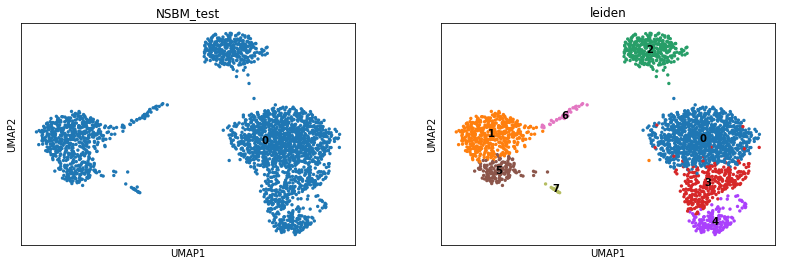

leiden        0    1    2    3    4    5   6   7
NSBM_test                                       
0          1143  486  341  306  163  150  36  13


In [29]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [26]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_sweep_wg.pkl",'wb'),2)

In [27]:
state_sweep_wg=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_sweep_wg.pkl", "rb" ))

#### il grafico weighted ci mette davvero troppo tempo sia a diventare un oggetto minimize,sia a fare uno sweep
# 2) normal graph

In [45]:
g = gt.Graph(directed=False)
adj=adata.uns['neighbors']['connectivities']
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])
pickle.dump(g,open("pbmc/pbmc_g.pkl",'wb'),2)

In [46]:
g = pickle.load( open( "pbmc/pbmc_g.pkl", "rb" ))

### 2a) minimize nested 
##### 2aa) base (56 sec)

In [47]:
a=time.time()
state=gt.minimize_nested_blockmodel_dl(g, deg_corr=False, verbose=True)
b=time.time()
state

    l=1  Current bracket: (1, 1, 1) (0.0, 0.0, 0.0)
    l=1  Current bracket: (1, 1, 1) (0.0, 0.0, 0.0)
    l=1  Bisect at B = 1 with S = 0
    l=1  Best result: B = 1, S = 0
level 1 : rejected replacement (1, 1) -> (1, 1) , dS: 0.0
    l=1  Current bracket: (1, 1, 1) (0.0, 0.0, 0.0)
    l=1  Current bracket: (1, 1, 1) (0.0, 0.0, 0.0)
    l=1  Bisect at B = 1 with S = 0
    l=1  Best result: B = 1, S = 0
level 1 : rejected insert 1 , dS: 0.0
    l=0      B: 1041 <- 2638    shrinking 2638 -> 2029
    l=0      B: 1041 <- 2638    B=2029  niter:     1  count:    0  breaks:  0  min_S: 143937.08  max_S: 144882.47  S: 143937.08  ΔS:     -945.397  moves:   428 
    l=0      B: 1041 <- 2638    B=2029  niter:     2  count:    0  breaks:  0  min_S: 143776.76  max_S: 144882.47  S: 143776.76  ΔS:     -160.317  moves:   140 
    l=0      B: 1041 <- 2638    B=2029  niter:     3  count:    0  breaks:  0  min_S: 143680.04  max_S: 144882.47  S: 143680.04  ΔS:     -96.7221  moves:    92 
    l=0      B: 

    l=0      B: 431 <- 1041    B=801  niter:     1  count:    0  breaks:  0  min_S: 131837.65  max_S: 132284.02  S: 131837.65  ΔS:     -446.367  moves:   306 
    l=0      B: 431 <- 1041    B=801  niter:     2  count:    0  breaks:  0  min_S: 131661.21  max_S: 132284.02  S: 131661.21  ΔS:     -176.449  moves:   143 
    l=0      B: 431 <- 1041    B=801  niter:     3  count:    0  breaks:  0  min_S: 131580.77  max_S: 132284.02  S: 131580.77  ΔS:     -80.4344  moves:    90 
    l=0      B: 431 <- 1041    B=801  niter:     4  count:    0  breaks:  0  min_S: 131518.09  max_S: 132284.02  S: 131518.09  ΔS:     -62.6835  moves:    77 
    l=0      B: 431 <- 1041    B=801  niter:     5  count:    0  breaks:  0  min_S: 131460.02  max_S: 132284.02  S: 131460.02  ΔS:     -58.0652  moves:    63 
    l=0      B: 431 <- 1041    B=801  niter:     6  count:    0  breaks:  0  min_S: 131406.60  max_S: 132284.02  S: 131406.60  ΔS:     -53.4271  moves:    69 
    l=0      B: 431 <- 1041    B=801  niter:  

    l=0      B: 431 <- 1041    B=431  niter:    10  count:    0  breaks:  0  min_S: 121847.43  max_S: 122334.68  S: 121847.43  ΔS:     -13.3974  moves:    21 
    l=0      B: 431 <- 1041    B=431  niter:    11  count:    0  breaks:  0  min_S: 121814.77  max_S: 122334.68  S: 121814.77  ΔS:     -32.6530  moves:    28 
    l=0      B: 431 <- 1041    B=431  niter:    12  count:    1  breaks:  1  min_S: 121814.77  max_S: 122334.68  S: 121804.96  ΔS:     -9.81461  moves:    13 
    l=0  Current bracket: (1, 431, 1041) (128192.00963581743, 121804.95912668391, 134679.42266434373)
    l=0      B: 664 <- 801    shrinking 801 -> 664
    l=0      B: 664 <- 801    B=664  niter:     1  count:    0  breaks:  0  min_S: 129007.32  max_S: 129363.96  S: 129007.32  ΔS:     -356.648  moves:   245 
    l=0      B: 664 <- 801    B=664  niter:     2  count:    0  breaks:  0  min_S: 128860.50  max_S: 129363.96  S: 128860.50  ΔS:     -146.821  moves:   120 
    l=0      B: 664 <- 801    B=664  niter:     3  cou

    l=0      B: 198 <- 431    B=198  niter:     3  count:    0  breaks:  0  min_S: 109938.52  max_S: 110555.96  S: 109938.52  ΔS:     -89.3818  moves:    81 
    l=0      B: 198 <- 431    B=198  niter:     4  count:    0  breaks:  0  min_S: 109880.72  max_S: 110555.96  S: 109880.72  ΔS:     -57.8015  moves:    59 
    l=0      B: 198 <- 431    B=198  niter:     5  count:    0  breaks:  0  min_S: 109812.01  max_S: 110555.96  S: 109812.01  ΔS:     -68.7084  moves:    71 
    l=0      B: 198 <- 431    B=198  niter:     6  count:    0  breaks:  0  min_S: 109777.61  max_S: 110555.96  S: 109777.61  ΔS:     -34.4008  moves:    34 
    l=0      B: 198 <- 431    B=198  niter:     7  count:    0  breaks:  0  min_S: 109714.60  max_S: 110555.96  S: 109714.60  ΔS:     -63.0061  moves:    48 
    l=0      B: 198 <- 431    B=198  niter:     8  count:    0  breaks:  0  min_S: 109687.41  max_S: 110555.96  S: 109687.41  ΔS:     -27.1896  moves:    35 
    l=0      B: 198 <- 431    B=198  niter:     9  c

    l=0      B: 109 <- 198    B=117  niter:    13  count:    0  breaks:  0  min_S: 103897.55  max_S: 104523.35  S: 103897.55  ΔS:     -11.5004  moves:    17 
    l=0      B: 109 <- 198    B=117  niter:    14  count:    0  breaks:  0  min_S: 103882.62  max_S: 104523.35  S: 103882.62  ΔS:     -14.9291  moves:    17 
    l=0      B: 109 <- 198    B=117  niter:    15  count:    0  breaks:  0  min_S: 103864.99  max_S: 104523.35  S: 103864.99  ΔS:     -17.6291  moves:    17 
    l=0      B: 109 <- 198    B=117  niter:    16  count:    1  breaks:  1  min_S: 103864.99  max_S: 104523.35  S: 103855.43  ΔS:     -9.55678  moves:    17 
    l=0      B: 109 <- 198    shrinking 117 -> 109
    l=0      B: 109 <- 198    B=109  niter:     1  count:    0  breaks:  0  min_S: 103402.74  max_S: 103441.39  S: 103402.74  ΔS:     -38.6547  moves:    33 
    l=0      B: 109 <- 198    B=109  niter:     2  count:    0  breaks:  0  min_S: 103362.73  max_S: 103441.39  S: 103362.73  ΔS:     -40.0088  moves:    30 
 

    l=0      B: 75 <- 84    B=75  niter:     1  count:    0  breaks:  0  min_S: 101364.79  max_S: 101404.20  S: 101364.79  ΔS:     -39.4156  moves:    36 
    l=0      B: 75 <- 84    B=75  niter:     2  count:    0  breaks:  0  min_S: 101309.21  max_S: 101404.20  S: 101309.21  ΔS:     -55.5762  moves:    35 
    l=0      B: 75 <- 84    B=75  niter:     3  count:    0  breaks:  0  min_S: 101291.40  max_S: 101404.20  S: 101291.40  ΔS:     -17.8102  moves:    18 
    l=0      B: 75 <- 84    B=75  niter:     4  count:    0  breaks:  0  min_S: 101257.21  max_S: 101404.20  S: 101257.21  ΔS:     -34.1921  moves:    22 
    l=0      B: 75 <- 84    B=75  niter:     5  count:    0  breaks:  0  min_S: 101235.24  max_S: 101404.20  S: 101235.24  ΔS:     -21.9685  moves:    20 
    l=0      B: 75 <- 84    B=75  niter:     6  count:    0  breaks:  0  min_S: 101212.10  max_S: 101404.20  S: 101212.10  ΔS:     -23.1349  moves:    22 
    l=0      B: 75 <- 84    B=75  niter:     7  count:    0  breaks:  

    l=0      B: 28 <- 33    B=28  niter:     1  count:    0  breaks:  0  min_S: 99407.012  max_S: 99515.688  S: 99407.012  ΔS:     -108.676  moves:    67 
    l=0      B: 28 <- 33    B=28  niter:     2  count:    0  breaks:  0  min_S: 99378.578  max_S: 99515.688  S: 99378.578  ΔS:     -28.4333  moves:    38 
    l=0      B: 28 <- 33    B=28  niter:     3  count:    0  breaks:  0  min_S: 99337.139  max_S: 99515.688  S: 99337.139  ΔS:     -41.4398  moves:    43 
    l=0      B: 28 <- 33    B=28  niter:     4  count:    0  breaks:  0  min_S: 99322.948  max_S: 99515.688  S: 99322.948  ΔS:     -14.1912  moves:    22 
    l=0      B: 28 <- 33    B=28  niter:     5  count:    1  breaks:  1  min_S: 99322.948  max_S: 99515.688  S: 99316.598  ΔS:     -6.34914  moves:    14 
    l=0  Current bracket: (25, 33, 41) (99419.38362526227, 99229.92488766841, 99505.55299365443)
    l=0  Bisect at B = 28 with S = 99316.59836885404
    l=0      B: 36 <- 41    shrinking 41 -> 36
    l=0      B: 36 <- 41    

    l=1      B: 7 <- 8    B=7  niter:     1  count:    0  breaks:  0  min_S: 1367.0095  max_S: 1368.5447  S: 1367.0095  ΔS:     -1.53519  moves:     1 
    l=1      B: 7 <- 8    B=7  niter:     2  count:    1  breaks:  1  min_S: 1367.0095  max_S: 1368.5447  S: 1367.0095  ΔS:      0.00000  moves:     0 
    l=1  Current bracket: (1, 5, 10) (2354.774798096324, 1370.0727709648795, 1393.1270064357252)
    l=1  Bisect at B = 7 with S = 1367.009516968723
    l=1  Current bracket: (5, 7, 10) (1370.0727709648795, 1367.0095169687231, 1393.1270064357252)
    l=1  Bisect at B = 8 with S = 1367.235162512218
    l=1  Current bracket: (5, 7, 8) (1370.0727709648795, 1367.0095169687231, 1367.2351625122183)
    l=1  Bisect at B = 6 with S = 1358.942155208883
    l=1  Best result: B = 6, S = 1358.942155208883
level 1 : replaced (31, 1) -> (31, 6) , dS: -995.8326428874425 3
    l=2      B: 3 <- 6    shrinking 6 -> 5
    l=2      B: 3 <- 6    B=5  niter:     1  count:    1  breaks:  1  min_S: 155.36177  m

    l=2      B: 3 <- 5    B=4  niter:     1  count:    0  breaks:  0  min_S: 220.24769  max_S: 220.89492  S: 220.24769  ΔS:    -0.647234  moves:     1 
    l=2      B: 3 <- 5    B=4  niter:     2  count:    1  breaks:  1  min_S: 220.24769  max_S: 220.89492  S: 220.24769  ΔS:      0.00000  moves:     0 
    l=2      B: 3 <- 5    shrinking 4 -> 3
    l=2      B: 3 <- 5    B=3  niter:     1  count:    1  breaks:  1  min_S: 213.70939  max_S: 213.70939  S: 213.70939  ΔS:      0.00000  moves:     0 
    l=2  Current bracket: (1, 5, 8) (258.2629805438883, 225.9709491373406, 270.9470249883134)
    l=2  Bisect at B = 3 with S = 213.709394754914
    l=2      B: 2 <- 3    shrinking 3 -> 2
    l=2      B: 2 <- 3    B=2  niter:     1  count:    1  breaks:  1  min_S: 215.47702  max_S: 215.47702  S: 215.47702  ΔS:      0.00000  moves:     0 
    l=2  Current bracket: (1, 3, 5) (258.2629805438883, 213.70939475491403, 225.9709491373406)
    l=2  Bisect at B = 2 with S = 215.4770195341691
    l=2  Curre

    l=1      B: 7 <- 10    B=8  niter:     1  count:    0  breaks:  0  min_S: 1256.9825  max_S: 1259.0441  S: 1256.9825  ΔS:     -2.06160  moves:     2 
    l=1      B: 7 <- 10    B=8  niter:     2  count:    1  breaks:  1  min_S: 1256.9825  max_S: 1259.0441  S: 1256.9825  ΔS:      0.00000  moves:     0 
    l=1      B: 7 <- 10    shrinking 8 -> 7
    l=1      B: 7 <- 10    B=7  niter:     1  count:    1  breaks:  1  min_S: 1265.2360  max_S: 1265.2360  S: 1265.2360  ΔS:      0.00000  moves:     0 
    l=1  Current bracket: (3, 10, 13) (1497.3035226299874, 1258.0350118274175, 1276.7497957061355)
    l=1  Bisect at B = 7 with S = 1265.236013235527
    l=1  Current bracket: (7, 10, 13) (1265.236013235527, 1258.0350118274175, 1276.7497957061355)
    l=1  Bisect at B = 8 with S = 1256.982540936836
    l=1      B: 9 <- 10    shrinking 10 -> 9
    l=1      B: 9 <- 10    B=9  niter:     1  count:    0  breaks:  0  min_S: 1255.0480  max_S: 1255.2767  S: 1255.0480  ΔS:    -0.228731  moves:     1

    l=1      B: 9 <- 10    B=9  niter:     1  count:    0  breaks:  0  min_S: 1240.4059  max_S: 1241.0112  S: 1240.4059  ΔS:    -0.605311  moves:     1 
    l=1      B: 9 <- 10    B=9  niter:     2  count:    0  breaks:  0  min_S: 1239.9630  max_S: 1241.0112  S: 1239.9630  ΔS:    -0.442948  moves:     1 
    l=1      B: 9 <- 10    B=9  niter:     3  count:    1  breaks:  1  min_S: 1239.9630  max_S: 1241.0112  S: 1239.9630  ΔS:      0.00000  moves:     0 
    l=1  Current bracket: (7, 8, 10) (1249.5342852009953, 1241.5558640986492, 1244.916829093493)
    l=1  Bisect at B = 9 with S = 1239.962952939544
    l=1  Current bracket: (8, 9, 10) (1241.5558640986492, 1239.9629529395443, 1244.916829093493)
    l=1  Bisect at B = 8 with S = 1241.555864098649
    l=1  Best result: B = 9, S = 1239.962952939544
level 1 : rejected replacement (31, 9) -> (31, 9) , dS: 14.710536798957037
    l=1      B: 18 <- 31    shrinking 31 -> 24
    l=1      B: 18 <- 31    B=24  niter:     1  count:    0  breaks:  

    l=0      B: 1041 <- 2638    B=1201  niter:     1  count:    0  breaks:  0  min_S: 113071.90  max_S: 113480.39  S: 113071.90  ΔS:     -408.495  moves:   260 
    l=0      B: 1041 <- 2638    B=1201  niter:     2  count:    0  breaks:  0  min_S: 112911.99  max_S: 113480.39  S: 112911.99  ΔS:     -159.909  moves:   144 
    l=0      B: 1041 <- 2638    B=1201  niter:     3  count:    0  breaks:  0  min_S: 112817.81  max_S: 113480.39  S: 112817.81  ΔS:     -94.1769  moves:    86 
    l=0      B: 1041 <- 2638    B=1201  niter:     4  count:    0  breaks:  0  min_S: 112751.86  max_S: 113480.39  S: 112751.86  ΔS:     -65.9486  moves:    69 
    l=0      B: 1041 <- 2638    B=1201  niter:     5  count:    0  breaks:  0  min_S: 112691.32  max_S: 113480.39  S: 112691.32  ΔS:     -60.5464  moves:    61 
    l=0      B: 1041 <- 2638    B=1201  niter:     6  count:    0  breaks:  0  min_S: 112650.90  max_S: 113480.39  S: 112650.90  ΔS:     -40.4194  moves:    49 
    l=0      B: 1041 <- 2638    B=

    l=0      B: 431 <- 1041    B=616  niter:     1  count:    0  breaks:  0  min_S: 105706.87  max_S: 106023.28  S: 105706.87  ΔS:     -316.411  moves:   192 
    l=0      B: 431 <- 1041    B=616  niter:     2  count:    0  breaks:  0  min_S: 105554.83  max_S: 106023.28  S: 105554.83  ΔS:     -152.039  moves:   125 
    l=0      B: 431 <- 1041    B=616  niter:     3  count:    0  breaks:  0  min_S: 105419.44  max_S: 106023.28  S: 105419.44  ΔS:     -135.394  moves:   105 
    l=0      B: 431 <- 1041    B=616  niter:     4  count:    0  breaks:  0  min_S: 105337.07  max_S: 106023.28  S: 105337.07  ΔS:     -82.3657  moves:    84 
    l=0      B: 431 <- 1041    B=616  niter:     5  count:    0  breaks:  0  min_S: 105270.20  max_S: 106023.28  S: 105270.20  ΔS:     -66.8664  moves:    58 
    l=0      B: 431 <- 1041    B=616  niter:     6  count:    0  breaks:  0  min_S: 105212.91  max_S: 106023.28  S: 105212.91  ΔS:     -57.2941  moves:    52 
    l=0      B: 431 <- 1041    B=616  niter:  

    l=0      B: 431 <- 1041    B=431  niter:    13  count:    0  breaks:  0  min_S: 102322.86  max_S: 102728.56  S: 102322.86  ΔS:     -15.1794  moves:    17 
    l=0      B: 431 <- 1041    B=431  niter:    14  count:    0  breaks:  0  min_S: 102307.82  max_S: 102728.56  S: 102307.82  ΔS:     -15.0425  moves:    19 
    l=0      B: 431 <- 1041    B=431  niter:    15  count:    0  breaks:  0  min_S: 102296.77  max_S: 102728.56  S: 102296.77  ΔS:     -11.0431  moves:    16 
    l=0      B: 431 <- 1041    B=431  niter:    16  count:    0  breaks:  0  min_S: 102284.75  max_S: 102728.56  S: 102284.75  ΔS:     -12.0184  moves:    18 
    l=0      B: 431 <- 1041    B=431  niter:    17  count:    1  breaks:  1  min_S: 102284.75  max_S: 102728.56  S: 102277.27  ΔS:     -7.48857  moves:    15 
    l=0  Current bracket: (9, 431, 1041) (106371.24910512709, 102277.26529779285, 110490.5733166337)
    l=0      B: 664 <- 801    shrinking 801 -> 664
    l=0      B: 664 <- 801    B=664  niter:     1  co

    l=0      B: 198 <- 431    B=198  niter:     1  count:    0  breaks:  0  min_S: 99650.266  max_S: 99793.108  S: 99650.266  ΔS:     -142.842  moves:    88 
    l=0      B: 198 <- 431    B=198  niter:     2  count:    0  breaks:  0  min_S: 99536.820  max_S: 99793.108  S: 99536.820  ΔS:     -113.446  moves:    71 
    l=0      B: 198 <- 431    B=198  niter:     3  count:    0  breaks:  0  min_S: 99460.702  max_S: 99793.108  S: 99460.702  ΔS:     -76.1187  moves:    58 
    l=0      B: 198 <- 431    B=198  niter:     4  count:    0  breaks:  0  min_S: 99402.511  max_S: 99793.108  S: 99402.511  ΔS:     -58.1904  moves:    46 
    l=0      B: 198 <- 431    B=198  niter:     5  count:    0  breaks:  0  min_S: 99331.254  max_S: 99793.108  S: 99331.254  ΔS:     -71.2577  moves:    35 
    l=0      B: 198 <- 431    B=198  niter:     6  count:    0  breaks:  0  min_S: 99281.429  max_S: 99793.108  S: 99281.429  ΔS:     -49.8240  moves:    34 
    l=0      B: 198 <- 431    B=198  niter:     7  c

    l=0      B: 109 <- 198    B=117  niter:     8  count:    0  breaks:  0  min_S: 98155.072  max_S: 98607.916  S: 98155.072  ΔS:     -24.5051  moves:    26 
    l=0      B: 109 <- 198    B=117  niter:     9  count:    0  breaks:  0  min_S: 98134.673  max_S: 98607.916  S: 98134.673  ΔS:     -20.3987  moves:    21 
    l=0      B: 109 <- 198    B=117  niter:    10  count:    0  breaks:  0  min_S: 98120.918  max_S: 98607.916  S: 98120.918  ΔS:     -13.7545  moves:    19 
    l=0      B: 109 <- 198    B=117  niter:    11  count:    0  breaks:  0  min_S: 98101.072  max_S: 98607.916  S: 98101.072  ΔS:     -19.8458  moves:    23 
    l=0      B: 109 <- 198    B=117  niter:    12  count:    0  breaks:  0  min_S: 98081.321  max_S: 98607.916  S: 98081.321  ΔS:     -19.7519  moves:    18 
    l=0      B: 109 <- 198    B=117  niter:    13  count:    1  breaks:  1  min_S: 98081.321  max_S: 98607.916  S: 98075.117  ΔS:     -6.20342  moves:     9 
    l=0      B: 109 <- 198    shrinking 117 -> 109
 

    l=0      B: 33 <- 54    B=33  niter:     1  count:    0  breaks:  0  min_S: 98064.122  max_S: 98148.507  S: 98064.122  ΔS:     -84.3848  moves:    45 
    l=0      B: 33 <- 54    B=33  niter:     2  count:    0  breaks:  0  min_S: 98013.292  max_S: 98148.507  S: 98013.292  ΔS:     -50.8301  moves:    19 
    l=0      B: 33 <- 54    B=33  niter:     3  count:    0  breaks:  0  min_S: 97990.790  max_S: 98148.507  S: 97990.790  ΔS:     -22.5014  moves:    15 
    l=0      B: 33 <- 54    B=33  niter:     4  count:    0  breaks:  0  min_S: 97974.252  max_S: 98148.507  S: 97974.252  ΔS:     -16.5384  moves:    14 
    l=0      B: 33 <- 54    B=33  niter:     5  count:    0  breaks:  0  min_S: 97957.032  max_S: 98148.507  S: 97957.032  ΔS:     -17.2201  moves:    12 
    l=0      B: 33 <- 54    B=33  niter:     6  count:    1  breaks:  1  min_S: 97957.032  max_S: 98148.507  S: 97954.909  ΔS:     -2.12262  moves:     5 
    l=0  Current bracket: (9, 54, 75) (106371.24910512709, 97605.54250

    l=1      B: 32 <- 66    B=32  niter:     1  count:    0  breaks:  0  min_S: 4108.8989  max_S: 4113.6729  S: 4108.8989  ΔS:     -4.77397  moves:     1 
    l=1      B: 32 <- 66    B=32  niter:     2  count:    0  breaks:  0  min_S: 4108.1885  max_S: 4113.6729  S: 4108.1885  ΔS:    -0.710449  moves:     1 
    l=1      B: 32 <- 66    B=32  niter:     3  count:    0  breaks:  0  min_S: 4098.7247  max_S: 4113.6729  S: 4098.7247  ΔS:     -9.46371  moves:     1 
    l=1      B: 32 <- 66    B=32  niter:     4  count:    0  breaks:  0  min_S: 4095.3051  max_S: 4113.6729  S: 4095.3051  ΔS:     -3.41968  moves:     2 
    l=1      B: 32 <- 66    B=32  niter:     5  count:    1  breaks:  1  min_S: 4095.3051  max_S: 4113.6729  S: 4095.3051  ΔS:      0.00000  moves:     0 
    l=1  Current bracket: (4, 32, 66) (4415.541345459593, 4095.3050616125593, 4628.698893504715)
    l=1      B: 45 <- 51    shrinking 51 -> 45
    l=1      B: 45 <- 51    B=45  niter:     1  count:    0  breaks:  0  min_S: 4

    l=3      B: 3 <- 6    shrinking 6 -> 5
    l=3      B: 3 <- 6    B=5  niter:     1  count:    1  breaks:  1  min_S: 154.42002  max_S: 154.42002  S: 154.42002  ΔS:      0.00000  moves:     0 
    l=3      B: 3 <- 6    shrinking 5 -> 4
    l=3      B: 3 <- 6    B=4  niter:     1  count:    1  breaks:  1  min_S: 148.40601  max_S: 148.40601  S: 148.40601  ΔS:      0.00000  moves:     0 
    l=3      B: 3 <- 6    shrinking 4 -> 3
    l=3      B: 3 <- 6    B=3  niter:     1  count:    1  breaks:  1  min_S: 144.89942  max_S: 144.89942  S: 144.89942  ΔS:      0.00000  moves:     0 
    l=3  Current bracket: (1, 3, 6) (158.48883531034744, 144.8994234160936, 166.8598459915856)
    l=3  Current bracket: (1, 3, 6) (158.48883531034744, 144.8994234160936, 166.8598459915856)
    l=3  Bisect at B = 4 with S = 148.4060063989702
    l=3      B: 2 <- 3    shrinking 3 -> 2
    l=3      B: 2 <- 3    B=2  niter:     1  count:    1  breaks:  1  min_S: 139.56200  max_S: 139.56200  S: 139.56200  ΔS:      0

    l=1      B: 14 <- 15    B=14  niter:     1  count:    1  breaks:  1  min_S: 3899.1223  max_S: 3899.1223  S: 3899.1223  ΔS:      0.00000  moves:     0 
    l=1  Current bracket: (6, 11, 19) (4232.515267676103, 3899.5318073985673, 3921.4559368663654)
    l=1  Bisect at B = 14 with S = 3899.12226244826
    l=1      B: 16 <- 19    shrinking 19 -> 16
    l=1      B: 16 <- 19    B=16  niter:     1  count:    0  breaks:  0  min_S: 3902.9720  max_S: 3903.3903  S: 3902.9720  ΔS:    -0.418353  moves:     1 
    l=1      B: 16 <- 19    B=16  niter:     2  count:    1  breaks:  1  min_S: 3902.9720  max_S: 3903.3903  S: 3902.9720  ΔS:      0.00000  moves:     0 
    l=1  Current bracket: (11, 14, 19) (3899.5318073985673, 3899.12226244826, 3921.4559368663654)
    l=1  Bisect at B = 16 with S = 3902.971978639881
    l=1  Current bracket: (11, 14, 16) (3899.5318073985673, 3899.12226244826, 3902.9719786398814)
    l=1  Bisect at B = 12 with S = 3905.564780801497
    l=1      B: 13 <- 14    shrinkin

    l=1      B: 32 <- 66    B=32  niter:     1  count:    0  breaks:  0  min_S: 3983.0706  max_S: 3989.2602  S: 3983.0706  ΔS:     -6.18959  moves:     3 
    l=1      B: 32 <- 66    B=32  niter:     2  count:    0  breaks:  0  min_S: 3980.2526  max_S: 3989.2602  S: 3980.2526  ΔS:     -2.81794  moves:     1 
    l=1      B: 32 <- 66    B=32  niter:     3  count:    0  breaks:  0  min_S: 3979.6016  max_S: 3989.2602  S: 3979.6016  ΔS:    -0.651047  moves:     2 
    l=1      B: 32 <- 66    B=32  niter:     4  count:    1  breaks:  1  min_S: 3979.6016  max_S: 3989.2602  S: 3979.6016  ΔS:      0.00000  moves:     0 
    l=1  Current bracket: (7, 32, 66) (4129.300191091429, 3979.601601795378, 4336.551015817898)
    l=1      B: 45 <- 51    shrinking 51 -> 45
    l=1      B: 45 <- 51    B=45  niter:     1  count:    1  breaks:  1  min_S: 4032.2555  max_S: 4032.2555  S: 4032.2555  ΔS:      0.00000  moves:     0 
    l=1  Current bracket: (7, 32, 66) (4129.300191091429, 3979.601601795378, 4336.

    l=1      B: 24 <- 25    B=24  niter:     1  count:    0  breaks:  0  min_S: 3915.6261  max_S: 3916.0190  S: 3915.6261  ΔS:    -0.392869  moves:     1 
    l=1      B: 24 <- 25    B=24  niter:     2  count:    1  breaks:  1  min_S: 3915.6261  max_S: 3916.0190  S: 3915.6261  ΔS:      0.00000  moves:     0 
    l=1  Current bracket: (7, 19, 32) (4129.300191091429, 3886.2404064788752, 3976.2760706337267)
    l=1  Bisect at B = 24 with S = 3915.626117498226
    l=1      B: 14 <- 19    shrinking 19 -> 15
    l=1      B: 14 <- 19    B=15  niter:     1  count:    1  breaks:  1  min_S: 3868.1073  max_S: 3868.1073  S: 3868.1073  ΔS:      0.00000  moves:     0 
    l=1      B: 14 <- 19    shrinking 15 -> 14
    l=1      B: 14 <- 19    B=14  niter:     1  count:    1  breaks:  1  min_S: 3875.7725  max_S: 3875.7725  S: 3875.7725  ΔS:      0.00000  moves:     0 
    l=1  Current bracket: (7, 19, 24) (4129.300191091429, 3886.2404064788752, 3915.6261174982255)
    l=1  Bisect at B = 14 with S = 38

    l=0      B: 1041 <- 2638    B=1201  niter:    13  count:    0  breaks:  0  min_S: 111481.81  max_S: 112321.05  S: 111481.81  ΔS:     -15.7042  moves:    23 
    l=0      B: 1041 <- 2638    B=1201  niter:    14  count:    0  breaks:  0  min_S: 111463.96  max_S: 112321.05  S: 111463.96  ΔS:     -17.8470  moves:    22 
    l=0      B: 1041 <- 2638    B=1201  niter:    15  count:    0  breaks:  0  min_S: 111449.24  max_S: 112321.05  S: 111449.24  ΔS:     -14.7210  moves:    22 
    l=0      B: 1041 <- 2638    B=1201  niter:    16  count:    0  breaks:  0  min_S: 111437.22  max_S: 112321.05  S: 111437.22  ΔS:     -12.0161  moves:    17 
    l=0      B: 1041 <- 2638    B=1201  niter:    17  count:    0  breaks:  0  min_S: 111419.69  max_S: 112321.05  S: 111419.69  ΔS:     -17.5303  moves:    22 
    l=0      B: 1041 <- 2638    B=1201  niter:    18  count:    0  breaks:  0  min_S: 111404.57  max_S: 112321.05  S: 111404.57  ΔS:     -15.1187  moves:    22 
    l=0      B: 1041 <- 2638    B=

    l=0      B: 431 <- 1041    B=474  niter:     1  count:    0  breaks:  0  min_S: 103308.83  max_S: 103565.21  S: 103308.83  ΔS:     -256.385  moves:   147 
    l=0      B: 431 <- 1041    B=474  niter:     2  count:    0  breaks:  0  min_S: 103128.12  max_S: 103565.21  S: 103128.12  ΔS:     -180.707  moves:   109 
    l=0      B: 431 <- 1041    B=474  niter:     3  count:    0  breaks:  0  min_S: 103034.29  max_S: 103565.21  S: 103034.29  ΔS:     -93.8322  moves:    76 
    l=0      B: 431 <- 1041    B=474  niter:     4  count:    0  breaks:  0  min_S: 102954.78  max_S: 103565.21  S: 102954.78  ΔS:     -79.5134  moves:    75 
    l=0      B: 431 <- 1041    B=474  niter:     5  count:    0  breaks:  0  min_S: 102896.25  max_S: 103565.21  S: 102896.25  ΔS:     -58.5249  moves:    60 
    l=0      B: 431 <- 1041    B=474  niter:     6  count:    0  breaks:  0  min_S: 102849.00  max_S: 103565.21  S: 102849.00  ΔS:     -47.2481  moves:    49 
    l=0      B: 431 <- 1041    B=474  niter:  

    l=0      B: 198 <- 431    B=332  niter:    16  count:    0  breaks:  0  min_S: 100481.70  max_S: 101483.88  S: 100481.70  ΔS:     -14.6430  moves:    21 
    l=0      B: 198 <- 431    B=332  niter:    17  count:    1  breaks:  1  min_S: 100481.70  max_S: 101483.88  S: 100475.83  ΔS:     -5.86415  moves:    12 
    l=0      B: 198 <- 431    shrinking 332 -> 255
    l=0      B: 198 <- 431    B=255  niter:     1  count:    0  breaks:  0  min_S: 100048.41  max_S: 100289.89  S: 100048.41  ΔS:     -241.480  moves:   124 
    l=0      B: 198 <- 431    B=255  niter:     2  count:    0  breaks:  0  min_S: 99893.726  max_S: 100289.89  S: 99893.726  ΔS:     -154.686  moves:    92 
    l=0      B: 198 <- 431    B=255  niter:     3  count:    0  breaks:  0  min_S: 99781.257  max_S: 100289.89  S: 99781.257  ΔS:     -112.469  moves:    68 
    l=0      B: 198 <- 431    B=255  niter:     4  count:    0  breaks:  0  min_S: 99698.919  max_S: 100289.89  S: 99698.919  ΔS:     -82.3385  moves:    60 
 

    l=0      B: 109 <- 198    B=152  niter:     1  count:    0  breaks:  0  min_S: 98570.716  max_S: 98700.704  S: 98570.716  ΔS:     -129.987  moves:    74 
    l=0      B: 109 <- 198    B=152  niter:     2  count:    0  breaks:  0  min_S: 98487.360  max_S: 98700.704  S: 98487.360  ΔS:     -83.3558  moves:    60 
    l=0      B: 109 <- 198    B=152  niter:     3  count:    0  breaks:  0  min_S: 98438.999  max_S: 98700.704  S: 98438.999  ΔS:     -48.3612  moves:    46 
    l=0      B: 109 <- 198    B=152  niter:     4  count:    0  breaks:  0  min_S: 98384.753  max_S: 98700.704  S: 98384.753  ΔS:     -54.2462  moves:    36 
    l=0      B: 109 <- 198    B=152  niter:     5  count:    0  breaks:  0  min_S: 98351.693  max_S: 98700.704  S: 98351.693  ΔS:     -33.0599  moves:    29 
    l=0      B: 109 <- 198    B=152  niter:     6  count:    0  breaks:  0  min_S: 98320.064  max_S: 98700.704  S: 98320.064  ΔS:     -31.6287  moves:    30 
    l=0      B: 109 <- 198    B=152  niter:     7  c

    l=0      B: 54 <- 109    B=65  niter:     1  count:    0  breaks:  0  min_S: 97604.553  max_S: 97652.189  S: 97604.553  ΔS:     -47.6363  moves:    36 
    l=0      B: 54 <- 109    B=65  niter:     2  count:    0  breaks:  0  min_S: 97562.667  max_S: 97652.189  S: 97562.667  ΔS:     -41.8863  moves:    38 
    l=0      B: 54 <- 109    B=65  niter:     3  count:    0  breaks:  0  min_S: 97528.140  max_S: 97652.189  S: 97528.140  ΔS:     -34.5270  moves:    33 
    l=0      B: 54 <- 109    B=65  niter:     4  count:    0  breaks:  0  min_S: 97474.496  max_S: 97652.189  S: 97474.496  ΔS:     -53.6436  moves:    23 
    l=0      B: 54 <- 109    B=65  niter:     5  count:    0  breaks:  0  min_S: 97457.434  max_S: 97652.189  S: 97457.434  ΔS:     -17.0618  moves:    14 
    l=0      B: 54 <- 109    B=65  niter:     6  count:    0  breaks:  0  min_S: 97446.418  max_S: 97652.189  S: 97446.418  ΔS:     -11.0161  moves:    12 
    l=0      B: 54 <- 109    B=65  niter:     7  count:    1  br

    l=0      B: 70 <- 75    shrinking 75 -> 70
    l=0      B: 70 <- 75    B=70  niter:     1  count:    0  breaks:  0  min_S: 97360.721  max_S: 97374.890  S: 97360.721  ΔS:     -14.1700  moves:    18 
    l=0      B: 70 <- 75    B=70  niter:     2  count:    1  breaks:  1  min_S: 97360.721  max_S: 97374.890  S: 97352.098  ΔS:     -8.62269  moves:     8 
    l=0  Current bracket: (67, 75, 80) (97302.69463230378, 97294.63663934989, 97351.40740188383)
    l=0  Bisect at B = 70 with S = 97352.09780608711
    l=0      B: 72 <- 75    shrinking 75 -> 72
    l=0      B: 72 <- 75    B=72  niter:     1  count:    0  breaks:  0  min_S: 97282.874  max_S: 97299.383  S: 97282.874  ΔS:     -16.5089  moves:    16 
    l=0      B: 72 <- 75    B=72  niter:     2  count:    0  breaks:  0  min_S: 97268.026  max_S: 97299.383  S: 97268.026  ΔS:     -14.8477  moves:    15 
    l=0      B: 72 <- 75    B=72  niter:     3  count:    0  breaks:  0  min_S: 97257.421  max_S: 97299.383  S: 97257.421  ΔS:     -10.6

<NestedBlockState object, with base <BlockState object with 66 blocks (66 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ff806c26950>, at 0x7ff807417290>, and 5 levels of sizes [(2638, 66), (66, 15), (15, 7), (7, 2), (2, 1)] at 0x7ff7f9a5ac90>

In [48]:
c=b-a
c

56.055877923965454

leiden       0    1    2    3    4    5   6   7
NSBM_test                                      
0          494    0    1    0    0    0   0   0
1            0    0  339    0    0    0   0   0
2          247    0    1    5    0    1   0   0
3            0  486    0    0    0  146   4   0
4            4    0    0  253  163    0   0   0
5          398    0    0   48    0    1   0   0
6            0    0    0    0    0    2  32  13


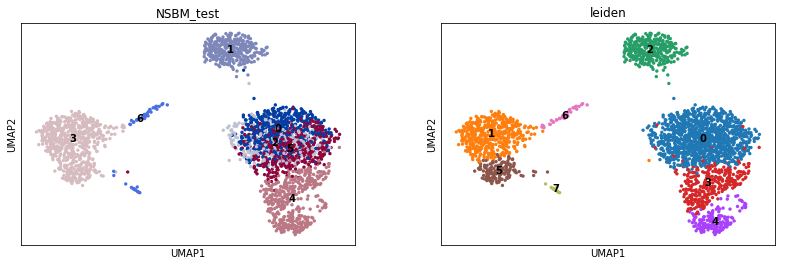

In [63]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state_sweep_g.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [50]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_sweep_g.pkl",'wb'),2)

In [51]:
state_sweep_g=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_sweep_g.pkl", "rb" ))

##### 2ab) sweep 100 ( 122 sec)

In [52]:
a=time.time()
state=gt.minimize_nested_blockmodel_dl(g, deg_corr=False, mcmc_args=dict(niter=100))
b=time.time()
state

<NestedBlockState object, with base <BlockState object with 62 blocks (62 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ff806c26950>, at 0x7ff806c55e10>, and 5 levels of sizes [(2638, 62), (62, 15), (15, 6), (6, 2), (2, 1)] at 0x7ff80625dd10>

In [53]:
c=b-a
c

122.125741481781

leiden        0    1    2    3    4    5   6   7
NSBM_test                                       
0          1042    0    0   42    0    0   0   0
1             0    0  339    0    0    0   0   0
2             0  478    0    0    0  146   0   0
3             3    0    0  250  163    0   0   0
4            98    0    2   14    0    2   0   0
5             0    8    0    0    0    2  36  13


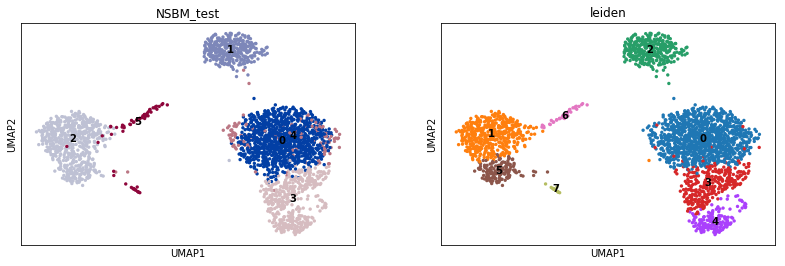

In [61]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [55]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_sweep100_g.pkl",'wb'),2)

In [56]:
state_sweep100_g=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_sweep100_g.pkl", "rb" ))

##### 2ac) sweep 1000 (500 secondi (circa 8 min))

In [64]:
a=time.time()
state=gt.minimize_nested_blockmodel_dl(g, deg_corr=False, mcmc_args=dict(niter=1000))
b=time.time()
state

<NestedBlockState object, with base <BlockState object with 47 blocks (47 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ff806c26950>, at 0x7ff805fbfc10>, and 5 levels of sizes [(2638, 47), (47, 15), (15, 6), (6, 2), (2, 1)] at 0x7ff808d2dc90>

In [65]:
c=b-a
c

493.2651102542877

leiden        0    1    2    3    4   5   6   7
NSBM_test                                      
0          1113    0    2   19    0   1   0   0
1             0    0  339    0    0   0   0   0
2             0  457    0    0    0  49   0   0
3            30    0    0  287  163   1   0   0
4             0   28    0    0    0  97   0   0
5             0    1    0    0    0   2  36  13


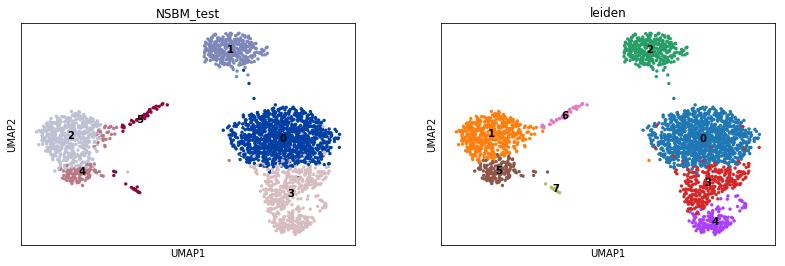

In [66]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [67]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_sweep1k_g.pkl",'wb'),2)

In [68]:
state_sweep1k_g=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_sweep1k_g.pkl", "rb" ))

##### 2ad) sweep 10000 (3805 secondi( 60 min)) DURA DAVVERO TROPPO

In [69]:
a=time.time()
state=gt.minimize_nested_blockmodel_dl(g, deg_corr=False, mcmc_args=dict(niter=10000))
b=time.time()
state

<NestedBlockState object, with base <BlockState object with 53 blocks (53 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ff806c26950>, at 0x7ff7f415ff50>, and 5 levels of sizes [(2638, 53), (53, 11), (11, 5), (5, 2), (2, 1)] at 0x7ff7f996aa10>

leiden       0    1    2    3    4    5   6   7
NSBM_test                                      
0          784    0    0   60    0    1   0   0
1            0    0  339    0    0    0   0   0
2          357    0    2    2    0    1   0   0
3            0  486    0    0    0  148  36  13
4            2    0    0  244  163    0   0   0


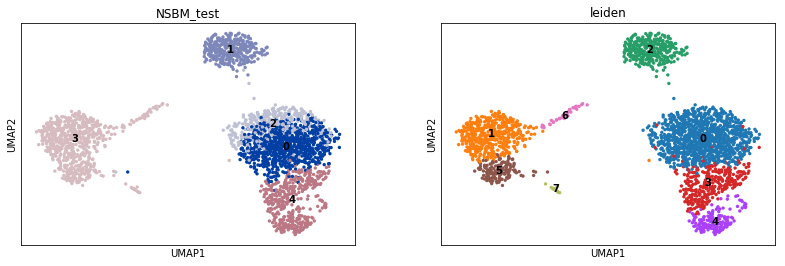

In [77]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [71]:
c=b-a
c

3805.03298163414

In [72]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_sweep10k_g.pkl",'wb'),2)

In [73]:
state_sweep10k_g=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_sweep10k_g.pkl", "rb" ))

### 2b) equilibrate
##### 2ba) w=100 nbreaks=2 epsilon=0.01 (25 sec)

In [90]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep10k_g.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=10, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [91]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)

a=time.time()
gt.mcmc_equilibrate(state, wait=100,nbreaks=2, max_niter=10000,epsilon=0.01, mcmc_args=dict(niter=10),callback=collect_info, verbose=True)
b=time.time()
state

niter:     1  count:    1  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97642.482  ΔS:      161.296  moves:  7298 
niter:     2  count:    2  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97627.790  ΔS:     -14.6918  moves:  7192 
niter:     3  count:    3  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97615.050  ΔS:     -12.7398  moves:  7196 
niter:     4  count:    4  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97621.547  ΔS:      6.49677  moves:  7238 
niter:     5  count:    5  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97627.610  ΔS:      6.06328  moves:  7137 
niter:     6  count:    6  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97622.077  ΔS:     -5.53261  moves:  6987 
niter:     7  count:    7  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97617.485  ΔS:     -4.59215  moves:  7105 
niter:     8  count:    8  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97557.758  ΔS:     -59.7270  moves:  7100 
niter:     9  count:    9  break

niter:    70  count:   70  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97460.946  ΔS:      83.0774  moves:  7059 
niter:    71  count:   71  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97483.215  ΔS:      22.2689  moves:  7123 
niter:    72  count:   72  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97434.013  ΔS:     -49.2024  moves:  7146 
niter:    73  count:   73  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97406.576  ΔS:     -27.4372  moves:  7137 
niter:    74  count:   74  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97420.294  ΔS:      13.7188  moves:  7129 
niter:    75  count:   75  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97438.945  ΔS:      18.6507  moves:  7160 
niter:    76  count:   76  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97398.371  ΔS:     -40.5745  moves:  7047 
niter:    77  count:   77  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97385.877  ΔS:     -12.4936  moves:  7237 
niter:    78  count:   78  break

niter:   138  count:   38  breaks:  1  min_S: 97423.353  max_S: 97423.353  S: 97363.940  ΔS:      10.7590  moves:  7083 
niter:   139  count:   39  breaks:  1  min_S: 97423.353  max_S: 97423.353  S: 97345.506  ΔS:     -18.4335  moves:  7199 
niter:   140  count:   40  breaks:  1  min_S: 97423.353  max_S: 97423.353  S: 97361.337  ΔS:      15.8309  moves:  7038 
niter:   141  count:   41  breaks:  1  min_S: 97423.353  max_S: 97423.353  S: 97368.947  ΔS:      7.61011  moves:  7163 
niter:   142  count:   42  breaks:  1  min_S: 97423.353  max_S: 97423.353  S: 97370.275  ΔS:      1.32774  moves:  7125 
niter:   143  count:   43  breaks:  1  min_S: 97423.353  max_S: 97423.353  S: 97359.207  ΔS:     -11.0675  moves:  7070 
niter:   144  count:   44  breaks:  1  min_S: 97423.353  max_S: 97423.353  S: 97408.948  ΔS:      49.7407  moves:  7133 
niter:   145  count:   45  breaks:  1  min_S: 97423.353  max_S: 97423.353  S: 97373.608  ΔS:     -35.3398  moves:  7181 
niter:   146  count:   46  break

<NestedBlockState object, with base <BlockState object with 52 blocks (50 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ff7f415e7d0>, at 0x7ff805c25510>, and 10 levels of sizes [(2638, 50), (50, 18), (18, 8), (8, 5), (5, 5), (5, 3), (3, 3), (3, 3), (3, 2), (2, 2)] at 0x7ff805c25f10>

In [92]:
c=b-a
c

25.19079041481018

leiden        0    1    2    3    4    5   6   7
NSBM_test                                       
0             0    0    0   60  162    0   0   0
1          1104    0    0   19    0    2   0   0
2             0    0  341    0    0    0   0   0
3             0   27    0    0    0    0   4   0
5             0    0    0    0    0    0  32   0
7             0  458    0    0    0   30   0   0
8             0    1    0    0    0  118   0  13
9            39    0    0  227    1    0   0   0


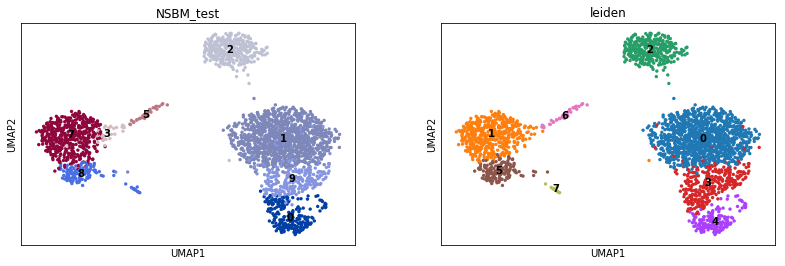

In [93]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [96]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_w100_e01.pkl",'wb'),2)
pickle.dump(h,open("pbmc/pbmc_weighted_vs_normal/h_w100_e01.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pbmc_weighted_vs_normal/pv_w100_e01.pkl",'wb'),2)

In [97]:
e_state_w100_e01=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_w100_e01.pkl", "rb" ))
h_w100_e01=pickle.load( open("pbmc/pbmc_weighted_vs_normal/h_w100_e01.pkl", "rb" ))
pv_w100_e01=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/pv_w100_e01.pkl", "rb" ))

##### 2bb) w=100 nbreaks=3 e=0.01 (35 sec)

In [98]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=10, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [99]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)

a=time.time()
gt.mcmc_equilibrate(state, wait=100,nbreaks=3, max_niter=10000,epsilon=0.01, mcmc_args=dict(niter=10),callback=collect_info, verbose=True)
b=time.time()
state

niter:     1  count:    1  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97638.990  ΔS:      157.805  moves:  7329 
niter:     2  count:    2  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97615.366  ΔS:     -23.6239  moves:  7270 
niter:     3  count:    3  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97688.304  ΔS:      72.9374  moves:  7387 
niter:     4  count:    4  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97668.952  ΔS:     -19.3516  moves:  7372 
niter:     5  count:    5  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97665.871  ΔS:     -3.08067  moves:  7297 
niter:     6  count:    6  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97654.105  ΔS:     -11.7661  moves:  7087 
niter:     7  count:    7  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97581.691  ΔS:     -72.4146  moves:  7223 
niter:     8  count:    8  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97599.287  ΔS:      17.5960  moves:  7262 
niter:     9  count:    9  break

niter:    69  count:   69  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97538.492  ΔS:      14.7645  moves:  7083 
niter:    70  count:   70  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97550.184  ΔS:      11.6924  moves:  7112 
niter:    71  count:   71  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97526.549  ΔS:     -23.6352  moves:  7273 
niter:    72  count:   72  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97488.311  ΔS:     -38.2377  moves:  7008 
niter:    73  count:   73  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97468.822  ΔS:     -19.4888  moves:  7122 
niter:    74  count:   74  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97485.135  ΔS:      16.3126  moves:  7184 
niter:    75  count:   75  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97491.921  ΔS:      6.78553  moves:  7185 
niter:    76  count:   76  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97537.898  ΔS:      45.9779  moves:  7202 
niter:    77  count:   77  break

niter:   137  count:   37  breaks:  1  min_S: 97463.273  max_S: 97463.273  S: 97435.439  ΔS:     -3.05405  moves:  7096 
niter:   138  count:   38  breaks:  1  min_S: 97463.273  max_S: 97463.273  S: 97458.955  ΔS:      23.5159  moves:  7127 
niter:   139  count:   39  breaks:  1  min_S: 97463.273  max_S: 97463.273  S: 97497.937  ΔS:      38.9819  moves:  7212 
niter:   140  count:   40  breaks:  1  min_S: 97463.273  max_S: 97463.273  S: 97497.443  ΔS:    -0.493278  moves:  7108 
niter:   141  count:   41  breaks:  1  min_S: 97463.273  max_S: 97463.273  S: 97546.888  ΔS:      49.4447  moves:  6940 
niter:   142  count:   42  breaks:  1  min_S: 97463.273  max_S: 97463.273  S: 97478.371  ΔS:     -68.5166  moves:  7099 
niter:   143  count:   43  breaks:  1  min_S: 97463.273  max_S: 97463.273  S: 97390.863  ΔS:     -87.5083  moves:  7229 
niter:   144  count:   44  breaks:  1  min_S: 97463.273  max_S: 97463.273  S: 97431.600  ΔS:      40.7364  moves:  7006 
niter:   145  count:   45  break

niter:   205  count:    5  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97456.358  ΔS:      37.8252  moves:  7089 
niter:   206  count:    6  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97489.300  ΔS:      32.9421  moves:  7153 
niter:   207  count:    7  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97514.174  ΔS:      24.8733  moves:  6984 
niter:   208  count:    8  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97513.305  ΔS:    -0.869109  moves:  7201 
niter:   209  count:    9  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97486.747  ΔS:     -26.5575  moves:  7170 
niter:   210  count:   10  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97472.136  ΔS:     -14.6109  moves:  7076 
niter:   211  count:   11  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97485.249  ΔS:      13.1124  moves:  6978 
niter:   212  count:   12  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97446.214  ΔS:     -39.0348  moves:  7046 
niter:   213  count:   13  break

niter:   273  count:   73  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97459.466  ΔS:      46.0695  moves:  7030 
niter:   274  count:   74  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97521.711  ΔS:      62.2441  moves:  6912 
niter:   275  count:   75  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97479.211  ΔS:     -42.4995  moves:  6981 
niter:   276  count:   76  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97431.908  ΔS:     -47.3032  moves:  7003 
niter:   277  count:   77  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97490.441  ΔS:      58.5335  moves:  7104 
niter:   278  count:   78  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97426.868  ΔS:     -63.5735  moves:  6923 
niter:   279  count:   79  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97520.594  ΔS:      93.7258  moves:  6996 
niter:   280  count:   80  breaks:  2  min_S: 97461.589  max_S: 97461.589  S: 97465.630  ΔS:     -54.9639  moves:  7115 
niter:   281  count:   81  break

<NestedBlockState object, with base <BlockState object with 52 blocks (50 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ff7f415e7d0>, at 0x7ff80550e9d0>, and 10 levels of sizes [(2638, 50), (50, 19), (19, 8), (8, 5), (5, 5), (5, 4), (4, 4), (4, 4), (4, 4), (4, 2)] at 0x7ff80550e5d0>

In [100]:
c=b-a
c

35.48507261276245

leiden        0    1    2    3    4    5   6   7
NSBM_test                                       
0          1102    0    0   19    0    2   0   0
1             0    0  264    0    0    0   0   0
2             0    0    0    0    0    2  32  13
4             0    0    0   77  162    0   0   0
5            41    0    0  210    1    0   0   0
7             0    0   77    0    0    0   0   0
8             0  457    0    0    0   35   0   0
9             0   29    0    0    0  111   4   0


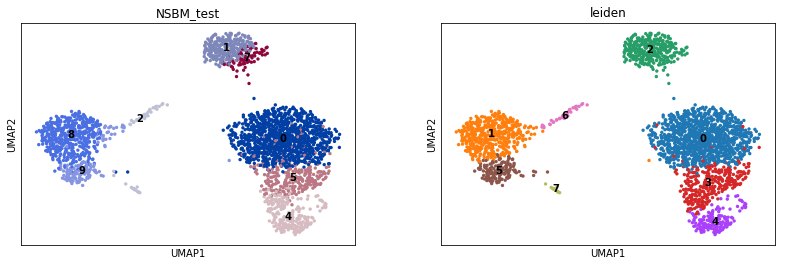

In [101]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [102]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_w100_e01_nb3.pkl",'wb'),2)
pickle.dump(h,open("pbmc/pbmc_weighted_vs_normal/h_w100_e01_nb3.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pbmc_weighted_vs_normal/pv_w100_e01_nb3.pkl",'wb'),2)

In [103]:
e_state_w100_e01_nb3=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_w100_e01_nb3.pkl", "rb" ))
h_w100_e01_nb3=pickle.load( open("pbmc/pbmc_weighted_vs_normal/h_w100_e01_nb3.pkl", "rb" ))
pv_w100_e01_nb3=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/pv_w100_e01_nb3.pkl", "rb" ))

##### 2bc) w=100, nbreaks=2, epsilon=0.001 (24 secondi)

In [104]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=10, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [105]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)

a=time.time()
gt.mcmc_equilibrate(state, wait=100,nbreaks=2, max_niter=10000,epsilon=0.001, mcmc_args=dict(niter=10),callback=collect_info, verbose=True)
b=time.time()
state

niter:     1  count:    0  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97624.256  ΔS:      143.070  moves:  7243 
niter:     2  count:    1  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97608.524  ΔS:     -15.7314  moves:  7312 
niter:     3  count:    2  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97687.066  ΔS:      78.5417  moves:  7298 
niter:     4  count:    3  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97595.293  ΔS:     -91.7733  moves:  7237 
niter:     5  count:    4  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97606.847  ΔS:      11.5548  moves:  7222 
niter:     6  count:    5  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97553.457  ΔS:     -53.3900  moves:  7242 
niter:     7  count:    6  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97641.976  ΔS:      88.5188  moves:  7316 
niter:     8  count:    7  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97591.677  ΔS:     -50.2992  moves:  7355 
niter:     9  count:    8  break

niter:    70  count:   69  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97482.440  ΔS:      13.4180  moves:  7042 
niter:    71  count:   70  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97457.102  ΔS:     -25.3377  moves:  7149 
niter:    72  count:   71  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97478.413  ΔS:      21.3104  moves:  7166 
niter:    73  count:   72  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97490.020  ΔS:      11.6078  moves:  7142 
niter:    74  count:   73  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97513.958  ΔS:      23.9371  moves:  7225 
niter:    75  count:   74  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97505.572  ΔS:     -8.38594  moves:  7176 
niter:    76  count:   75  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97503.608  ΔS:     -1.96330  moves:  7139 
niter:    77  count:   76  breaks:  0  min_S: 97481.186  max_S: 97624.256  S: 97464.782  ΔS:     -38.8259  moves:  7150 
niter:    78  count:   77  break

niter:   138  count:   37  breaks:  1  min_S: 97459.398  max_S: 97459.398  S: 97491.503  ΔS:      21.6967  moves:  7071 
niter:   139  count:   38  breaks:  1  min_S: 97459.398  max_S: 97459.398  S: 97457.798  ΔS:     -33.7050  moves:  6941 
niter:   140  count:   39  breaks:  1  min_S: 97459.398  max_S: 97459.398  S: 97500.373  ΔS:      42.5756  moves:  6986 
niter:   141  count:   40  breaks:  1  min_S: 97459.398  max_S: 97459.398  S: 97492.327  ΔS:     -8.04589  moves:  6864 
niter:   142  count:   41  breaks:  1  min_S: 97459.398  max_S: 97459.398  S: 97446.720  ΔS:     -45.6076  moves:  6954 
niter:   143  count:   42  breaks:  1  min_S: 97459.398  max_S: 97459.398  S: 97410.866  ΔS:     -35.8537  moves:  6926 
niter:   144  count:   43  breaks:  1  min_S: 97459.398  max_S: 97459.398  S: 97453.332  ΔS:      42.4661  moves:  7112 
niter:   145  count:   44  breaks:  1  min_S: 97459.398  max_S: 97459.398  S: 97450.698  ΔS:     -2.63454  moves:  6883 
niter:   146  count:   45  break

<NestedBlockState object, with base <BlockState object with 51 blocks (50 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ff7f415e7d0>, at 0x7ff805588710>, and 10 levels of sizes [(2638, 50), (50, 15), (15, 7), (7, 5), (5, 3), (3, 3), (3, 3), (3, 3), (3, 2), (2, 2)] at 0x7ff805588690>

In [106]:
c=b-a
c

24.41656756401062

leiden        0    1    2    3    4   5   6   7
NSBM_test                                      
0          1094    0    0   21    0   2   0   0
1             0    0    0   80  163   0   0   0
3             1    0  341    0    0   0   6   0
4             0  463    0    0    0  53   0   0
6            48    0    0  205    0   0   0   0
8             0    0    0    0    0   2  26  13
10            0   23    0    0    0  93   4   0


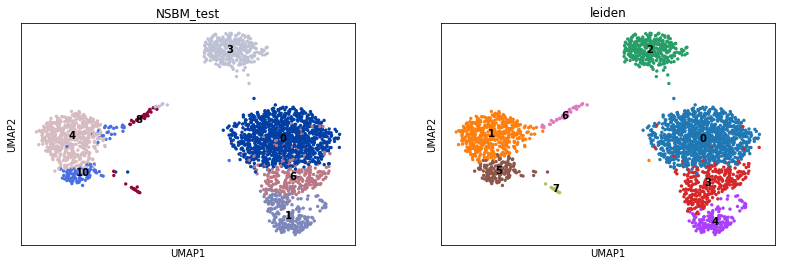

In [107]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [108]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_w100_e001.pkl",'wb'),2)
pickle.dump(h,open("pbmc/pbmc_weighted_vs_normal/h_w100_e001.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pbmc_weighted_vs_normal/pv_w100_e001.pkl",'wb'),2)

In [109]:
e_state_w100_e001=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_w100_e001.pkl", "rb" ))
h_w100_e001=pickle.load( open("pbmc/pbmc_weighted_vs_normal/h_w100_e001.pkl", "rb" ))
pv_w100_e001=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/pv_w100_e001.pkl", "rb" ))

##### 2bd) w=1000, nbreaks=2, epsilon=0.001 (684 secondi (circa 11 minuti))

In [110]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=10, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [111]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)

a=time.time()
gt.mcmc_equilibrate(state, wait=1000,nbreaks=2, max_niter=10000,epsilon=0.001, mcmc_args=dict(niter=10),callback=collect_info, verbose=True)
b=time.time()
state

niter:     1  count:    0  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97623.457  ΔS:      142.272  moves:  7285 
niter:     2  count:    1  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97638.248  ΔS:      14.7911  moves:  7355 
niter:     3  count:    2  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97640.990  ΔS:      2.74207  moves:  7249 
niter:     4  count:    3  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97618.179  ΔS:     -22.8117  moves:  7246 
niter:     5  count:    4  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97681.149  ΔS:      62.9702  moves:  7408 
niter:     6  count:    5  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97619.296  ΔS:     -61.8531  moves:  7178 
niter:     7  count:    6  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97657.571  ΔS:      38.2756  moves:  7239 
niter:     8  count:    7  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97594.010  ΔS:     -63.5611  moves:  7232 
niter:     9  count:    8  break

niter:    70  count:   69  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97458.374  ΔS:      28.1835  moves:  7189 
niter:    71  count:   70  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97423.733  ΔS:     -34.6412  moves:  7033 
niter:    72  count:   71  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97464.711  ΔS:      40.9785  moves:  7212 
niter:    73  count:   72  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97406.078  ΔS:     -58.6335  moves:  7227 
niter:    74  count:   73  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97463.998  ΔS:      57.9204  moves:  7028 
niter:    75  count:   74  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97486.689  ΔS:      22.6915  moves:  7171 
niter:    76  count:   75  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97472.003  ΔS:     -14.6862  moves:  7074 
niter:    77  count:   76  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97480.423  ΔS:      8.41960  moves:  7232 
niter:    78  count:   77  break

niter:   138  count:  137  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97396.574  ΔS:     -43.1225  moves:  7030 
niter:   139  count:  138  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97377.963  ΔS:     -18.6108  moves:  6942 
niter:   140  count:  139  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97402.757  ΔS:      24.7937  moves:  7082 
niter:   141  count:  140  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97420.867  ΔS:      18.1102  moves:  7044 
niter:   142  count:  141  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97450.153  ΔS:      29.2857  moves:  7052 
niter:   143  count:  142  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97449.248  ΔS:    -0.904936  moves:  7039 
niter:   144  count:  143  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97431.284  ΔS:     -17.9640  moves:  7128 
niter:   145  count:  144  breaks:  0  min_S: 97481.186  max_S: 97623.457  S: 97417.738  ΔS:     -13.5455  moves:  7058 
niter:   146  count:  145  break

niter:   206  count:   19  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97408.234  ΔS:      26.8561  moves:  7205 
niter:   207  count:   20  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97401.058  ΔS:     -7.17521  moves:  7150 
niter:   208  count:   21  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97397.644  ΔS:     -3.41481  moves:  7082 
niter:   209  count:   22  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97416.892  ΔS:      19.2487  moves:  6935 
niter:   210  count:   23  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97423.245  ΔS:      6.35246  moves:  6970 
niter:   211  count:   24  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97387.479  ΔS:     -35.7656  moves:  6968 
niter:   212  count:   25  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97404.855  ΔS:      17.3756  moves:  7041 
niter:   213  count:   26  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97394.357  ΔS:     -10.4973  moves:  6991 
niter:   214  count:   27  break

niter:   274  count:   87  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97461.905  ΔS:      32.0071  moves:  7022 
niter:   275  count:   88  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97445.753  ΔS:     -16.1519  moves:  7143 
niter:   276  count:   89  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97472.712  ΔS:      26.9586  moves:  7055 
niter:   277  count:   90  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97387.105  ΔS:     -85.6061  moves:  7239 
niter:   278  count:   91  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97388.604  ΔS:      1.49903  moves:  7128 
niter:   279  count:   92  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97410.482  ΔS:      21.8771  moves:  7055 
niter:   280  count:   93  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97432.408  ΔS:      21.9269  moves:  7147 
niter:   281  count:   94  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97443.104  ΔS:      10.6958  moves:  7121 
niter:   282  count:   95  break

niter:   342  count:  155  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97367.755  ΔS:     -34.9488  moves:  7153 
niter:   343  count:  156  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97388.053  ΔS:      20.2979  moves:  7143 
niter:   344  count:  157  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97412.486  ΔS:      24.4329  moves:  6993 
niter:   345  count:  158  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97375.210  ΔS:     -37.2765  moves:  7128 
niter:   346  count:  159  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97399.704  ΔS:      24.4944  moves:  7037 
niter:   347  count:  160  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97440.968  ΔS:      41.2637  moves:  7061 
niter:   348  count:  161  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97400.201  ΔS:     -40.7669  moves:  6992 
niter:   349  count:  162  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97374.273  ΔS:     -25.9275  moves:  7073 
niter:   350  count:  163  break

niter:   410  count:  223  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97396.831  ΔS:      9.00593  moves:  7099 
niter:   411  count:  224  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97343.322  ΔS:     -53.5089  moves:  7100 
niter:   412  count:  225  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97384.596  ΔS:      41.2742  moves:  7136 
niter:   413  count:  226  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97410.584  ΔS:      25.9876  moves:  7096 
niter:   414  count:  227  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97391.475  ΔS:     -19.1083  moves:  7217 
niter:   415  count:  228  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97420.515  ΔS:      29.0396  moves:  7078 
niter:   416  count:  229  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97390.273  ΔS:     -30.2422  moves:  7131 
niter:   417  count:  230  breaks:  0  min_S: 97420.712  max_S: 97623.457  S: 97383.433  ΔS:     -6.84006  moves:  7138 
niter:   418  count:  231  break

niter:   478  count:   36  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97442.537  ΔS:      51.2460  moves:  7033 
niter:   479  count:   37  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97419.790  ΔS:     -22.7469  moves:  6929 
niter:   480  count:   38  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97423.017  ΔS:      3.22695  moves:  6941 
niter:   481  count:   39  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97434.058  ΔS:      11.0413  moves:  6925 
niter:   482  count:   40  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97459.225  ΔS:      25.1668  moves:  7059 
niter:   483  count:   41  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97417.269  ΔS:     -41.9563  moves:  6986 
niter:   484  count:   42  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97401.722  ΔS:     -15.5466  moves:  7022 
niter:   485  count:   43  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97386.913  ΔS:     -14.8088  moves:  7092 
niter:   486  count:   44  break

niter:   546  count:  104  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97413.253  ΔS:      14.1995  moves:  6974 
niter:   547  count:  105  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97448.447  ΔS:      35.1942  moves:  7059 
niter:   548  count:  106  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97432.854  ΔS:     -15.5935  moves:  7148 
niter:   549  count:  107  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97367.824  ΔS:     -65.0301  moves:  7179 
niter:   550  count:  108  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97411.959  ΔS:      44.1349  moves:  7197 
niter:   551  count:  109  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97393.864  ΔS:     -18.0947  moves:  7140 
niter:   552  count:  110  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97392.128  ΔS:     -1.73576  moves:  7057 
niter:   553  count:  111  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97418.083  ΔS:      25.9551  moves:  7193 
niter:   554  count:  112  break

niter:   614  count:  172  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97416.317  ΔS:      51.1543  moves:  7161 
niter:   615  count:  173  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97388.842  ΔS:     -27.4752  moves:  7012 
niter:   616  count:  174  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97402.935  ΔS:      14.0926  moves:  6895 
niter:   617  count:  175  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97383.826  ΔS:     -19.1083  moves:  6878 
niter:   618  count:  176  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97454.590  ΔS:      70.7638  moves:  6952 
niter:   619  count:  177  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97412.032  ΔS:     -42.5577  moves:  6973 
niter:   620  count:  178  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97389.397  ΔS:     -22.6355  moves:  7012 
niter:   621  count:  179  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97420.047  ΔS:      30.6500  moves:  7159 
niter:   622  count:  180  break

niter:   682  count:  240  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97430.669  ΔS:     -38.0131  moves:  6983 
niter:   683  count:  241  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97420.773  ΔS:     -9.89513  moves:  6946 
niter:   684  count:  242  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97388.506  ΔS:     -32.2674  moves:  7000 
niter:   685  count:  243  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97475.705  ΔS:      87.1990  moves:  7025 
niter:   686  count:  244  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97385.831  ΔS:     -89.8740  moves:  6943 
niter:   687  count:  245  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97419.545  ΔS:      33.7138  moves:  6900 
niter:   688  count:  246  breaks:  0  min_S: 97393.455  max_S: 97623.457  S: 97486.472  ΔS:      66.9270  moves:  6939 
niter:   689  count:    0  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97368.610  ΔS:     -117.862  moves:  6945 
niter:   690  count:    1  break

niter:   750  count:   61  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97375.274  ΔS:     -43.0642  moves:  6920 
niter:   751  count:   62  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97345.105  ΔS:     -30.1691  moves:  7009 
niter:   752  count:   63  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97398.499  ΔS:      53.3940  moves:  6984 
niter:   753  count:   64  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97434.506  ΔS:      36.0067  moves:  6834 
niter:   754  count:   65  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97392.455  ΔS:     -42.0510  moves:  6848 
niter:   755  count:   66  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97402.366  ΔS:      9.91114  moves:  7073 
niter:   756  count:   67  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97376.300  ΔS:     -26.0660  moves:  6964 
niter:   757  count:   68  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97407.783  ΔS:      31.4826  moves:  6867 
niter:   758  count:   69  break

niter:   818  count:  129  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97471.893  ΔS:      96.1377  moves:  6831 
niter:   819  count:  130  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97489.838  ΔS:      17.9443  moves:  6881 
niter:   820  count:  131  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97395.547  ΔS:     -94.2910  moves:  6907 
niter:   821  count:  132  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97426.894  ΔS:      31.3477  moves:  6961 
niter:   822  count:  133  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97445.313  ΔS:      18.4184  moves:  6903 
niter:   823  count:  134  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97480.538  ΔS:      35.2256  moves:  6993 
niter:   824  count:  135  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97440.709  ΔS:     -39.8295  moves:  6914 
niter:   825  count:  136  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97365.989  ΔS:     -74.7193  moves:  6885 
niter:   826  count:  137  break

niter:   886  count:  197  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97367.538  ΔS:     -13.1822  moves:  6872 
niter:   887  count:  198  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97372.219  ΔS:      4.68123  moves:  6883 
niter:   888  count:  199  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97363.242  ΔS:     -8.97629  moves:  6919 
niter:   889  count:  200  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97361.619  ΔS:     -1.62305  moves:  6958 
niter:   890  count:  201  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97348.044  ΔS:     -13.5752  moves:  6894 
niter:   891  count:  202  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97383.994  ΔS:      35.9499  moves:  7005 
niter:   892  count:  203  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97353.525  ΔS:     -30.4690  moves:  7090 
niter:   893  count:  204  breaks:  0  min_S: 97368.610  max_S: 97623.457  S: 97378.561  ΔS:      25.0355  moves:  6920 
niter:   894  count:  205  break

niter:   954  count:    0  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97316.347  ΔS:     -105.346  moves:  7001 
niter:   955  count:    1  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97320.791  ΔS:      4.44390  moves:  6972 
niter:   956  count:    2  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97346.503  ΔS:      25.7115  moves:  6928 
niter:   957  count:    3  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97360.211  ΔS:      13.7088  moves:  6953 
niter:   958  count:    4  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97336.189  ΔS:     -24.0221  moves:  6896 
niter:   959  count:    5  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97354.248  ΔS:      18.0585  moves:  6883 
niter:   960  count:    6  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97374.887  ΔS:      20.6393  moves:  7038 
niter:   961  count:    7  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97382.846  ΔS:      7.95918  moves:  6894 
niter:   962  count:    8  break

niter:  1022  count:   68  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97387.290  ΔS:      5.64926  moves:  7040 
niter:  1023  count:   69  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97366.915  ΔS:     -20.3746  moves:  6781 
niter:  1024  count:   70  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97388.133  ΔS:      21.2176  moves:  6803 
niter:  1025  count:   71  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97379.514  ΔS:     -8.61831  moves:  6995 
niter:  1026  count:   72  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97319.750  ΔS:     -59.7647  moves:  6900 
niter:  1027  count:   73  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97317.068  ΔS:     -2.68163  moves:  7013 
niter:  1028  count:   74  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97319.750  ΔS:      2.68183  moves:  6889 
niter:  1029  count:   75  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97358.408  ΔS:      38.6579  moves:  6812 
niter:  1030  count:   76  break

niter:  1090  count:  136  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97315.493  ΔS:     -24.1279  moves:  6805 
niter:  1091  count:  137  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97374.142  ΔS:      58.6496  moves:  6994 
niter:  1092  count:  138  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97349.983  ΔS:     -24.1595  moves:  6854 
niter:  1093  count:  139  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97374.958  ΔS:      24.9751  moves:  6816 
niter:  1094  count:  140  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97358.278  ΔS:     -16.6793  moves:  6839 
niter:  1095  count:  141  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97362.555  ΔS:      4.27639  moves:  6914 
niter:  1096  count:  142  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97390.535  ΔS:      27.9804  moves:  6756 
niter:  1097  count:  143  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97352.304  ΔS:     -38.2316  moves:  6894 
niter:  1098  count:  144  break

niter:  1159  count:  205  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97354.667  ΔS:      7.07160  moves:  6982 
niter:  1160  count:  206  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97344.077  ΔS:     -10.5896  moves:  6909 
niter:  1161  count:  207  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97348.480  ΔS:      4.40329  moves:  6883 
niter:  1162  count:  208  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97351.567  ΔS:      3.08690  moves:  6856 
niter:  1163  count:  209  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97337.673  ΔS:     -13.8946  moves:  6779 
niter:  1164  count:  210  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97306.067  ΔS:     -31.6059  moves:  6981 
niter:  1165  count:  211  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97322.404  ΔS:      16.3377  moves:  7050 
niter:  1166  count:  212  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97381.454  ΔS:      59.0495  moves:  6940 
niter:  1167  count:  213  break

niter:  1227  count:  273  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97300.139  ΔS:      15.6435  moves:  6798 
niter:  1228  count:  274  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97315.687  ΔS:      15.5481  moves:  6842 
niter:  1229  count:  275  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97336.537  ΔS:      20.8509  moves:  6833 
niter:  1230  count:  276  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97306.456  ΔS:     -30.0813  moves:  6797 
niter:  1231  count:  277  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97348.184  ΔS:      41.7281  moves:  6884 
niter:  1232  count:  278  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97360.236  ΔS:      12.0513  moves:  6890 
niter:  1233  count:  279  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97315.516  ΔS:     -44.7193  moves:  6903 
niter:  1234  count:  280  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97309.661  ΔS:     -5.85508  moves:  6826 
niter:  1235  count:  281  break

niter:  1295  count:  341  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97350.976  ΔS:     -28.0375  moves:  6760 
niter:  1296  count:  342  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97326.854  ΔS:     -24.1226  moves:  6822 
niter:  1297  count:  343  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97349.361  ΔS:      22.5072  moves:  6890 
niter:  1298  count:  344  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97387.728  ΔS:      38.3672  moves:  6881 
niter:  1299  count:  345  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97398.735  ΔS:      11.0071  moves:  6858 
niter:  1300  count:  346  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97415.110  ΔS:      16.3748  moves:  6890 
niter:  1301  count:  347  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97388.030  ΔS:     -27.0804  moves:  6809 
niter:  1302  count:  348  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97407.077  ΔS:      19.0477  moves:  6683 
niter:  1303  count:  349  break

niter:  1363  count:  409  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97348.901  ΔS:     -29.6576  moves:  6919 
niter:  1364  count:  410  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97317.925  ΔS:     -30.9761  moves:  6876 
niter:  1365  count:  411  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97299.530  ΔS:     -18.3945  moves:  7022 
niter:  1366  count:  412  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97352.295  ΔS:      52.7652  moves:  6926 
niter:  1367  count:  413  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97349.406  ΔS:     -2.88962  moves:  6849 
niter:  1368  count:  414  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97336.907  ΔS:     -12.4988  moves:  6883 
niter:  1369  count:  415  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97381.186  ΔS:      44.2793  moves:  6774 
niter:  1370  count:  416  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97365.923  ΔS:     -15.2630  moves:  6807 
niter:  1371  count:  417  break

niter:  1431  count:  477  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97379.924  ΔS:     -5.22954  moves:  6979 
niter:  1432  count:  478  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97383.330  ΔS:      3.40532  moves:  6879 
niter:  1433  count:  479  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97352.922  ΔS:     -30.4081  moves:  6887 
niter:  1434  count:  480  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97352.081  ΔS:    -0.840310  moves:  6824 
niter:  1435  count:  481  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97436.411  ΔS:      84.3299  moves:  6893 
niter:  1436  count:  482  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97399.814  ΔS:     -36.5969  moves:  6945 
niter:  1437  count:  483  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97365.749  ΔS:     -34.0652  moves:  7011 
niter:  1438  count:  484  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97394.624  ΔS:      28.8747  moves:  6901 
niter:  1439  count:  485  break

niter:  1499  count:  545  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97384.687  ΔS:      32.7485  moves:  7015 
niter:  1500  count:  546  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97370.858  ΔS:     -13.8295  moves:  6851 
niter:  1501  count:  547  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97352.928  ΔS:     -17.9294  moves:  6777 
niter:  1502  count:  548  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97361.872  ΔS:      8.94330  moves:  6892 
niter:  1503  count:  549  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97349.396  ΔS:     -12.4756  moves:  6936 
niter:  1504  count:  550  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97396.817  ΔS:      47.4212  moves:  6936 
niter:  1505  count:  551  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97357.218  ΔS:     -39.5997  moves:  6971 
niter:  1506  count:  552  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97297.612  ΔS:     -59.6059  moves:  7028 
niter:  1507  count:  553  break

niter:  1568  count:  614  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97345.548  ΔS:      20.6997  moves:  6837 
niter:  1569  count:  615  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97324.318  ΔS:     -21.2295  moves:  6815 
niter:  1570  count:  616  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97403.761  ΔS:      79.4427  moves:  6872 
niter:  1571  count:  617  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97329.636  ΔS:     -74.1253  moves:  6779 
niter:  1572  count:  618  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97386.382  ΔS:      56.7468  moves:  6749 
niter:  1573  count:  619  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97375.210  ΔS:     -11.1726  moves:  6820 
niter:  1574  count:  620  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97327.007  ΔS:     -48.2031  moves:  6899 
niter:  1575  count:  621  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97307.693  ΔS:     -19.3141  moves:  6730 
niter:  1576  count:  622  break

niter:  1636  count:  682  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97343.507  ΔS:      30.9203  moves:  6867 
niter:  1637  count:  683  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97377.956  ΔS:      34.4484  moves:  6833 
niter:  1638  count:  684  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97369.211  ΔS:     -8.74447  moves:  6788 
niter:  1639  count:  685  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97394.035  ΔS:      24.8234  moves:  6915 
niter:  1640  count:  686  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97342.324  ΔS:     -51.7106  moves:  6770 
niter:  1641  count:  687  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97384.534  ΔS:      42.2102  moves:  6840 
niter:  1642  count:  688  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97391.227  ΔS:      6.69329  moves:  6875 
niter:  1643  count:  689  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97366.512  ΔS:     -24.7155  moves:  6732 
niter:  1644  count:  690  break

niter:  1704  count:  750  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97361.606  ΔS:     -38.2488  moves:  6744 
niter:  1705  count:  751  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97403.838  ΔS:      42.2328  moves:  6746 
niter:  1706  count:  752  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97364.705  ΔS:     -39.1334  moves:  6997 
niter:  1707  count:  753  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97347.971  ΔS:     -16.7341  moves:  6891 
niter:  1708  count:  754  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97335.114  ΔS:     -12.8566  moves:  6855 
niter:  1709  count:  755  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97376.426  ΔS:      41.3117  moves:  6706 
niter:  1710  count:  756  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97354.711  ΔS:     -21.7148  moves:  6810 
niter:  1711  count:  757  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97390.603  ΔS:      35.8919  moves:  6812 
niter:  1712  count:  758  break

niter:  1772  count:  818  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97426.865  ΔS:      34.5646  moves:  6956 
niter:  1773  count:  819  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97399.644  ΔS:     -27.2212  moves:  6917 
niter:  1774  count:  820  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97404.426  ΔS:      4.78282  moves:  6787 
niter:  1775  count:  821  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97335.289  ΔS:     -69.1370  moves:  6718 
niter:  1776  count:  822  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97418.242  ΔS:      82.9526  moves:  7003 
niter:  1777  count:  823  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97422.375  ΔS:      4.13253  moves:  6762 
niter:  1778  count:  824  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97387.550  ΔS:     -34.8246  moves:  6950 
niter:  1779  count:  825  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97368.616  ΔS:     -18.9339  moves:  6960 
niter:  1780  count:  826  break

niter:  1840  count:  886  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97388.533  ΔS:      41.1020  moves:  6924 
niter:  1841  count:  887  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97412.088  ΔS:      23.5552  moves:  6843 
niter:  1842  count:  888  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97412.038  ΔS:   -0.0497089  moves:  6883 
niter:  1843  count:  889  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97400.713  ΔS:     -11.3250  moves:  6879 
niter:  1844  count:  890  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97365.873  ΔS:     -34.8399  moves:  6932 
niter:  1845  count:  891  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97396.925  ΔS:      31.0516  moves:  6978 
niter:  1846  count:  892  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97349.904  ΔS:     -47.0206  moves:  6880 
niter:  1847  count:  893  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97358.974  ΔS:      9.06993  moves:  6916 
niter:  1848  count:  894  break

niter:  1908  count:  954  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97394.499  ΔS:      28.9877  moves:  6776 
niter:  1909  count:  955  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97389.047  ΔS:     -5.45219  moves:  6755 
niter:  1910  count:  956  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97406.268  ΔS:      17.2204  moves:  6774 
niter:  1911  count:  957  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97407.264  ΔS:     0.995830  moves:  6775 
niter:  1912  count:  958  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97375.262  ΔS:     -32.0014  moves:  6818 
niter:  1913  count:  959  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97427.981  ΔS:      52.7185  moves:  6725 
niter:  1914  count:  960  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97376.809  ΔS:     -51.1718  moves:  6842 
niter:  1915  count:  961  breaks:  0  min_S: 97316.347  max_S: 97623.457  S: 97371.148  ΔS:     -5.66075  moves:  6785 
niter:  1916  count:  962  break

niter:  1976  count:   22  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97334.486  ΔS:     -67.2029  moves:  6877 
niter:  1977  count:   23  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97358.607  ΔS:      24.1212  moves:  6890 
niter:  1978  count:   24  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97431.552  ΔS:      72.9446  moves:  6904 
niter:  1979  count:   25  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97414.000  ΔS:     -17.5518  moves:  6756 
niter:  1980  count:   26  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97417.206  ΔS:      3.20572  moves:  6831 
niter:  1981  count:   27  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97404.453  ΔS:     -12.7529  moves:  6757 
niter:  1982  count:   28  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97358.216  ΔS:     -46.2367  moves:  6853 
niter:  1983  count:   29  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97370.791  ΔS:      12.5746  moves:  6757 
niter:  1984  count:   30  break

niter:  2045  count:   91  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97337.225  ΔS:     -31.3391  moves:  6793 
niter:  2046  count:   92  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97346.211  ΔS:      8.98617  moves:  6819 
niter:  2047  count:   93  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97349.512  ΔS:      3.30044  moves:  6915 
niter:  2048  count:   94  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97347.458  ΔS:     -2.05343  moves:  6809 
niter:  2049  count:   95  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97314.494  ΔS:     -32.9644  moves:  6836 
niter:  2050  count:   96  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97385.127  ΔS:      70.6329  moves:  6753 
niter:  2051  count:   97  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97349.856  ΔS:     -35.2703  moves:  6956 
niter:  2052  count:   98  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97404.090  ΔS:      54.2336  moves:  6941 
niter:  2053  count:   99  break

niter:  2113  count:  159  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97297.831  ΔS:     -38.8079  moves:  6852 
niter:  2114  count:  160  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97325.246  ΔS:      27.4147  moves:  6986 
niter:  2115  count:  161  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97331.326  ΔS:      6.08075  moves:  6846 
niter:  2116  count:  162  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97357.704  ΔS:      26.3771  moves:  6791 
niter:  2117  count:  163  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97363.801  ΔS:      6.09773  moves:  6930 
niter:  2118  count:  164  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97288.335  ΔS:     -75.4665  moves:  6832 
niter:  2119  count:  165  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97306.259  ΔS:      17.9238  moves:  6914 
niter:  2120  count:  166  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97342.979  ΔS:      36.7204  moves:  6865 
niter:  2121  count:  167  break

niter:  2181  count:  227  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97321.611  ΔS:      76.5263  moves:  6749 
niter:  2182  count:  228  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97248.279  ΔS:     -73.3320  moves:  6805 
niter:  2183  count:  229  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97329.229  ΔS:      80.9509  moves:  6896 
niter:  2184  count:  230  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97288.274  ΔS:     -40.9551  moves:  6772 
niter:  2185  count:  231  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97295.834  ΔS:      7.55928  moves:  6686 
niter:  2186  count:  232  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97323.114  ΔS:      27.2807  moves:  6843 
niter:  2187  count:  233  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97323.826  ΔS:     0.712093  moves:  6834 
niter:  2188  count:  234  breaks:  1  min_S: 97401.901  max_S: 97401.901  S: 97301.787  ΔS:     -22.0399  moves:  6725 
niter:  2189  count:  235  break

niter:  2249  count:   12  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97316.568  ΔS:     -35.6555  moves:  6761 
niter:  2250  count:   13  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97308.250  ΔS:     -8.31820  moves:  6794 
niter:  2251  count:   14  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97297.014  ΔS:     -11.2362  moves:  6916 
niter:  2252  count:   15  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97330.506  ΔS:      33.4925  moves:  6856 
niter:  2253  count:   16  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97330.335  ΔS:    -0.171532  moves:  6726 
niter:  2254  count:   17  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97332.921  ΔS:      2.58685  moves:  6800 
niter:  2255  count:   18  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97366.370  ΔS:      33.4491  moves:  6759 
niter:  2256  count:   19  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97360.732  ΔS:     -5.63875  moves:  6824 
niter:  2257  count:   20  break

niter:  2317  count:   80  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97375.304  ΔS:      55.0897  moves:  6907 
niter:  2318  count:   81  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97363.945  ΔS:     -11.3585  moves:  6858 
niter:  2319  count:   82  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97336.830  ΔS:     -27.1154  moves:  6771 
niter:  2320  count:   83  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97335.515  ΔS:     -1.31431  moves:  6803 
niter:  2321  count:   84  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97384.018  ΔS:      48.5028  moves:  6840 
niter:  2322  count:   85  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97358.065  ΔS:     -25.9531  moves:  6794 
niter:  2323  count:   86  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97308.680  ΔS:     -49.3846  moves:  6681 
niter:  2324  count:   87  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97371.712  ΔS:      63.0318  moves:  6855 
niter:  2325  count:   88  break

niter:  2385  count:  148  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97358.773  ΔS:      16.6864  moves:  6805 
niter:  2386  count:  149  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97288.755  ΔS:     -70.0178  moves:  6877 
niter:  2387  count:  150  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97311.667  ΔS:      22.9113  moves:  6816 
niter:  2388  count:  151  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97325.789  ΔS:      14.1219  moves:  6788 
niter:  2389  count:  152  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97304.153  ΔS:     -21.6353  moves:  6763 
niter:  2390  count:  153  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97302.050  ΔS:     -2.10363  moves:  6833 
niter:  2391  count:  154  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97362.151  ΔS:      60.1016  moves:  6714 
niter:  2392  count:  155  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97305.489  ΔS:     -56.6626  moves:  6744 
niter:  2393  count:  156  break

niter:  2453  count:  216  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97325.501  ΔS:      23.7128  moves:  6617 
niter:  2454  count:  217  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97345.763  ΔS:      20.2616  moves:  6729 
niter:  2455  count:  218  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97324.805  ΔS:     -20.9581  moves:  6699 
niter:  2456  count:  219  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97374.246  ΔS:      49.4413  moves:  6753 
niter:  2457  count:  220  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97374.929  ΔS:     0.683188  moves:  6804 
niter:  2458  count:  221  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97300.575  ΔS:     -74.3550  moves:  6765 
niter:  2459  count:  222  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97279.037  ΔS:     -21.5380  moves:  6667 
niter:  2460  count:  223  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97301.574  ΔS:      22.5379  moves:  6750 
niter:  2461  count:  224  break

niter:  2521  count:  284  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97367.393  ΔS:     -22.8100  moves:  6797 
niter:  2522  count:  285  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97316.262  ΔS:     -51.1315  moves:  6758 
niter:  2523  count:  286  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97319.151  ΔS:      2.88927  moves:  6715 
niter:  2524  count:  287  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97322.260  ΔS:      3.10858  moves:  6712 
niter:  2525  count:  288  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97348.811  ΔS:      26.5516  moves:  6778 
niter:  2526  count:  289  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97316.113  ΔS:     -32.6980  moves:  6692 
niter:  2527  count:  290  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97297.170  ΔS:     -18.9433  moves:  6712 
niter:  2528  count:  291  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97318.254  ΔS:      21.0843  moves:  6745 
niter:  2529  count:  292  break

niter:  2589  count:  352  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97305.075  ΔS:     -19.8319  moves:  6455 
niter:  2590  count:  353  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97329.884  ΔS:      24.8091  moves:  6600 
niter:  2591  count:  354  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97311.725  ΔS:     -18.1593  moves:  6541 
niter:  2592  count:  355  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97323.187  ΔS:      11.4626  moves:  6505 
niter:  2593  count:  356  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97323.674  ΔS:     0.486785  moves:  6720 
niter:  2594  count:  357  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97295.327  ΔS:     -28.3471  moves:  6709 
niter:  2595  count:  358  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97348.609  ΔS:      53.2824  moves:  6605 
niter:  2596  count:  359  breaks:  1  min_S: 97367.623  max_S: 97401.901  S: 97290.469  ΔS:     -58.1402  moves:  6728 
niter:  2597  count:  360  break

niter:  2658  count:   14  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97306.113  ΔS:     -40.8223  moves:  6691 
niter:  2659  count:   15  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97302.000  ΔS:     -4.11336  moves:  6650 
niter:  2660  count:   16  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97342.566  ΔS:      40.5663  moves:  6694 
niter:  2661  count:   17  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97309.013  ΔS:     -33.5532  moves:  6661 
niter:  2662  count:   18  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97321.947  ΔS:      12.9345  moves:  6534 
niter:  2663  count:   19  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97294.077  ΔS:     -27.8698  moves:  6668 
niter:  2664  count:   20  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97282.621  ΔS:     -11.4568  moves:  6689 
niter:  2665  count:   21  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97299.633  ΔS:      17.0128  moves:  6597 
niter:  2666  count:   22  break

niter:  2726  count:   82  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97304.209  ΔS:      3.98097  moves:  6659 
niter:  2727  count:   83  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97357.102  ΔS:      52.8928  moves:  6418 
niter:  2728  count:   84  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97315.525  ΔS:     -41.5774  moves:  6645 
niter:  2729  count:   85  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97276.073  ΔS:     -39.4516  moves:  6656 
niter:  2730  count:   86  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97320.589  ΔS:      44.5155  moves:  6667 
niter:  2731  count:   87  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97303.062  ΔS:     -17.5265  moves:  6648 
niter:  2732  count:   88  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97333.700  ΔS:      30.6375  moves:  6650 
niter:  2733  count:   89  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97292.485  ΔS:     -41.2150  moves:  6740 
niter:  2734  count:   90  break

niter:  2794  count:  150  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97372.960  ΔS:      14.9499  moves:  6633 
niter:  2795  count:  151  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97367.192  ΔS:     -5.76891  moves:  6657 
niter:  2796  count:  152  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97399.432  ΔS:      32.2404  moves:  6600 
niter:  2797  count:  153  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97325.142  ΔS:     -74.2898  moves:  6362 
niter:  2798  count:  154  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97354.918  ΔS:      29.7761  moves:  6561 
niter:  2799  count:  155  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97340.084  ΔS:     -14.8345  moves:  6627 
niter:  2800  count:  156  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97373.391  ΔS:      33.3069  moves:  6529 
niter:  2801  count:  157  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97319.560  ΔS:     -53.8308  moves:  6761 
niter:  2802  count:  158  break

niter:  2862  count:  218  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97354.322  ΔS:     -49.3832  moves:  6751 
niter:  2863  count:  219  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97346.605  ΔS:     -7.71726  moves:  6653 
niter:  2864  count:  220  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97371.079  ΔS:      24.4740  moves:  6691 
niter:  2865  count:  221  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97349.997  ΔS:     -21.0817  moves:  6762 
niter:  2866  count:  222  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97356.277  ΔS:      6.27975  moves:  6778 
niter:  2867  count:  223  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97308.468  ΔS:     -47.8085  moves:  6667 
niter:  2868  count:  224  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97351.509  ΔS:      43.0406  moves:  6639 
niter:  2869  count:  225  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97331.498  ΔS:     -20.0106  moves:  6791 
niter:  2870  count:  226  break

niter:  2930  count:  286  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97315.601  ΔS:     -31.1974  moves:  6649 
niter:  2931  count:  287  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97325.504  ΔS:      9.90324  moves:  6601 
niter:  2932  count:  288  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97317.062  ΔS:     -8.44236  moves:  6764 
niter:  2933  count:  289  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97351.371  ΔS:      34.3089  moves:  6815 
niter:  2934  count:  290  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97346.973  ΔS:     -4.39764  moves:  6667 
niter:  2935  count:  291  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97368.255  ΔS:      21.2820  moves:  6884 
niter:  2936  count:  292  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97348.342  ΔS:     -19.9135  moves:  6670 
niter:  2937  count:  293  breaks:  1  min_S: 97318.250  max_S: 97401.901  S: 97387.791  ΔS:      39.4495  moves:  6599 
niter:  2938  count:  294  break

niter:  2998  count:   59  breaks:  1  min_S: 97276.441  max_S: 97401.901  S: 97323.661  ΔS:      14.1063  moves:  6706 
niter:  2999  count:   60  breaks:  1  min_S: 97276.441  max_S: 97401.901  S: 97315.434  ΔS:     -8.22768  moves:  6644 
niter:  3000  count:   61  breaks:  1  min_S: 97276.441  max_S: 97401.901  S: 97331.427  ΔS:      15.9934  moves:  6631 
niter:  3001  count:   62  breaks:  1  min_S: 97276.441  max_S: 97401.901  S: 97318.098  ΔS:     -13.3295  moves:  6741 
niter:  3002  count:   63  breaks:  1  min_S: 97276.441  max_S: 97401.901  S: 97332.230  ΔS:      14.1327  moves:  6729 
niter:  3003  count:   64  breaks:  1  min_S: 97276.441  max_S: 97401.901  S: 97359.588  ΔS:      27.3573  moves:  6737 
niter:  3004  count:   65  breaks:  1  min_S: 97276.441  max_S: 97401.901  S: 97349.228  ΔS:     -10.3600  moves:  6822 
niter:  3005  count:   66  breaks:  1  min_S: 97276.441  max_S: 97401.901  S: 97352.036  ΔS:      2.80801  moves:  6741 
niter:  3006  count:   67  break

niter:  3066  count:   48  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97326.272  ΔS:      52.7326  moves:  6755 
niter:  3067  count:   49  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97291.677  ΔS:     -34.5952  moves:  6650 
niter:  3068  count:   50  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97272.009  ΔS:     -19.6678  moves:  6719 
niter:  3069  count:   51  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97360.213  ΔS:      88.2043  moves:  6579 
niter:  3070  count:   52  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97340.653  ΔS:     -19.5601  moves:  6777 
niter:  3071  count:   53  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97357.422  ΔS:      16.7688  moves:  6940 
niter:  3072  count:   54  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97311.367  ΔS:     -46.0543  moves:  6729 
niter:  3073  count:   55  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97319.385  ΔS:      8.01773  moves:  6865 
niter:  3074  count:   56  break

niter:  3134  count:  116  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97317.115  ΔS:      38.8423  moves:  6722 
niter:  3135  count:  117  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97283.218  ΔS:     -33.8976  moves:  6671 
niter:  3136  count:  118  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97349.867  ΔS:      66.6492  moves:  6738 
niter:  3137  count:  119  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97292.683  ΔS:     -57.1835  moves:  6690 
niter:  3138  count:  120  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97295.481  ΔS:      2.79755  moves:  6683 
niter:  3139  count:  121  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97304.500  ΔS:      9.01954  moves:  6611 
niter:  3140  count:  122  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97309.020  ΔS:      4.51986  moves:  6747 
niter:  3141  count:  123  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97385.655  ΔS:      76.6347  moves:  6695 
niter:  3142  count:  124  break

niter:  3202  count:  184  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97321.869  ΔS:      22.9785  moves:  6577 
niter:  3203  count:  185  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97334.232  ΔS:      12.3637  moves:  6789 
niter:  3204  count:  186  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97337.448  ΔS:      3.21535  moves:  6835 
niter:  3205  count:  187  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97351.467  ΔS:      14.0198  moves:  6703 
niter:  3206  count:  188  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97376.570  ΔS:      25.1023  moves:  6794 
niter:  3207  count:  189  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97344.398  ΔS:     -32.1719  moves:  6742 
niter:  3208  count:  190  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97282.570  ΔS:     -61.8276  moves:  6677 
niter:  3209  count:  191  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97339.381  ΔS:      56.8106  moves:  6737 
niter:  3210  count:  192  break

niter:  3270  count:  252  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97280.451  ΔS:      1.79465  moves:  6724 
niter:  3271  count:  253  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97299.025  ΔS:      18.5732  moves:  6774 
niter:  3272  count:  254  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97281.519  ΔS:     -17.5060  moves:  6773 
niter:  3273  count:  255  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97319.626  ΔS:      38.1070  moves:  6745 
niter:  3274  count:  256  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97294.572  ΔS:     -25.0535  moves:  6663 
niter:  3275  count:  257  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97335.964  ΔS:      41.3925  moves:  6803 
niter:  3276  count:  258  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97321.548  ΔS:     -14.4163  moves:  6684 
niter:  3277  count:  259  breaks:  1  min_S: 97261.545  max_S: 97401.901  S: 97318.766  ΔS:     -2.78252  moves:  6724 
niter:  3278  count:  260  break

niter:  3339  count:    5  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97330.993  ΔS:     -50.4977  moves:  6733 
niter:  3340  count:    6  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97350.877  ΔS:      19.8839  moves:  6626 
niter:  3341  count:    7  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97323.927  ΔS:     -26.9503  moves:  6675 
niter:  3342  count:    8  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97344.560  ΔS:      20.6330  moves:  6644 
niter:  3343  count:    9  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97337.919  ΔS:     -6.64057  moves:  6651 
niter:  3344  count:   10  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97347.559  ΔS:      9.64023  moves:  6574 
niter:  3345  count:   11  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97270.467  ΔS:     -77.0923  moves:  6697 
niter:  3346  count:   12  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97333.810  ΔS:      63.3426  moves:  6522 
niter:  3347  count:   13  break

niter:  3407  count:   73  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97344.133  ΔS:     -38.3754  moves:  6594 
niter:  3408  count:   74  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97342.367  ΔS:     -1.76601  moves:  6649 
niter:  3409  count:   75  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97338.312  ΔS:     -4.05547  moves:  6599 
niter:  3410  count:   76  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97354.101  ΔS:      15.7894  moves:  6748 
niter:  3411  count:   77  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97385.021  ΔS:      30.9203  moves:  6743 
niter:  3412  count:   78  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97340.703  ΔS:     -44.3187  moves:  6705 
niter:  3413  count:   79  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97304.221  ΔS:     -36.4815  moves:  6565 
niter:  3414  count:   80  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97333.646  ΔS:      29.4251  moves:  6672 
niter:  3415  count:   81  break

niter:  3475  count:  141  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97294.930  ΔS:      25.8209  moves:  6655 
niter:  3476  count:  142  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97307.014  ΔS:      12.0840  moves:  6742 
niter:  3477  count:  143  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97320.627  ΔS:      13.6129  moves:  6704 
niter:  3478  count:  144  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97314.955  ΔS:     -5.67208  moves:  6844 
niter:  3479  count:  145  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97374.552  ΔS:      59.5964  moves:  6738 
niter:  3480  count:  146  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97399.411  ΔS:      24.8595  moves:  6711 
niter:  3481  count:  147  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97401.332  ΔS:      1.92103  moves:  6783 
niter:  3482  count:  148  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97349.116  ΔS:     -52.2167  moves:  6621 
niter:  3483  count:  149  break

niter:  3543  count:  209  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97390.297  ΔS:      53.5077  moves:  6607 
niter:  3544  count:  210  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97346.896  ΔS:     -43.4017  moves:  6713 
niter:  3545  count:  211  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97310.071  ΔS:     -36.8243  moves:  6570 
niter:  3546  count:  212  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97342.798  ΔS:      32.7269  moves:  6708 
niter:  3547  count:  213  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97285.238  ΔS:     -57.5603  moves:  6689 
niter:  3548  count:  214  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97260.056  ΔS:     -25.1815  moves:  6649 
niter:  3549  count:  215  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97257.914  ΔS:     -2.14293  moves:  6730 
niter:  3550  count:  216  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97390.018  ΔS:      132.104  moves:  6682 
niter:  3551  count:  217  break

niter:  3611  count:  277  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97294.990  ΔS:     -25.3245  moves:  6718 
niter:  3612  count:  278  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97276.322  ΔS:     -18.6676  moves:  6612 
niter:  3613  count:  279  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97294.951  ΔS:      18.6287  moves:  6690 
niter:  3614  count:  280  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97336.801  ΔS:      41.8504  moves:  6657 
niter:  3615  count:  281  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97354.736  ΔS:      17.9354  moves:  6762 
niter:  3616  count:  282  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97389.470  ΔS:      34.7332  moves:  6635 
niter:  3617  count:  283  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97364.922  ΔS:     -24.5478  moves:  6675 
niter:  3618  count:  284  breaks:  1  min_S: 97261.545  max_S: 97440.178  S: 97392.777  ΔS:      27.8554  moves:  6390 
niter:  3619  count:  285  break

niter:  3680  count:   32  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97279.671  ΔS:     -33.1380  moves:  6528 
niter:  3681  count:   33  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97265.320  ΔS:     -14.3508  moves:  6622 
niter:  3682  count:   34  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97353.066  ΔS:      87.7458  moves:  6514 
niter:  3683  count:   35  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97286.914  ΔS:     -66.1517  moves:  6705 
niter:  3684  count:   36  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97270.457  ΔS:     -16.4574  moves:  6641 
niter:  3685  count:   37  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97298.093  ΔS:      27.6365  moves:  6625 
niter:  3686  count:   38  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97287.932  ΔS:     -10.1609  moves:  6567 
niter:  3687  count:   39  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97313.807  ΔS:      25.8749  moves:  6567 
niter:  3688  count:   40  break

niter:  3748  count:  100  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97337.210  ΔS:      14.5624  moves:  6580 
niter:  3749  count:  101  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97308.056  ΔS:     -29.1543  moves:  6643 
niter:  3750  count:  102  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97276.363  ΔS:     -31.6932  moves:  6719 
niter:  3751  count:  103  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97315.095  ΔS:      38.7318  moves:  6704 
niter:  3752  count:  104  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97310.736  ΔS:     -4.35845  moves:  6732 
niter:  3753  count:  105  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97332.781  ΔS:      22.0448  moves:  6771 
niter:  3754  count:  106  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97318.088  ΔS:     -14.6927  moves:  6636 
niter:  3755  count:  107  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97317.935  ΔS:    -0.153812  moves:  6701 
niter:  3756  count:  108  break

niter:  3816  count:  168  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97314.254  ΔS:     -16.7580  moves:  6623 
niter:  3817  count:  169  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97310.562  ΔS:     -3.69129  moves:  6745 
niter:  3818  count:  170  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97305.144  ΔS:     -5.41784  moves:  6635 
niter:  3819  count:  171  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97275.112  ΔS:     -30.0326  moves:  6560 
niter:  3820  count:  172  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97287.840  ΔS:      12.7280  moves:  6487 
niter:  3821  count:  173  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97311.568  ΔS:      23.7284  moves:  6650 
niter:  3822  count:  174  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97313.509  ΔS:      1.94044  moves:  6635 
niter:  3823  count:  175  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97345.839  ΔS:      32.3300  moves:  6643 
niter:  3824  count:  176  break

niter:  3884  count:  236  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97290.668  ΔS:      23.3965  moves:  6596 
niter:  3885  count:  237  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97281.243  ΔS:     -9.42462  moves:  6535 
niter:  3886  count:  238  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97285.298  ΔS:      4.05504  moves:  6529 
niter:  3887  count:  239  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97279.352  ΔS:     -5.94569  moves:  6515 
niter:  3888  count:  240  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97294.078  ΔS:      14.7257  moves:  6655 
niter:  3889  count:  241  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97318.363  ΔS:      24.2853  moves:  6682 
niter:  3890  count:  242  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97316.515  ΔS:     -1.84840  moves:  6696 
niter:  3891  count:  243  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97325.951  ΔS:      9.43596  moves:  6664 
niter:  3892  count:  244  break

niter:  3952  count:  304  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97293.941  ΔS:     -2.06906  moves:  6651 
niter:  3953  count:  305  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97298.859  ΔS:      4.91811  moves:  6707 
niter:  3954  count:  306  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97271.595  ΔS:     -27.2641  moves:  6701 
niter:  3955  count:  307  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97352.503  ΔS:      80.9075  moves:  6614 
niter:  3956  count:  308  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97273.968  ΔS:     -78.5346  moves:  6635 
niter:  3957  count:  309  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97293.960  ΔS:      19.9920  moves:  6527 
niter:  3958  count:  310  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97305.699  ΔS:      11.7391  moves:  6569 
niter:  3959  count:  311  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97333.230  ΔS:      27.5309  moves:  6660 
niter:  3960  count:  312  break

niter:  4020  count:  372  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97282.480  ΔS:      35.0511  moves:  6657 
niter:  4021  count:  373  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97285.113  ΔS:      2.63250  moves:  6658 
niter:  4022  count:  374  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97279.643  ΔS:     -5.46972  moves:  6662 
niter:  4023  count:  375  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97271.735  ΔS:     -7.90798  moves:  6690 
niter:  4024  count:  376  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97248.771  ΔS:     -22.9645  moves:  6557 
niter:  4025  count:  377  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97262.610  ΔS:      13.8393  moves:  6601 
niter:  4026  count:  378  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97256.702  ΔS:     -5.90768  moves:  6540 
niter:  4027  count:  379  breaks:  1  min_S: 97257.789  max_S: 97440.178  S: 97240.739  ΔS:     -15.9635  moves:  6583 
niter:  4028  count:  380  break

niter:  4088  count:   56  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97321.625  ΔS:      16.2645  moves:  6595 
niter:  4089  count:   57  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97250.828  ΔS:     -70.7964  moves:  6673 
niter:  4090  count:   58  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97223.911  ΔS:     -26.9169  moves:  6584 
niter:  4091  count:   59  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97241.954  ΔS:      18.0427  moves:  6681 
niter:  4092  count:   60  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97264.599  ΔS:      22.6450  moves:  6669 
niter:  4093  count:   61  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97276.841  ΔS:      12.2418  moves:  6568 
niter:  4094  count:   62  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97290.613  ΔS:      13.7724  moves:  6631 
niter:  4095  count:   63  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97233.693  ΔS:     -56.9206  moves:  6642 
niter:  4096  count:   64  break

niter:  4156  count:  124  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97299.434  ΔS:      68.9460  moves:  6573 
niter:  4157  count:  125  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97265.863  ΔS:     -33.5707  moves:  6573 
niter:  4158  count:  126  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97312.055  ΔS:      46.1915  moves:  6623 
niter:  4159  count:  127  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97364.738  ΔS:      52.6838  moves:  6670 
niter:  4160  count:  128  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97316.113  ΔS:     -48.6257  moves:  6824 
niter:  4161  count:  129  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97314.488  ΔS:     -1.62456  moves:  6685 
niter:  4162  count:  130  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97327.931  ΔS:      13.4424  moves:  6724 
niter:  4163  count:  131  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97308.596  ΔS:     -19.3346  moves:  6655 
niter:  4164  count:  132  break

niter:  4224  count:  192  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97314.189  ΔS:      2.79282  moves:  6691 
niter:  4225  count:  193  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97317.009  ΔS:      2.81977  moves:  6741 
niter:  4226  count:  194  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97231.318  ΔS:     -85.6905  moves:  6694 
niter:  4227  count:  195  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97254.908  ΔS:      23.5892  moves:  6800 
niter:  4228  count:  196  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97226.618  ΔS:     -28.2901  moves:  6786 
niter:  4229  count:  197  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97286.295  ΔS:      59.6773  moves:  6664 
niter:  4230  count:  198  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97312.501  ΔS:      26.2061  moves:  6732 
niter:  4231  count:  199  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97306.201  ΔS:     -6.29970  moves:  6691 
niter:  4232  count:  200  break

niter:  4293  count:  261  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97286.171  ΔS:      6.61028  moves:  6639 
niter:  4294  count:  262  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97268.082  ΔS:     -18.0885  moves:  6624 
niter:  4295  count:  263  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97316.040  ΔS:      47.9579  moves:  6689 
niter:  4296  count:  264  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97299.122  ΔS:     -16.9180  moves:  6577 
niter:  4297  count:  265  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97316.130  ΔS:      17.0077  moves:  6540 
niter:  4298  count:  266  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97321.869  ΔS:      5.73899  moves:  6565 
niter:  4299  count:  267  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97300.451  ΔS:     -21.4178  moves:  6633 
niter:  4300  count:  268  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97280.667  ΔS:     -19.7846  moves:  6591 
niter:  4301  count:  269  break

niter:  4361  count:  329  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97368.017  ΔS:      111.543  moves:  6602 
niter:  4362  count:  330  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97356.456  ΔS:     -11.5611  moves:  6678 
niter:  4363  count:  331  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97390.373  ΔS:      33.9174  moves:  6547 
niter:  4364  count:  332  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97347.106  ΔS:     -43.2671  moves:  6639 
niter:  4365  count:  333  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97292.088  ΔS:     -55.0177  moves:  6639 
niter:  4366  count:  334  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97357.130  ΔS:      65.0421  moves:  6568 
niter:  4367  count:  335  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97366.752  ΔS:      9.62152  moves:  6639 
niter:  4368  count:  336  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97369.602  ΔS:      2.84988  moves:  6739 
niter:  4369  count:  337  break

niter:  4429  count:  397  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97315.761  ΔS:     -40.9064  moves:  6695 
niter:  4430  count:  398  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97248.315  ΔS:     -67.4461  moves:  6620 
niter:  4431  count:  399  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97243.672  ΔS:     -4.64324  moves:  6721 
niter:  4432  count:  400  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97246.841  ΔS:      3.16876  moves:  6671 
niter:  4433  count:  401  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97273.127  ΔS:      26.2864  moves:  6564 
niter:  4434  count:  402  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97233.873  ΔS:     -39.2545  moves:  6563 
niter:  4435  count:  403  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97228.147  ΔS:     -5.72519  moves:  6532 
niter:  4436  count:  404  breaks:  1  min_S: 97252.229  max_S: 97440.178  S: 97257.602  ΔS:      29.4549  moves:  6620 
niter:  4437  count:  405  break

niter:  4497  count:   59  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97336.792  ΔS:      18.1107  moves:  6581 
niter:  4498  count:   60  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97283.000  ΔS:     -53.7920  moves:  6647 
niter:  4499  count:   61  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97317.722  ΔS:      34.7221  moves:  6626 
niter:  4500  count:   62  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97266.151  ΔS:     -51.5710  moves:  6549 
niter:  4501  count:   63  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97281.290  ΔS:      15.1389  moves:  6576 
niter:  4502  count:   64  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97315.527  ΔS:      34.2376  moves:  6697 
niter:  4503  count:   65  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97273.629  ΔS:     -41.8982  moves:  6497 
niter:  4504  count:   66  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97312.730  ΔS:      39.1011  moves:  6683 
niter:  4505  count:   67  break

niter:  4565  count:  127  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97268.074  ΔS:      13.8824  moves:  6557 
niter:  4566  count:  128  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97217.400  ΔS:     -50.6739  moves:  6595 
niter:  4567  count:  129  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97249.341  ΔS:      31.9414  moves:  6571 
niter:  4568  count:  130  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97260.776  ΔS:      11.4348  moves:  6675 
niter:  4569  count:  131  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97272.551  ΔS:      11.7751  moves:  6552 
niter:  4570  count:  132  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97279.417  ΔS:      6.86590  moves:  6583 
niter:  4571  count:  133  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97268.319  ΔS:     -11.0978  moves:  6664 
niter:  4572  count:  134  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97251.311  ΔS:     -17.0083  moves:  6651 
niter:  4573  count:  135  break

niter:  4633  count:  195  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97213.546  ΔS:     -48.8857  moves:  6716 
niter:  4634  count:  196  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97266.146  ΔS:      52.6001  moves:  6469 
niter:  4635  count:  197  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97238.090  ΔS:     -28.0567  moves:  6707 
niter:  4636  count:  198  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97276.828  ΔS:      38.7378  moves:  6669 
niter:  4637  count:  199  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97286.968  ΔS:      10.1407  moves:  6478 
niter:  4638  count:  200  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97284.390  ΔS:     -2.57865  moves:  6584 
niter:  4639  count:  201  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97345.793  ΔS:      61.4037  moves:  6741 
niter:  4640  count:  202  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97328.376  ΔS:     -17.4168  moves:  6779 
niter:  4641  count:  203  break

niter:  4701  count:  263  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97346.349  ΔS:      25.4069  moves:  6471 
niter:  4702  count:  264  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97349.268  ΔS:      2.91890  moves:  6606 
niter:  4703  count:  265  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97342.901  ΔS:     -6.36708  moves:  6478 
niter:  4704  count:  266  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97309.957  ΔS:     -32.9437  moves:  6619 
niter:  4705  count:  267  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97355.570  ΔS:      45.6134  moves:  6552 
niter:  4706  count:  268  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97298.651  ΔS:     -56.9189  moves:  6664 
niter:  4707  count:  269  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97300.610  ΔS:      1.95861  moves:  6612 
niter:  4708  count:  270  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97313.231  ΔS:      12.6205  moves:  6601 
niter:  4709  count:  271  break

niter:  4769  count:  331  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97290.063  ΔS:      7.79127  moves:  6689 
niter:  4770  count:  332  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97319.995  ΔS:      29.9326  moves:  6710 
niter:  4771  count:  333  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97311.013  ΔS:     -8.98269  moves:  6671 
niter:  4772  count:  334  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97281.621  ΔS:     -29.3915  moves:  6652 
niter:  4773  count:  335  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97321.441  ΔS:      39.8196  moves:  6638 
niter:  4774  count:  336  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97299.440  ΔS:     -22.0010  moves:  6663 
niter:  4775  count:  337  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97285.141  ΔS:     -14.2989  moves:  6643 
niter:  4776  count:  338  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97327.198  ΔS:      42.0572  moves:  6691 
niter:  4777  count:  339  break

niter:  4837  count:  399  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97253.237  ΔS:      9.72594  moves:  6491 
niter:  4838  count:  400  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97305.791  ΔS:      52.5538  moves:  6562 
niter:  4839  count:  401  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97267.058  ΔS:     -38.7332  moves:  6616 
niter:  4840  count:  402  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97267.652  ΔS:     0.594233  moves:  6633 
niter:  4841  count:  403  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97256.597  ΔS:     -11.0552  moves:  6678 
niter:  4842  count:  404  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97285.121  ΔS:      28.5243  moves:  6624 
niter:  4843  count:  405  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97273.520  ΔS:     -11.6008  moves:  6722 
niter:  4844  count:  406  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97286.309  ΔS:      12.7888  moves:  6600 
niter:  4845  count:  407  break

niter:  4905  count:  467  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97286.310  ΔS:     -66.5493  moves:  6554 
niter:  4906  count:  468  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97260.246  ΔS:     -26.0644  moves:  6621 
niter:  4907  count:  469  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97294.111  ΔS:      33.8648  moves:  6494 
niter:  4908  count:  470  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97239.420  ΔS:     -54.6904  moves:  6578 
niter:  4909  count:  471  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97285.622  ΔS:      46.2016  moves:  6569 
niter:  4910  count:  472  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97240.260  ΔS:     -45.3615  moves:  6658 
niter:  4911  count:  473  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97281.703  ΔS:      41.4424  moves:  6648 
niter:  4912  count:  474  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97306.446  ΔS:      24.7428  moves:  6635 
niter:  4913  count:  475  break

niter:  4973  count:  535  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97258.240  ΔS:     -77.0349  moves:  6513 
niter:  4974  count:  536  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97303.944  ΔS:      45.7032  moves:  6634 
niter:  4975  count:  537  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97307.394  ΔS:      3.45048  moves:  6729 
niter:  4976  count:  538  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97279.752  ΔS:     -27.6417  moves:  6454 
niter:  4977  count:  539  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97282.596  ΔS:      2.84407  moves:  6611 
niter:  4978  count:  540  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97281.843  ΔS:    -0.753424  moves:  6538 
niter:  4979  count:  541  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97285.074  ΔS:      3.23141  moves:  6630 
niter:  4980  count:  542  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97253.113  ΔS:     -31.9616  moves:  6631 
niter:  4981  count:  543  break

niter:  5041  count:  603  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97277.238  ΔS:     -17.1159  moves:  6615 
niter:  5042  count:  604  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97317.552  ΔS:      40.3134  moves:  6541 
niter:  5043  count:  605  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97288.570  ΔS:     -28.9817  moves:  6366 
niter:  5044  count:  606  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97284.739  ΔS:     -3.83067  moves:  6518 
niter:  5045  count:  607  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97319.504  ΔS:      34.7643  moves:  6509 
niter:  5046  count:  608  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97289.385  ΔS:     -30.1184  moves:  6500 
niter:  5047  count:  609  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97346.843  ΔS:      57.4572  moves:  6593 
niter:  5048  count:  610  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97309.954  ΔS:     -36.8889  moves:  6482 
niter:  5049  count:  611  break

niter:  5109  count:  671  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97317.450  ΔS:      44.4092  moves:  6627 
niter:  5110  count:  672  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97260.221  ΔS:     -57.2290  moves:  6564 
niter:  5111  count:  673  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97271.442  ΔS:      11.2213  moves:  6503 
niter:  5112  count:  674  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97268.343  ΔS:     -3.09962  moves:  6614 
niter:  5113  count:  675  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97272.319  ΔS:      3.97592  moves:  6429 
niter:  5114  count:  676  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97325.188  ΔS:      52.8696  moves:  6568 
niter:  5115  count:  677  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97343.140  ΔS:      17.9519  moves:  6434 
niter:  5116  count:  678  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97402.739  ΔS:      59.5993  moves:  6488 
niter:  5117  count:  679  break

niter:  5177  count:  739  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97273.817  ΔS:     -12.9545  moves:  6544 
niter:  5178  count:  740  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97247.868  ΔS:     -25.9495  moves:  6514 
niter:  5179  count:  741  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97244.153  ΔS:     -3.71514  moves:  6497 
niter:  5180  count:  742  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97255.876  ΔS:      11.7234  moves:  6628 
niter:  5181  count:  743  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97302.722  ΔS:      46.8465  moves:  6482 
niter:  5182  count:  744  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97288.164  ΔS:     -14.5582  moves:  6452 
niter:  5183  count:  745  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97265.276  ΔS:     -22.8884  moves:  6631 
niter:  5184  count:  746  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97266.003  ΔS:     0.726918  moves:  6447 
niter:  5185  count:  747  break

niter:  5245  count:  807  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97313.305  ΔS:      36.8794  moves:  6359 
niter:  5246  count:  808  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97307.296  ΔS:     -6.00942  moves:  6469 
niter:  5247  count:  809  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97276.546  ΔS:     -30.7501  moves:  6448 
niter:  5248  count:  810  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97298.068  ΔS:      21.5221  moves:  6494 
niter:  5249  count:  811  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97220.714  ΔS:     -77.3542  moves:  6450 
niter:  5250  count:  812  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97268.087  ΔS:      47.3733  moves:  6542 
niter:  5251  count:  813  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97232.982  ΔS:     -35.1047  moves:  6327 
niter:  5252  count:  814  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97221.113  ΔS:     -11.8691  moves:  6354 
niter:  5253  count:  815  break

niter:  5313  count:  875  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97260.948  ΔS:     -15.0945  moves:  6499 
niter:  5314  count:  876  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97307.260  ΔS:      46.3128  moves:  6566 
niter:  5315  count:  877  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97279.734  ΔS:     -27.5266  moves:  6442 
niter:  5316  count:  878  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97307.307  ΔS:      27.5731  moves:  6472 
niter:  5317  count:  879  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97323.587  ΔS:      16.2803  moves:  6462 
niter:  5318  count:  880  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97302.998  ΔS:     -20.5895  moves:  6522 
niter:  5319  count:  881  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97293.183  ΔS:     -9.81506  moves:  6552 
niter:  5320  count:  882  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97313.549  ΔS:      20.3663  moves:  6639 
niter:  5321  count:  883  break

niter:  5381  count:  943  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97263.338  ΔS:     -36.0182  moves:  6407 
niter:  5382  count:  944  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97283.861  ΔS:      20.5232  moves:  6453 
niter:  5383  count:  945  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97221.645  ΔS:     -62.2161  moves:  6398 
niter:  5384  count:  946  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97233.118  ΔS:      11.4730  moves:  6331 
niter:  5385  count:  947  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97237.871  ΔS:      4.75249  moves:  6487 
niter:  5386  count:  948  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97280.784  ΔS:      42.9132  moves:  6545 
niter:  5387  count:  949  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97261.242  ΔS:     -19.5421  moves:  6307 
niter:  5388  count:  950  breaks:  1  min_S: 97205.995  max_S: 97440.178  S: 97281.127  ΔS:      19.8852  moves:  6554 
niter:  5389  count:  951  break

<NestedBlockState object, with base <BlockState object with 62 blocks (60 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ff7f415e7d0>, at 0x7ff80532aa10>, and 10 levels of sizes [(2638, 60), (60, 19), (19, 9), (9, 4), (4, 4), (4, 4), (4, 3), (3, 3), (3, 2), (2, 2)] at 0x7ff80532a090>

In [112]:
c=b-a
c

684.182653427124

leiden        0    1    2    3    4    5   6   7
NSBM_test                                       
0             0    0    0    0    0    2  30  13
1            38    0    0  189    1    1   0   0
4             0  455    0    0    0   10   0   0
6             0    0  322    0    0    0   0   0
7             1    0   19    0    0    0   6   0
9          1104    0    0   22    0    1   0   0
10            0    0    0   61  162    0   0   0
11            0    0    0   34    0    0   0   0
12            0   31    0    0    0  136   0   0


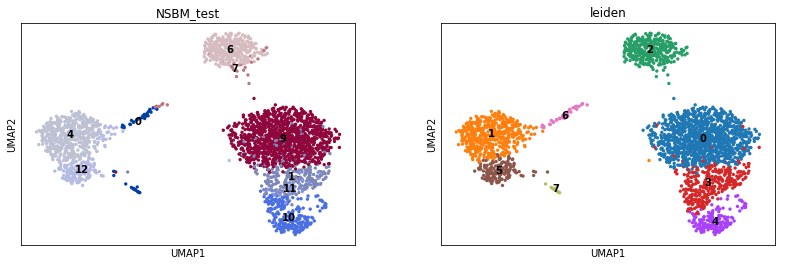

In [113]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [114]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_w1k_e001.pkl",'wb'),2)
pickle.dump(h,open("pbmc/pbmc_weighted_vs_normal/h_w1k_e001.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pbmc_weighted_vs_normal/pv_w1k_e001.pkl",'wb'),2)

In [115]:
e_state_w1k_e001=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_w1k_e001.pkl", "rb" ))
h_w1k_e001=pickle.load( open("pbmc/pbmc_weighted_vs_normal/h_w1k_e001.pkl", "rb" ))
pv_w1k_e001=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/pv_w1k_e001.pkl", "rb" ))

##### 2be) w=1000, nbreaks=2, epsilon=0.01 (252 sec (circa 4 minuti))

In [116]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=10, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [117]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)

a=time.time()
gt.mcmc_equilibrate(state, wait=1000,nbreaks=2, max_niter=10000,epsilon=0.01, mcmc_args=dict(niter=10),callback=collect_info, verbose=True)
b=time.time()
state

niter:     1  count:    1  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97635.313  ΔS:      154.127  moves:  7185 
niter:     2  count:    2  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97631.969  ΔS:     -3.34365  moves:  7140 
niter:     3  count:    3  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97656.087  ΔS:      24.1182  moves:  7199 
niter:     4  count:    4  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97588.828  ΔS:     -67.2590  moves:  7444 
niter:     5  count:    5  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97582.315  ΔS:     -6.51294  moves:  7232 
niter:     6  count:    6  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97589.653  ΔS:      7.33796  moves:  7117 
niter:     7  count:    7  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97617.710  ΔS:      28.0569  moves:  7209 
niter:     8  count:    8  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97590.591  ΔS:     -27.1193  moves:  7121 
niter:     9  count:    9  break

niter:    70  count:   70  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97436.215  ΔS:      28.3851  moves:  7056 
niter:    71  count:   71  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97459.070  ΔS:      22.8551  moves:  7171 
niter:    72  count:   72  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97422.247  ΔS:     -36.8229  moves:  7208 
niter:    73  count:   73  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97413.767  ΔS:     -8.48051  moves:  7208 
niter:    74  count:   74  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97424.661  ΔS:      10.8943  moves:  7176 
niter:    75  count:   75  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97412.409  ΔS:     -12.2521  moves:  7158 
niter:    76  count:   76  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97493.262  ΔS:      80.8530  moves:  7267 
niter:    77  count:   77  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97455.139  ΔS:     -38.1230  moves:  7249 
niter:    78  count:   78  break

niter:   138  count:  138  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97415.765  ΔS:     -67.7849  moves:  7100 
niter:   139  count:  139  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97411.561  ΔS:     -4.20405  moves:  7098 
niter:   140  count:  140  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97431.783  ΔS:      20.2223  moves:  6977 
niter:   141  count:  141  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97428.222  ΔS:     -3.56095  moves:  7013 
niter:   142  count:  142  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97395.799  ΔS:     -32.4239  moves:  7213 
niter:   143  count:  143  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97380.162  ΔS:     -15.6371  moves:  7081 
niter:   144  count:  144  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97391.634  ΔS:      11.4723  moves:  7072 
niter:   145  count:  145  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97379.583  ΔS:     -12.0507  moves:  7114 
niter:   146  count:  146  break

niter:   206  count:  206  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97441.912  ΔS:      14.4842  moves:  7074 
niter:   207  count:  207  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97411.736  ΔS:     -30.1761  moves:  7143 
niter:   208  count:  208  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97361.960  ΔS:     -49.7760  moves:  7156 
niter:   209  count:  209  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97419.624  ΔS:      57.6639  moves:  7112 
niter:   210  count:  210  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97340.005  ΔS:     -79.6187  moves:  7197 
niter:   211  count:  211  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97432.344  ΔS:      92.3393  moves:  7089 
niter:   212  count:  212  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97431.857  ΔS:    -0.487336  moves:  7052 
niter:   213  count:  213  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97441.895  ΔS:      10.0379  moves:  7121 
niter:   214  count:  214  break

niter:   274  count:  274  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97390.160  ΔS:     -39.3899  moves:  7156 
niter:   275  count:  275  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97425.917  ΔS:      35.7572  moves:  7188 
niter:   276  count:  276  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97396.591  ΔS:     -29.3258  moves:  7064 
niter:   277  count:  277  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97378.493  ΔS:     -18.0977  moves:  7128 
niter:   278  count:  278  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97451.153  ΔS:      72.6599  moves:  7021 
niter:   279  count:  279  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97452.501  ΔS:      1.34834  moves:  7090 
niter:   280  count:  280  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97419.048  ΔS:     -33.4539  moves:  7040 
niter:   281  count:  281  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97428.808  ΔS:      9.76037  moves:  7015 
niter:   282  count:  282  break

niter:   343  count:  343  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97442.187  ΔS:      37.9118  moves:  7206 
niter:   344  count:  344  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97416.222  ΔS:     -25.9649  moves:  7245 
niter:   345  count:  345  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97394.085  ΔS:     -22.1370  moves:  7310 
niter:   346  count:  346  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97349.582  ΔS:     -44.5034  moves:  7094 
niter:   347  count:  347  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97385.986  ΔS:      36.4037  moves:  7058 
niter:   348  count:  348  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97379.811  ΔS:     -6.17443  moves:  6937 
niter:   349  count:  349  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97403.918  ΔS:      24.1062  moves:  7109 
niter:   350  count:  350  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97414.202  ΔS:      10.2843  moves:  6968 
niter:   351  count:  351  break

niter:   411  count:  411  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97419.703  ΔS:     -33.1476  moves:  7085 
niter:   412  count:  412  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97415.781  ΔS:     -3.92255  moves:  7082 
niter:   413  count:  413  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97385.292  ΔS:     -30.4891  moves:  7120 
niter:   414  count:  414  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97419.723  ΔS:      34.4314  moves:  7043 
niter:   415  count:  415  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97367.417  ΔS:     -52.3061  moves:  7078 
niter:   416  count:  416  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97398.752  ΔS:      31.3355  moves:  7221 
niter:   417  count:  417  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97394.466  ΔS:     -4.28584  moves:  7167 
niter:   418  count:  418  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97369.229  ΔS:     -25.2379  moves:  7248 
niter:   419  count:  419  break

niter:   479  count:  479  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97418.349  ΔS:     -38.0285  moves:  6927 
niter:   480  count:  480  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97468.878  ΔS:      50.5290  moves:  6869 
niter:   481  count:  481  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97487.099  ΔS:      18.2209  moves:  7151 
niter:   482  count:  482  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97447.851  ΔS:     -39.2479  moves:  7033 
niter:   483  count:  483  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97418.856  ΔS:     -28.9950  moves:  7055 
niter:   484  count:  484  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97433.599  ΔS:      14.7426  moves:  7201 
niter:   485  count:  485  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97421.923  ΔS:     -11.6752  moves:  6948 
niter:   486  count:  486  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97458.634  ΔS:      36.7110  moves:  6960 
niter:   487  count:  487  break

niter:   547  count:  547  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97456.781  ΔS:     -1.95871  moves:  7043 
niter:   548  count:  548  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97447.960  ΔS:     -8.82066  moves:  7027 
niter:   549  count:  549  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97435.769  ΔS:     -12.1916  moves:  6947 
niter:   550  count:  550  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97396.563  ΔS:     -39.2057  moves:  6962 
niter:   551  count:  551  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97384.090  ΔS:     -12.4732  moves:  6907 
niter:   552  count:  552  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97382.847  ΔS:     -1.24332  moves:  6892 
niter:   553  count:  553  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97397.851  ΔS:      15.0046  moves:  6908 
niter:   554  count:  554  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97447.849  ΔS:      49.9981  moves:  6954 
niter:   555  count:  555  break

niter:   615  count:  615  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97472.178  ΔS:      4.00567  moves:  7052 
niter:   616  count:  616  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97474.772  ΔS:      2.59388  moves:  7140 
niter:   617  count:  617  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97389.932  ΔS:     -84.8402  moves:  6949 
niter:   618  count:  618  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97472.522  ΔS:      82.5905  moves:  7016 
niter:   619  count:  619  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97495.569  ΔS:      23.0471  moves:  6953 
niter:   620  count:  620  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97509.698  ΔS:      14.1286  moves:  6895 
niter:   621  count:  621  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97451.327  ΔS:     -58.3713  moves:  6976 
niter:   622  count:  622  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97436.955  ΔS:     -14.3718  moves:  6941 
niter:   623  count:  623  break

niter:   683  count:  683  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97375.949  ΔS:     -2.72674  moves:  7006 
niter:   684  count:  684  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97442.560  ΔS:      66.6117  moves:  7008 
niter:   685  count:  685  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97453.706  ΔS:      11.1459  moves:  6944 
niter:   686  count:  686  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97466.445  ΔS:      12.7388  moves:  7011 
niter:   687  count:  687  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97450.826  ΔS:     -15.6194  moves:  7001 
niter:   688  count:  688  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97499.313  ΔS:      48.4872  moves:  6963 
niter:   689  count:  689  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97464.587  ΔS:     -34.7258  moves:  6999 
niter:   690  count:  690  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97478.634  ΔS:      14.0475  moves:  7015 
niter:   691  count:  691  break

niter:   751  count:  751  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97410.350  ΔS:     -43.6749  moves:  6844 
niter:   752  count:  752  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97359.001  ΔS:     -51.3485  moves:  6897 
niter:   753  count:  753  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97408.168  ΔS:      49.1668  moves:  6913 
niter:   754  count:  754  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97351.423  ΔS:     -56.7452  moves:  6939 
niter:   755  count:  755  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97362.608  ΔS:      11.1846  moves:  6924 
niter:   756  count:  756  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97374.263  ΔS:      11.6558  moves:  6998 
niter:   757  count:  757  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97407.535  ΔS:      33.2719  moves:  6937 
niter:   758  count:  758  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97415.241  ΔS:      7.70558  moves:  6842 
niter:   759  count:  759  break

niter:   819  count:  819  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97413.996  ΔS:      48.6971  moves:  6845 
niter:   820  count:  820  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97344.884  ΔS:     -69.1111  moves:  6939 
niter:   821  count:  821  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97327.039  ΔS:     -17.8453  moves:  6912 
niter:   822  count:  822  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97360.711  ΔS:      33.6718  moves:  6890 
niter:   823  count:  823  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97382.630  ΔS:      21.9192  moves:  6850 
niter:   824  count:  824  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97365.777  ΔS:     -16.8528  moves:  6824 
niter:   825  count:  825  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97401.707  ΔS:      35.9301  moves:  6843 
niter:   826  count:  826  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97335.962  ΔS:     -65.7450  moves:  6868 
niter:   827  count:  827  break

niter:   887  count:  887  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97378.064  ΔS:     -44.3403  moves:  6919 
niter:   888  count:  888  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97406.154  ΔS:      28.0901  moves:  6890 
niter:   889  count:  889  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97399.431  ΔS:     -6.72243  moves:  6908 
niter:   890  count:  890  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97385.373  ΔS:     -14.0585  moves:  6763 
niter:   891  count:  891  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97413.342  ΔS:      27.9691  moves:  6881 
niter:   892  count:  892  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97374.197  ΔS:     -39.1453  moves:  6860 
niter:   893  count:  893  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97352.595  ΔS:     -21.6014  moves:  6833 
niter:   894  count:  894  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97342.531  ΔS:     -10.0641  moves:  6849 
niter:   895  count:  895  break

niter:   955  count:  955  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97388.664  ΔS:      44.9569  moves:  6798 
niter:   956  count:  956  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97369.776  ΔS:     -18.8876  moves:  6856 
niter:   957  count:  957  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97351.973  ΔS:     -17.8036  moves:  6768 
niter:   958  count:  958  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97342.861  ΔS:     -9.11210  moves:  6827 
niter:   959  count:  959  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97369.636  ΔS:      26.7757  moves:  6807 
niter:   960  count:  960  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97366.420  ΔS:     -3.21596  moves:  6988 
niter:   961  count:  961  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97369.244  ΔS:      2.82379  moves:  6921 
niter:   962  count:  962  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97360.494  ΔS:     -8.74976  moves:  6938 
niter:   963  count:  963  break

niter:  1023  count:   23  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97371.174  ΔS:     -12.5075  moves:  6731 
niter:  1024  count:   24  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97357.955  ΔS:     -13.2193  moves:  6703 
niter:  1025  count:   25  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97380.837  ΔS:      22.8817  moves:  6761 
niter:  1026  count:   26  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97429.264  ΔS:      48.4272  moves:  6813 
niter:  1027  count:   27  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97373.035  ΔS:     -56.2285  moves:  6855 
niter:  1028  count:   28  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97393.467  ΔS:      20.4320  moves:  6885 
niter:  1029  count:   29  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97379.688  ΔS:     -13.7788  moves:  6924 
niter:  1030  count:   30  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97367.614  ΔS:     -12.0742  moves:  6883 
niter:  1031  count:   31  break

niter:  1091  count:   91  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97334.970  ΔS:     -57.6576  moves:  6892 
niter:  1092  count:   92  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97336.545  ΔS:      1.57451  moves:  6915 
niter:  1093  count:   93  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97368.169  ΔS:      31.6245  moves:  7018 
niter:  1094  count:   94  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97362.473  ΔS:     -5.69562  moves:  6894 
niter:  1095  count:   95  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97378.355  ΔS:      15.8815  moves:  6756 
niter:  1096  count:   96  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97329.245  ΔS:     -49.1102  moves:  6877 
niter:  1097  count:   97  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97382.250  ΔS:      53.0054  moves:  6776 
niter:  1098  count:   98  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97389.305  ΔS:      7.05451  moves:  6889 
niter:  1099  count:   99  break

niter:  1159  count:  159  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97331.240  ΔS:     -80.4340  moves:  6797 
niter:  1160  count:  160  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97352.733  ΔS:      21.4923  moves:  6863 
niter:  1161  count:  161  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97370.869  ΔS:      18.1367  moves:  6899 
niter:  1162  count:  162  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97367.372  ΔS:     -3.49756  moves:  6828 
niter:  1163  count:  163  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97364.116  ΔS:     -3.25608  moves:  6962 
niter:  1164  count:  164  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97351.965  ΔS:     -12.1504  moves:  6888 
niter:  1165  count:  165  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97358.268  ΔS:      6.30305  moves:  6790 
niter:  1166  count:  166  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97322.856  ΔS:     -35.4127  moves:  6794 
niter:  1167  count:  167  break

niter:  1227  count:  227  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97402.098  ΔS:      24.6799  moves:  6695 
niter:  1228  count:  228  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97391.643  ΔS:     -10.4554  moves:  6800 
niter:  1229  count:  229  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97347.681  ΔS:     -43.9619  moves:  6728 
niter:  1230  count:  230  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97341.446  ΔS:     -6.23460  moves:  6920 
niter:  1231  count:  231  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97386.111  ΔS:      44.6642  moves:  6832 
niter:  1232  count:  232  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97349.072  ΔS:     -37.0382  moves:  6935 
niter:  1233  count:  233  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97365.820  ΔS:      16.7472  moves:  6785 
niter:  1234  count:  234  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97324.658  ΔS:     -41.1620  moves:  6721 
niter:  1235  count:  235  break

niter:  1295  count:  295  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97373.077  ΔS:      44.6157  moves:  6866 
niter:  1296  count:  296  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97315.524  ΔS:     -57.5522  moves:  6787 
niter:  1297  count:  297  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97330.527  ΔS:      15.0029  moves:  6846 
niter:  1298  count:  298  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97311.003  ΔS:     -19.5243  moves:  6761 
niter:  1299  count:  299  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97384.030  ΔS:      73.0275  moves:  6751 
niter:  1300  count:  300  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97334.125  ΔS:     -49.9050  moves:  6852 
niter:  1301  count:  301  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97343.821  ΔS:      9.69536  moves:  6813 
niter:  1302  count:  302  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97360.581  ΔS:      16.7605  moves:  6927 
niter:  1303  count:  303  break

niter:  1363  count:  363  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97314.559  ΔS:     -30.3581  moves:  6777 
niter:  1364  count:  364  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97275.392  ΔS:     -39.1668  moves:  6752 
niter:  1365  count:  365  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97324.475  ΔS:      49.0826  moves:  6721 
niter:  1366  count:  366  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97323.197  ΔS:     -1.27848  moves:  6843 
niter:  1367  count:  367  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97294.872  ΔS:     -28.3250  moves:  6697 
niter:  1368  count:  368  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97338.197  ΔS:      43.3256  moves:  6798 
niter:  1369  count:  369  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97283.793  ΔS:     -54.4042  moves:  6610 
niter:  1370  count:  370  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97341.613  ΔS:      57.8196  moves:  6782 
niter:  1371  count:  371  break

niter:  1431  count:  431  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97338.525  ΔS:     -69.7538  moves:  6785 
niter:  1432  count:  432  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97353.792  ΔS:      15.2671  moves:  6933 
niter:  1433  count:  433  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97305.313  ΔS:     -48.4787  moves:  6764 
niter:  1434  count:  434  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97323.725  ΔS:      18.4121  moves:  6689 
niter:  1435  count:  435  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97329.586  ΔS:      5.86072  moves:  6672 
niter:  1436  count:  436  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97387.833  ΔS:      58.2471  moves:  6835 
niter:  1437  count:  437  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97336.973  ΔS:     -50.8604  moves:  6900 
niter:  1438  count:  438  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97355.820  ΔS:      18.8472  moves:  6708 
niter:  1439  count:  439  break

niter:  1499  count:  499  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97266.762  ΔS:     -82.7299  moves:  6819 
niter:  1500  count:  500  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97303.437  ΔS:      36.6752  moves:  6972 
niter:  1501  count:  501  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97340.280  ΔS:      36.8434  moves:  6945 
niter:  1502  count:  502  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97348.904  ΔS:      8.62312  moves:  6754 
niter:  1503  count:  503  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97340.256  ΔS:     -8.64727  moves:  6823 
niter:  1504  count:  504  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97332.901  ΔS:     -7.35573  moves:  6716 
niter:  1505  count:  505  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97318.414  ΔS:     -14.4866  moves:  6765 
niter:  1506  count:  506  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97315.280  ΔS:     -3.13378  moves:  6797 
niter:  1507  count:  507  break

niter:  1567  count:  567  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97305.617  ΔS:     -57.1357  moves:  6828 
niter:  1568  count:  568  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97363.595  ΔS:      57.9780  moves:  6711 
niter:  1569  count:  569  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97328.210  ΔS:     -35.3846  moves:  6901 
niter:  1570  count:  570  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97392.770  ΔS:      64.5596  moves:  6894 
niter:  1571  count:  571  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97382.836  ΔS:     -9.93358  moves:  6908 
niter:  1572  count:  572  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97330.116  ΔS:     -52.7204  moves:  6740 
niter:  1573  count:  573  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97352.146  ΔS:      22.0300  moves:  6790 
niter:  1574  count:  574  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97376.157  ΔS:      24.0109  moves:  6719 
niter:  1575  count:  575  break

niter:  1636  count:  636  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97364.867  ΔS:      54.9835  moves:  6765 
niter:  1637  count:  637  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97343.428  ΔS:     -21.4389  moves:  6743 
niter:  1638  count:  638  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97346.220  ΔS:      2.79175  moves:  6666 
niter:  1639  count:  639  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97347.509  ΔS:      1.28912  moves:  6801 
niter:  1640  count:  640  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97346.961  ΔS:    -0.547746  moves:  6764 
niter:  1641  count:  641  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97312.391  ΔS:     -34.5703  moves:  6883 
niter:  1642  count:  642  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97325.209  ΔS:      12.8181  moves:  6695 
niter:  1643  count:  643  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97373.765  ΔS:      48.5557  moves:  6696 
niter:  1644  count:  644  break

niter:  1704  count:  704  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97368.459  ΔS:      2.49919  moves:  6858 
niter:  1705  count:  705  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97438.113  ΔS:      69.6550  moves:  6870 
niter:  1706  count:  706  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97440.964  ΔS:      2.85059  moves:  6940 
niter:  1707  count:  707  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97299.391  ΔS:     -141.573  moves:  6908 
niter:  1708  count:  708  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97383.553  ΔS:      84.1622  moves:  6843 
niter:  1709  count:  709  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97387.447  ΔS:      3.89419  moves:  6804 
niter:  1710  count:  710  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97369.021  ΔS:     -18.4262  moves:  6730 
niter:  1711  count:  711  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97340.369  ΔS:     -28.6516  moves:  6784 
niter:  1712  count:  712  break

niter:  1772  count:  772  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97340.481  ΔS:      5.58440  moves:  6851 
niter:  1773  count:  773  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97287.398  ΔS:     -53.0830  moves:  6919 
niter:  1774  count:  774  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97336.573  ΔS:      49.1742  moves:  6904 
niter:  1775  count:  775  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97336.732  ΔS:     0.159131  moves:  6940 
niter:  1776  count:  776  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97328.477  ΔS:     -8.25440  moves:  6899 
niter:  1777  count:  777  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97316.874  ΔS:     -11.6038  moves:  6933 
niter:  1778  count:  778  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97358.719  ΔS:      41.8451  moves:  6878 
niter:  1779  count:  779  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97320.062  ΔS:     -38.6564  moves:  6848 
niter:  1780  count:  780  break

niter:  1840  count:  840  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97261.551  ΔS:     -2.27525  moves:  6703 
niter:  1841  count:  841  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97291.686  ΔS:      30.1355  moves:  6732 
niter:  1842  count:  842  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97295.371  ΔS:      3.68540  moves:  6765 
niter:  1843  count:  843  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97278.950  ΔS:     -16.4219  moves:  6850 
niter:  1844  count:  844  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97258.635  ΔS:     -20.3146  moves:  6822 
niter:  1845  count:  845  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97300.170  ΔS:      41.5349  moves:  6860 
niter:  1846  count:  846  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97335.612  ΔS:      35.4423  moves:  6780 
niter:  1847  count:  847  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97386.531  ΔS:      50.9185  moves:  6728 
niter:  1848  count:  848  break

niter:  1908  count:  908  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97333.650  ΔS:     -37.0526  moves:  6841 
niter:  1909  count:  909  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97349.407  ΔS:      15.7569  moves:  7053 
niter:  1910  count:  910  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97348.998  ΔS:    -0.409136  moves:  6982 
niter:  1911  count:  911  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97402.666  ΔS:      53.6681  moves:  6958 
niter:  1912  count:  912  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97384.407  ΔS:     -18.2593  moves:  6848 
niter:  1913  count:  913  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97367.604  ΔS:     -16.8022  moves:  6919 
niter:  1914  count:  914  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97304.368  ΔS:     -63.2363  moves:  6938 
niter:  1915  count:  915  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97338.345  ΔS:      33.9772  moves:  6939 
niter:  1916  count:  916  break

niter:  1977  count:  977  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97362.887  ΔS:      23.4129  moves:  6923 
niter:  1978  count:  978  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97358.325  ΔS:     -4.56238  moves:  6922 
niter:  1979  count:  979  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97342.788  ΔS:     -15.5366  moves:  6944 
niter:  1980  count:  980  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97376.289  ΔS:      33.5012  moves:  6869 
niter:  1981  count:  981  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97312.407  ΔS:     -63.8819  moves:  6932 
niter:  1982  count:  982  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97344.030  ΔS:      31.6227  moves:  6820 
niter:  1983  count:  983  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97344.980  ΔS:     0.950263  moves:  6831 
niter:  1984  count:  984  breaks:  1  min_S: 97351.633  max_S: 97351.633  S: 97371.736  ΔS:      26.7558  moves:  6862 
niter:  1985  count:  985  break

<NestedBlockState object, with base <BlockState object with 58 blocks (55 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ff7f415e7d0>, at 0x7ff8052933d0>, and 10 levels of sizes [(2638, 55), (55, 17), (17, 8), (8, 5), (5, 5), (5, 4), (4, 4), (4, 4), (4, 4), (4, 2)] at 0x7ff805293410>

In [118]:
c=b-a
c

252.4527292251587

leiden        0    1    2    3    4    5   6   7
NSBM_test                                       
0             0   29    0    0    0  124   0   0
2             0    0  340    0    0    0   0   0
5          1115    0    1   25    0    1   0   0
6             0    0    0    0    0    2  27  13
7             0    0    0   57  162    0   0   0
8             0  457    0    0    0   22   0   0
11           28    0    0  224    1    1   0   0
12            0    0    0    0    0    0   9   0


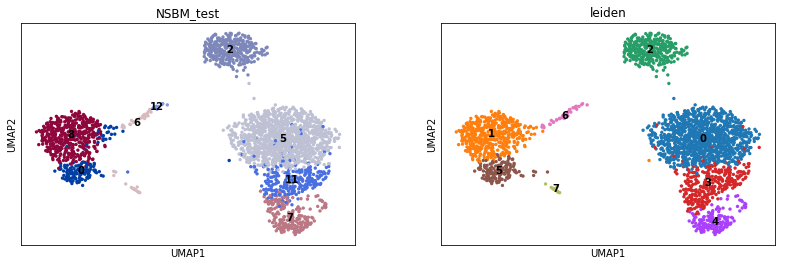

In [119]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [120]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_w1k_e01.pkl",'wb'),2)
pickle.dump(h,open("pbmc/pbmc_weighted_vs_normal/h_w1k_e01.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pbmc_weighted_vs_normal/pv_w1k_e01.pkl",'wb'),2)

In [121]:
e_state_w1k_e01=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_w1k_e01.pkl", "rb" ))
h_w1k_e01=pickle.load( open("pbmc/pbmc_weighted_vs_normal/h_w1k_e01.pkl", "rb" ))
pv_w1k_e01=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/pv_w1k_e01.pkl", "rb" ))

##### 2bf) w=1000, nbreaks=3, epsilon=0.001 (1003 secondi(circa 17 min))

In [122]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=10, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [123]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)

a=time.time()
gt.mcmc_equilibrate(state, wait=1000,nbreaks=3, max_niter=10000,epsilon=0.001, mcmc_args=dict(niter=10),callback=collect_info, verbose=True)
b=time.time()
state

niter:     1  count:    0  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97659.441  ΔS:      178.255  moves:  7366 
niter:     2  count:    1  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97645.883  ΔS:     -13.5582  moves:  7222 
niter:     3  count:    2  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97684.335  ΔS:      38.4517  moves:  7301 
niter:     4  count:    3  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97675.699  ΔS:     -8.63543  moves:  7264 
niter:     5  count:    4  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97624.335  ΔS:     -51.3646  moves:  7389 
niter:     6  count:    5  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97597.468  ΔS:     -26.8669  moves:  7268 
niter:     7  count:    6  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97529.994  ΔS:     -67.4733  moves:  7277 
niter:     8  count:    7  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97494.990  ΔS:     -35.0047  moves:  7219 
niter:     9  count:    8  break

niter:    70  count:   69  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97410.512  ΔS:     -11.3359  moves:  7207 
niter:    71  count:   70  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97456.798  ΔS:      46.2860  moves:  7070 
niter:    72  count:   71  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97470.098  ΔS:      13.3000  moves:  7116 
niter:    73  count:   72  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97455.676  ΔS:     -14.4226  moves:  7070 
niter:    74  count:   73  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97441.334  ΔS:     -14.3423  moves:  7157 
niter:    75  count:   74  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97399.653  ΔS:     -41.6805  moves:  7094 
niter:    76  count:   75  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97468.951  ΔS:      69.2978  moves:  7164 
niter:    77  count:   76  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97475.344  ΔS:      6.39326  moves:  7081 
niter:    78  count:   77  break

niter:   138  count:  137  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97409.892  ΔS:     -33.5963  moves:  7191 
niter:   139  count:  138  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97383.761  ΔS:     -26.1305  moves:  7116 
niter:   140  count:  139  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97465.212  ΔS:      81.4507  moves:  7151 
niter:   141  count:  140  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97461.942  ΔS:     -3.26990  moves:  7180 
niter:   142  count:  141  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97481.281  ΔS:      19.3390  moves:  7130 
niter:   143  count:  142  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97509.924  ΔS:      28.6429  moves:  7144 
niter:   144  count:  143  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97498.235  ΔS:     -11.6890  moves:  7148 
niter:   145  count:  144  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97482.354  ΔS:     -15.8805  moves:  7087 
niter:   146  count:  145  break

niter:   206  count:  205  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97440.391  ΔS:     -47.0205  moves:  7013 
niter:   207  count:  206  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97456.042  ΔS:      15.6507  moves:  6949 
niter:   208  count:  207  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97432.748  ΔS:     -23.2937  moves:  7180 
niter:   209  count:  208  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97491.254  ΔS:      58.5056  moves:  7033 
niter:   210  count:  209  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97444.720  ΔS:     -46.5341  moves:  7035 
niter:   211  count:  210  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97419.319  ΔS:     -25.4010  moves:  7056 
niter:   212  count:  211  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97374.548  ΔS:     -44.7707  moves:  6901 
niter:   213  count:  212  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97435.718  ΔS:      61.1699  moves:  6928 
niter:   214  count:  213  break

niter:   274  count:  273  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97388.233  ΔS:      2.64957  moves:  7090 
niter:   275  count:  274  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97418.230  ΔS:      29.9970  moves:  7183 
niter:   276  count:  275  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97465.867  ΔS:      47.6364  moves:  7042 
niter:   277  count:  276  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97485.145  ΔS:      19.2782  moves:  7084 
niter:   278  count:  277  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97425.926  ΔS:     -59.2193  moves:  6964 
niter:   279  count:  278  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97500.903  ΔS:      74.9770  moves:  7042 
niter:   280  count:  279  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97429.448  ΔS:     -71.4550  moves:  7140 
niter:   281  count:  280  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97455.589  ΔS:      26.1415  moves:  7020 
niter:   282  count:  281  break

niter:   342  count:  341  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97356.421  ΔS:     -67.3111  moves:  7022 
niter:   343  count:  342  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97377.285  ΔS:      20.8645  moves:  6990 
niter:   344  count:  343  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97440.947  ΔS:      63.6620  moves:  7077 
niter:   345  count:  344  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97387.601  ΔS:     -53.3462  moves:  7126 
niter:   346  count:  345  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97414.064  ΔS:      26.4631  moves:  7157 
niter:   347  count:  346  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97411.450  ΔS:     -2.61430  moves:  7005 
niter:   348  count:  347  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97422.415  ΔS:      10.9650  moves:  7127 
niter:   349  count:  348  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97348.428  ΔS:     -73.9871  moves:  6994 
niter:   350  count:  349  break

niter:   410  count:  409  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97424.624  ΔS:     -11.7597  moves:  6995 
niter:   411  count:  410  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97446.653  ΔS:      22.0292  moves:  6970 
niter:   412  count:  411  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97412.728  ΔS:     -33.9253  moves:  7042 
niter:   413  count:  412  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97461.742  ΔS:      49.0139  moves:  7027 
niter:   414  count:  413  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97418.085  ΔS:     -43.6568  moves:  7095 
niter:   415  count:  414  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97408.451  ΔS:     -9.63434  moves:  7046 
niter:   416  count:  415  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97436.112  ΔS:      27.6611  moves:  7039 
niter:   417  count:  416  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97400.039  ΔS:     -36.0726  moves:  7061 
niter:   418  count:  417  break

niter:   478  count:  477  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97426.305  ΔS:     -26.1243  moves:  7077 
niter:   479  count:  478  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97426.665  ΔS:     0.359714  moves:  6991 
niter:   480  count:  479  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97466.517  ΔS:      39.8520  moves:  7077 
niter:   481  count:  480  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97478.659  ΔS:      12.1425  moves:  7068 
niter:   482  count:  481  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97396.191  ΔS:     -82.4682  moves:  7010 
niter:   483  count:  482  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97422.101  ΔS:      25.9094  moves:  7012 
niter:   484  count:  483  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97418.165  ΔS:     -3.93536  moves:  6991 
niter:   485  count:  484  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97432.056  ΔS:      13.8912  moves:  6932 
niter:   486  count:  485  break

niter:   546  count:  545  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97419.681  ΔS:     -70.6351  moves:  7042 
niter:   547  count:  546  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97429.597  ΔS:      9.91600  moves:  7079 
niter:   548  count:  547  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97482.637  ΔS:      53.0399  moves:  7105 
niter:   549  count:  548  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97404.267  ΔS:     -78.3705  moves:  7027 
niter:   550  count:  549  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97441.878  ΔS:      37.6115  moves:  7021 
niter:   551  count:  550  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97421.156  ΔS:     -20.7217  moves:  7094 
niter:   552  count:  551  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97409.084  ΔS:     -12.0721  moves:  7099 
niter:   553  count:  552  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97390.156  ΔS:     -18.9286  moves:  7125 
niter:   554  count:  553  break

niter:   614  count:  613  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97412.369  ΔS:      10.6926  moves:  7070 
niter:   615  count:  614  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97427.325  ΔS:      14.9558  moves:  7006 
niter:   616  count:  615  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97434.259  ΔS:      6.93424  moves:  7131 
niter:   617  count:  616  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97398.245  ΔS:     -36.0145  moves:  7047 
niter:   618  count:  617  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97380.582  ΔS:     -17.6634  moves:  7060 
niter:   619  count:  618  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97437.378  ΔS:      56.7960  moves:  7034 
niter:   620  count:  619  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97391.383  ΔS:     -45.9943  moves:  7003 
niter:   621  count:  620  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97411.198  ΔS:      19.8144  moves:  7045 
niter:   622  count:  621  break

niter:   682  count:  681  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97397.683  ΔS:     -53.8009  moves:  7099 
niter:   683  count:  682  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97423.696  ΔS:      26.0137  moves:  7221 
niter:   684  count:  683  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97432.906  ΔS:      9.20974  moves:  7131 
niter:   685  count:  684  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97389.553  ΔS:     -43.3534  moves:  7010 
niter:   686  count:  685  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97397.518  ΔS:      7.96490  moves:  7110 
niter:   687  count:  686  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97453.243  ΔS:      55.7259  moves:  7232 
niter:   688  count:  687  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97431.755  ΔS:     -21.4889  moves:  7091 
niter:   689  count:  688  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97432.280  ΔS:     0.525313  moves:  7212 
niter:   690  count:  689  break

niter:   750  count:  749  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97444.568  ΔS:     -5.31462  moves:  7037 
niter:   751  count:  750  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97402.005  ΔS:     -42.5628  moves:  7085 
niter:   752  count:  751  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97352.507  ΔS:     -49.4983  moves:  7086 
niter:   753  count:  752  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97349.110  ΔS:     -3.39654  moves:  7048 
niter:   754  count:  753  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97425.731  ΔS:      76.6209  moves:  6995 
niter:   755  count:  754  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97377.130  ΔS:     -48.6010  moves:  7049 
niter:   756  count:  755  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97391.492  ΔS:      14.3615  moves:  7033 
niter:   757  count:  756  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97385.913  ΔS:     -5.57842  moves:  7081 
niter:   758  count:  757  break

niter:   818  count:  817  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97358.170  ΔS:     -3.09514  moves:  7164 
niter:   819  count:  818  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97362.769  ΔS:      4.59893  moves:  7348 
niter:   820  count:  819  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97392.634  ΔS:      29.8653  moves:  7131 
niter:   821  count:  820  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97329.260  ΔS:     -63.3744  moves:  7212 
niter:   822  count:  821  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97347.475  ΔS:      18.2154  moves:  7309 
niter:   823  count:  822  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97395.046  ΔS:      47.5705  moves:  7087 
niter:   824  count:  823  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97339.778  ΔS:     -55.2683  moves:  7206 
niter:   825  count:  824  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97355.419  ΔS:      15.6419  moves:  7123 
niter:   826  count:  825  break

niter:   886  count:  885  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97382.948  ΔS:      13.2996  moves:  7082 
niter:   887  count:  886  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97398.609  ΔS:      15.6605  moves:  7155 
niter:   888  count:  887  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97415.882  ΔS:      17.2731  moves:  7073 
niter:   889  count:  888  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97450.158  ΔS:      34.2761  moves:  7074 
niter:   890  count:  889  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97428.638  ΔS:     -21.5198  moves:  7127 
niter:   891  count:  890  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97431.873  ΔS:      3.23540  moves:  7072 
niter:   892  count:  891  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97413.719  ΔS:     -18.1550  moves:  7053 
niter:   893  count:  892  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97437.230  ΔS:      23.5113  moves:  7194 
niter:   894  count:  893  break

niter:   954  count:  953  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97331.165  ΔS:      36.0851  moves:  7237 
niter:   955  count:  954  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97338.643  ΔS:      7.47784  moves:  7198 
niter:   956  count:  955  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97345.387  ΔS:      6.74466  moves:  7186 
niter:   957  count:  956  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97325.096  ΔS:     -20.2915  moves:  7179 
niter:   958  count:  957  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97349.494  ΔS:      24.3977  moves:  7171 
niter:   959  count:  958  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97345.021  ΔS:     -4.47296  moves:  7278 
niter:   960  count:  959  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97315.011  ΔS:     -30.0096  moves:  7206 
niter:   961  count:  960  breaks:  0  min_S: 97481.186  max_S: 97659.441  S: 97323.917  ΔS:      8.90589  moves:  7297 
niter:   962  count:  961  break

niter:  1022  count:   54  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97344.617  ΔS:     -10.5784  moves:  7281 
niter:  1023  count:   55  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97383.436  ΔS:      38.8191  moves:  7214 
niter:  1024  count:   56  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97424.307  ΔS:      40.8711  moves:  7160 
niter:  1025  count:   57  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97362.047  ΔS:     -62.2606  moves:  7323 
niter:  1026  count:   58  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97362.478  ΔS:     0.430821  moves:  7149 
niter:  1027  count:   59  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97349.475  ΔS:     -13.0031  moves:  7249 
niter:  1028  count:   60  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97421.015  ΔS:      71.5401  moves:  7108 
niter:  1029  count:   61  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97372.437  ΔS:     -48.5778  moves:  7191 
niter:  1030  count:   62  break

niter:  1090  count:  122  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97388.171  ΔS:      22.7443  moves:  7210 
niter:  1091  count:  123  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97381.154  ΔS:     -7.01748  moves:  7143 
niter:  1092  count:  124  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97391.053  ΔS:      9.89951  moves:  7254 
niter:  1093  count:  125  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97335.638  ΔS:     -55.4152  moves:  7306 
niter:  1094  count:  126  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97315.010  ΔS:     -20.6284  moves:  7199 
niter:  1095  count:  127  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97356.106  ΔS:      41.0958  moves:  7269 
niter:  1096  count:  128  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97304.250  ΔS:     -51.8555  moves:  7254 
niter:  1097  count:  129  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97356.696  ΔS:      52.4462  moves:  7417 
niter:  1098  count:  130  break

niter:  1158  count:  190  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97343.444  ΔS:      77.3037  moves:  7119 
niter:  1159  count:  191  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97379.182  ΔS:      35.7380  moves:  7124 
niter:  1160  count:  192  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97361.154  ΔS:     -18.0273  moves:  7129 
niter:  1161  count:  193  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97330.382  ΔS:     -30.7723  moves:  7091 
niter:  1162  count:  194  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97339.772  ΔS:      9.39041  moves:  7167 
niter:  1163  count:  195  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97322.811  ΔS:     -16.9615  moves:  7098 
niter:  1164  count:  196  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97360.877  ΔS:      38.0660  moves:  7118 
niter:  1165  count:  197  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97333.947  ΔS:     -26.9302  moves:  7090 
niter:  1166  count:  198  break

niter:  1226  count:  258  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97405.004  ΔS:      12.7599  moves:  7099 
niter:  1227  count:  259  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97408.609  ΔS:      3.60475  moves:  7121 
niter:  1228  count:  260  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97378.012  ΔS:     -30.5970  moves:  7214 
niter:  1229  count:  261  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97395.921  ΔS:      17.9085  moves:  7176 
niter:  1230  count:  262  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97369.871  ΔS:     -26.0497  moves:  7175 
niter:  1231  count:  263  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97302.881  ΔS:     -66.9901  moves:  7122 
niter:  1232  count:  264  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97381.139  ΔS:      78.2579  moves:  7001 
niter:  1233  count:  265  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97410.057  ΔS:      28.9186  moves:  7073 
niter:  1234  count:  266  break

niter:  1294  count:  326  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97354.449  ΔS:      1.56586  moves:  7320 
niter:  1295  count:  327  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97384.972  ΔS:      30.5237  moves:  7152 
niter:  1296  count:  328  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97371.938  ΔS:     -13.0339  moves:  7216 
niter:  1297  count:  329  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97432.193  ΔS:      60.2547  moves:  7120 
niter:  1298  count:  330  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97396.720  ΔS:     -35.4730  moves:  7052 
niter:  1299  count:  331  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97405.357  ΔS:      8.63679  moves:  7149 
niter:  1300  count:  332  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97354.984  ΔS:     -50.3727  moves:  7288 
niter:  1301  count:  333  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97393.803  ΔS:      38.8191  moves:  7154 
niter:  1302  count:  334  break

niter:  1362  count:  394  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97371.043  ΔS:      11.0421  moves:  7216 
niter:  1363  count:  395  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97345.107  ΔS:     -25.9361  moves:  7286 
niter:  1364  count:  396  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97370.274  ΔS:      25.1664  moves:  7191 
niter:  1365  count:  397  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97476.096  ΔS:      105.822  moves:  7001 
niter:  1366  count:  398  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97461.587  ΔS:     -14.5089  moves:  7144 
niter:  1367  count:  399  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97429.779  ΔS:     -31.8083  moves:  7063 
niter:  1368  count:  400  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97376.528  ΔS:     -53.2512  moves:  7049 
niter:  1369  count:  401  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97380.730  ΔS:      4.20182  moves:  7080 
niter:  1370  count:  402  break

niter:  1430  count:  462  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97456.319  ΔS:      105.178  moves:  6947 
niter:  1431  count:  463  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97370.031  ΔS:     -86.2880  moves:  7324 
niter:  1432  count:  464  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97339.027  ΔS:     -31.0043  moves:  7202 
niter:  1433  count:  465  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97321.271  ΔS:     -17.7562  moves:  7242 
niter:  1434  count:  466  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97355.222  ΔS:      33.9517  moves:  7083 
niter:  1435  count:  467  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97324.066  ΔS:     -31.1568  moves:  7039 
niter:  1436  count:  468  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97327.236  ΔS:      3.17030  moves:  7083 
niter:  1437  count:  469  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97362.923  ΔS:      35.6870  moves:  7184 
niter:  1438  count:  470  break

niter:  1498  count:  530  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97355.318  ΔS:      13.5131  moves:  7040 
niter:  1499  count:  531  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97421.317  ΔS:      65.9987  moves:  7118 
niter:  1500  count:  532  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97411.328  ΔS:     -9.98918  moves:  7165 
niter:  1501  count:  533  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97472.198  ΔS:      60.8704  moves:  7216 
niter:  1502  count:  534  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97451.069  ΔS:     -21.1296  moves:  7096 
niter:  1503  count:  535  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97434.343  ΔS:     -16.7251  moves:  7026 
niter:  1504  count:  536  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97419.498  ΔS:     -14.8452  moves:  7036 
niter:  1505  count:  537  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97411.908  ΔS:     -7.58992  moves:  7096 
niter:  1506  count:  538  break

niter:  1566  count:  598  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97277.580  ΔS:     -15.9909  moves:  7104 
niter:  1567  count:  599  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97271.458  ΔS:     -6.12187  moves:  7065 
niter:  1568  count:  600  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97291.590  ΔS:      20.1316  moves:  7094 
niter:  1569  count:  601  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97282.210  ΔS:     -9.38008  moves:  7038 
niter:  1570  count:  602  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97349.223  ΔS:      67.0135  moves:  7127 
niter:  1571  count:  603  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97340.644  ΔS:     -8.57887  moves:  7128 
niter:  1572  count:  604  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97320.355  ΔS:     -20.2893  moves:  6992 
niter:  1573  count:  605  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97337.115  ΔS:      16.7602  moves:  7105 
niter:  1574  count:  606  break

niter:  1634  count:  666  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97279.714  ΔS:     -39.7040  moves:  6892 
niter:  1635  count:  667  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97294.559  ΔS:      14.8451  moves:  6967 
niter:  1636  count:  668  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97357.128  ΔS:      62.5683  moves:  7117 
niter:  1637  count:  669  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97335.484  ΔS:     -21.6432  moves:  7102 
niter:  1638  count:  670  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97306.772  ΔS:     -28.7122  moves:  7026 
niter:  1639  count:  671  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97297.581  ΔS:     -9.19150  moves:  7026 
niter:  1640  count:  672  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97349.479  ΔS:      51.8988  moves:  7049 
niter:  1641  count:  673  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97371.084  ΔS:      21.6046  moves:  6985 
niter:  1642  count:  674  break

niter:  1702  count:  734  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97351.662  ΔS:      74.9351  moves:  6900 
niter:  1703  count:  735  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97306.225  ΔS:     -45.4365  moves:  6883 
niter:  1704  count:  736  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97347.851  ΔS:      41.6253  moves:  6867 
niter:  1705  count:  737  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97342.112  ΔS:     -5.73820  moves:  6958 
niter:  1706  count:  738  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97334.184  ΔS:     -7.92840  moves:  7053 
niter:  1707  count:  739  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97297.894  ΔS:     -36.2900  moves:  6939 
niter:  1708  count:  740  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97327.711  ΔS:      29.8170  moves:  6964 
niter:  1709  count:  741  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97365.330  ΔS:      37.6195  moves:  7038 
niter:  1710  count:  742  break

niter:  1770  count:  802  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97349.620  ΔS:     -41.0266  moves:  6845 
niter:  1771  count:  803  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97368.740  ΔS:      19.1196  moves:  6900 
niter:  1772  count:  804  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97381.272  ΔS:      12.5323  moves:  6960 
niter:  1773  count:  805  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97370.406  ΔS:     -10.8661  moves:  6874 
niter:  1774  count:  806  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97361.606  ΔS:     -8.79966  moves:  6986 
niter:  1775  count:  807  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97368.709  ΔS:      7.10208  moves:  7010 
niter:  1776  count:  808  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97370.047  ΔS:      1.33892  moves:  7048 
niter:  1777  count:  809  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97367.939  ΔS:     -2.10821  moves:  7036 
niter:  1778  count:  810  break

niter:  1838  count:  870  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97376.617  ΔS:     -5.23651  moves:  6890 
niter:  1839  count:  871  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97368.931  ΔS:     -7.68608  moves:  6885 
niter:  1840  count:  872  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97369.128  ΔS:     0.197160  moves:  6920 
niter:  1841  count:  873  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97425.952  ΔS:      56.8240  moves:  6864 
niter:  1842  count:  874  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97422.520  ΔS:     -3.43266  moves:  6873 
niter:  1843  count:  875  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97415.326  ΔS:     -7.19362  moves:  6879 
niter:  1844  count:  876  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97384.812  ΔS:     -30.5140  moves:  7004 
niter:  1845  count:  877  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97329.042  ΔS:     -55.7696  moves:  6861 
niter:  1846  count:  878  break

niter:  1906  count:  938  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97358.219  ΔS:     -4.78973  moves:  7065 
niter:  1907  count:  939  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97356.745  ΔS:     -1.47322  moves:  7045 
niter:  1908  count:  940  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97362.601  ΔS:      5.85522  moves:  7097 
niter:  1909  count:  941  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97380.500  ΔS:      17.8994  moves:  6933 
niter:  1910  count:  942  breaks:  0  min_S: 97312.843  max_S: 97659.441  S: 97397.443  ΔS:      16.9426  moves:  6894 
niter:  1911  count:    0  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97293.985  ΔS:     -103.457  moves:  7036 
niter:  1912  count:    1  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97311.791  ΔS:      17.8054  moves:  6886 
niter:  1913  count:    2  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97384.742  ΔS:      72.9517  moves:  7023 
niter:  1914  count:    3  break

niter:  1974  count:   63  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97346.593  ΔS:      27.0466  moves:  6996 
niter:  1975  count:   64  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97364.027  ΔS:      17.4343  moves:  7003 
niter:  1976  count:   65  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97363.423  ΔS:    -0.603829  moves:  6979 
niter:  1977  count:   66  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97402.411  ΔS:      38.9879  moves:  6949 
niter:  1978  count:   67  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97392.057  ΔS:     -10.3541  moves:  6970 
niter:  1979  count:   68  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97361.867  ΔS:     -30.1896  moves:  7059 
niter:  1980  count:   69  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97344.926  ΔS:     -16.9412  moves:  7105 
niter:  1981  count:   70  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97337.651  ΔS:     -7.27516  moves:  6913 
niter:  1982  count:   71  break

niter:  2042  count:  131  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97388.543  ΔS:      28.6057  moves:  7126 
niter:  2043  count:  132  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97349.112  ΔS:     -39.4301  moves:  7066 
niter:  2044  count:  133  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97345.856  ΔS:     -3.25696  moves:  7070 
niter:  2045  count:  134  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97392.249  ΔS:      46.3930  moves:  7077 
niter:  2046  count:  135  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97354.213  ΔS:     -38.0358  moves:  7088 
niter:  2047  count:  136  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97346.835  ΔS:     -7.37805  moves:  6937 
niter:  2048  count:  137  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97371.054  ΔS:      24.2188  moves:  6982 
niter:  2049  count:  138  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97289.412  ΔS:     -81.6416  moves:  7034 
niter:  2050  count:  139  break

niter:  2110  count:  199  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97353.225  ΔS:      12.0378  moves:  6898 
niter:  2111  count:  200  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97341.603  ΔS:     -11.6221  moves:  6989 
niter:  2112  count:  201  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97358.465  ΔS:      16.8618  moves:  7136 
niter:  2113  count:  202  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97288.504  ΔS:     -69.9606  moves:  7054 
niter:  2114  count:  203  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97340.498  ΔS:      51.9938  moves:  7005 
niter:  2115  count:  204  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97309.577  ΔS:     -30.9212  moves:  6929 
niter:  2116  count:  205  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97425.164  ΔS:      115.587  moves:  7004 
niter:  2117  count:  206  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97420.994  ΔS:     -4.17060  moves:  6989 
niter:  2118  count:  207  break

niter:  2178  count:  267  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97344.792  ΔS:     -30.7031  moves:  6981 
niter:  2179  count:  268  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97389.033  ΔS:      44.2413  moves:  6906 
niter:  2180  count:  269  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97419.931  ΔS:      30.8980  moves:  6943 
niter:  2181  count:  270  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97376.023  ΔS:     -43.9088  moves:  6906 
niter:  2182  count:  271  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97391.384  ΔS:      15.3612  moves:  6965 
niter:  2183  count:  272  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97371.081  ΔS:     -20.3024  moves:  7044 
niter:  2184  count:  273  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97376.106  ΔS:      5.02442  moves:  6991 
niter:  2185  count:  274  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97282.480  ΔS:     -93.6256  moves:  7150 
niter:  2186  count:  275  break

niter:  2246  count:  335  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97347.583  ΔS:     -3.28982  moves:  6912 
niter:  2247  count:  336  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97325.293  ΔS:     -22.2897  moves:  6666 
niter:  2248  count:  337  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97344.286  ΔS:      18.9929  moves:  6721 
niter:  2249  count:  338  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97345.924  ΔS:      1.63831  moves:  6922 
niter:  2250  count:  339  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97338.401  ΔS:     -7.52322  moves:  6824 
niter:  2251  count:  340  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97317.245  ΔS:     -21.1563  moves:  6776 
niter:  2252  count:  341  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97310.773  ΔS:     -6.47160  moves:  6699 
niter:  2253  count:  342  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97394.553  ΔS:      83.7802  moves:  6871 
niter:  2254  count:  343  break

niter:  2315  count:  404  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97329.222  ΔS:      3.46371  moves:  6819 
niter:  2316  count:  405  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97350.175  ΔS:      20.9534  moves:  6851 
niter:  2317  count:  406  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97348.082  ΔS:     -2.09272  moves:  6751 
niter:  2318  count:  407  breaks:  0  min_S: 97293.985  max_S: 97659.441  S: 97361.074  ΔS:      12.9914  moves:  6790 
niter:  2319  count:    0  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97251.260  ΔS:     -109.814  moves:  6890 
niter:  2320  count:    1  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97305.905  ΔS:      54.6445  moves:  6805 
niter:  2321  count:    2  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97311.243  ΔS:      5.33811  moves:  6735 
niter:  2322  count:    3  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97294.650  ΔS:     -16.5931  moves:  6787 
niter:  2323  count:    4  break

niter:  2383  count:   64  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97326.309  ΔS:     -31.6190  moves:  6856 
niter:  2384  count:   65  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97322.646  ΔS:     -3.66287  moves:  6897 
niter:  2385  count:   66  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97299.271  ΔS:     -23.3749  moves:  6790 
niter:  2386  count:   67  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97282.295  ΔS:     -16.9765  moves:  6754 
niter:  2387  count:   68  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97327.550  ΔS:      45.2552  moves:  6865 
niter:  2388  count:   69  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97390.488  ΔS:      62.9383  moves:  6813 
niter:  2389  count:   70  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97302.118  ΔS:     -88.3699  moves:  6788 
niter:  2390  count:   71  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97299.751  ΔS:     -2.36727  moves:  6897 
niter:  2391  count:   72  break

niter:  2451  count:  132  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97331.755  ΔS:      19.2431  moves:  6875 
niter:  2452  count:  133  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97395.485  ΔS:      63.7306  moves:  6674 
niter:  2453  count:  134  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97389.266  ΔS:     -6.21893  moves:  6877 
niter:  2454  count:  135  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97331.888  ΔS:     -57.3782  moves:  6922 
niter:  2455  count:  136  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97372.816  ΔS:      40.9278  moves:  6696 
niter:  2456  count:  137  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97404.336  ΔS:      31.5200  moves:  6709 
niter:  2457  count:  138  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97397.383  ΔS:     -6.95280  moves:  6786 
niter:  2458  count:  139  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97391.931  ΔS:     -5.45221  moves:  6889 
niter:  2459  count:  140  break

niter:  2520  count:  201  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97298.120  ΔS:     -55.1612  moves:  6802 
niter:  2521  count:  202  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97294.340  ΔS:     -3.78009  moves:  6758 
niter:  2522  count:  203  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97343.462  ΔS:      49.1223  moves:  6774 
niter:  2523  count:  204  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97331.697  ΔS:     -11.7654  moves:  6894 
niter:  2524  count:  205  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97331.456  ΔS:    -0.240866  moves:  6835 
niter:  2525  count:  206  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97276.141  ΔS:     -55.3146  moves:  6750 
niter:  2526  count:  207  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97374.927  ΔS:      98.7855  moves:  6935 
niter:  2527  count:  208  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97317.767  ΔS:     -57.1603  moves:  6791 
niter:  2528  count:  209  break

niter:  2588  count:  269  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97268.584  ΔS:     -53.6465  moves:  6909 
niter:  2589  count:  270  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97332.313  ΔS:      63.7290  moves:  6852 
niter:  2590  count:  271  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97338.515  ΔS:      6.20147  moves:  6909 
niter:  2591  count:  272  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97306.675  ΔS:     -31.8395  moves:  6811 
niter:  2592  count:  273  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97324.136  ΔS:      17.4603  moves:  7009 
niter:  2593  count:  274  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97309.307  ΔS:     -14.8286  moves:  6870 
niter:  2594  count:  275  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97274.033  ΔS:     -35.2737  moves:  6793 
niter:  2595  count:  276  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97330.996  ΔS:      56.9629  moves:  6717 
niter:  2596  count:  277  break

niter:  2656  count:  337  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97342.541  ΔS:     -5.82409  moves:  6817 
niter:  2657  count:  338  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97340.370  ΔS:     -2.17046  moves:  6804 
niter:  2658  count:  339  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97359.845  ΔS:      19.4749  moves:  6644 
niter:  2659  count:  340  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97391.272  ΔS:      31.4271  moves:  6712 
niter:  2660  count:  341  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97315.268  ΔS:     -76.0041  moves:  6762 
niter:  2661  count:  342  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97365.726  ΔS:      50.4577  moves:  6715 
niter:  2662  count:  343  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97335.302  ΔS:     -30.4238  moves:  6703 
niter:  2663  count:  344  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97338.530  ΔS:      3.22770  moves:  6734 
niter:  2664  count:  345  break

niter:  2724  count:  405  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97428.048  ΔS:      34.5691  moves:  6774 
niter:  2725  count:  406  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97425.384  ΔS:     -2.66473  moves:  6823 
niter:  2726  count:  407  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97381.798  ΔS:     -43.5857  moves:  6859 
niter:  2727  count:  408  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97380.940  ΔS:    -0.857364  moves:  6808 
niter:  2728  count:  409  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97389.160  ΔS:      8.21924  moves:  6759 
niter:  2729  count:  410  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97373.566  ΔS:     -15.5939  moves:  6736 
niter:  2730  count:  411  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97361.705  ΔS:     -11.8611  moves:  6796 
niter:  2731  count:  412  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97325.579  ΔS:     -36.1253  moves:  6747 
niter:  2732  count:  413  break

niter:  2792  count:  473  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97309.295  ΔS:     -56.0083  moves:  6847 
niter:  2793  count:  474  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97354.035  ΔS:      44.7402  moves:  6726 
niter:  2794  count:  475  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97385.061  ΔS:      31.0258  moves:  6897 
niter:  2795  count:  476  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97350.010  ΔS:     -35.0512  moves:  6896 
niter:  2796  count:  477  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97312.079  ΔS:     -37.9307  moves:  6685 
niter:  2797  count:  478  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97312.889  ΔS:     0.810358  moves:  6727 
niter:  2798  count:  479  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97345.468  ΔS:      32.5784  moves:  6889 
niter:  2799  count:  480  breaks:  0  min_S: 97251.260  max_S: 97659.441  S: 97311.946  ΔS:     -33.5219  moves:  6832 
niter:  2800  count:  481  break

niter:  2860  count:   59  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97367.549  ΔS:      29.0814  moves:  6712 
niter:  2861  count:   60  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97327.938  ΔS:     -39.6110  moves:  6753 
niter:  2862  count:   61  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97329.443  ΔS:      1.50492  moves:  6886 
niter:  2863  count:   62  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97320.581  ΔS:     -8.86195  moves:  6818 
niter:  2864  count:   63  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97266.880  ΔS:     -53.7007  moves:  6657 
niter:  2865  count:   64  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97351.115  ΔS:      84.2344  moves:  6793 
niter:  2866  count:   65  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97368.487  ΔS:      17.3724  moves:  6672 
niter:  2867  count:   66  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97338.067  ΔS:     -30.4205  moves:  6735 
niter:  2868  count:   67  break

niter:  2928  count:  127  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97358.764  ΔS:     -1.83789  moves:  6941 
niter:  2929  count:  128  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97332.562  ΔS:     -26.2021  moves:  6890 
niter:  2930  count:  129  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97323.720  ΔS:     -8.84176  moves:  6940 
niter:  2931  count:  130  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97346.955  ΔS:      23.2348  moves:  6869 
niter:  2932  count:  131  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97337.025  ΔS:     -9.93035  moves:  6874 
niter:  2933  count:  132  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97328.580  ΔS:     -8.44501  moves:  6931 
niter:  2934  count:  133  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97348.285  ΔS:      19.7051  moves:  6947 
niter:  2935  count:  134  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97364.829  ΔS:      16.5439  moves:  6974 
niter:  2936  count:  135  break

niter:  2996  count:  195  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97370.453  ΔS:      38.6074  moves:  6946 
niter:  2997  count:  196  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97343.205  ΔS:     -27.2483  moves:  6796 
niter:  2998  count:  197  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97358.773  ΔS:      15.5681  moves:  6786 
niter:  2999  count:  198  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97403.743  ΔS:      44.9694  moves:  6756 
niter:  3000  count:  199  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97406.787  ΔS:      3.04458  moves:  6840 
niter:  3001  count:  200  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97373.943  ΔS:     -32.8441  moves:  6887 
niter:  3002  count:  201  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97368.656  ΔS:     -5.28661  moves:  6837 
niter:  3003  count:  202  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97347.275  ΔS:     -21.3812  moves:  6843 
niter:  3004  count:  203  break

niter:  3064  count:  263  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97308.094  ΔS:     -75.5356  moves:  7027 
niter:  3065  count:  264  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97407.471  ΔS:      99.3771  moves:  6906 
niter:  3066  count:  265  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97365.960  ΔS:     -41.5107  moves:  6981 
niter:  3067  count:  266  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97383.195  ΔS:      17.2347  moves:  6875 
niter:  3068  count:  267  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97382.860  ΔS:    -0.334862  moves:  6742 
niter:  3069  count:  268  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97343.852  ΔS:     -39.0077  moves:  6945 
niter:  3070  count:  269  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97356.356  ΔS:      12.5033  moves:  6904 
niter:  3071  count:  270  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97352.604  ΔS:     -3.75155  moves:  6789 
niter:  3072  count:  271  break

niter:  3132  count:  331  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97350.255  ΔS:      54.3385  moves:  6798 
niter:  3133  count:  332  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97310.839  ΔS:     -39.4167  moves:  6737 
niter:  3134  count:  333  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97335.992  ΔS:      25.1538  moves:  6761 
niter:  3135  count:  334  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97318.297  ΔS:     -17.6954  moves:  6766 
niter:  3136  count:  335  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97287.226  ΔS:     -31.0710  moves:  6738 
niter:  3137  count:  336  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97320.011  ΔS:      32.7853  moves:  6845 
niter:  3138  count:  337  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97340.106  ΔS:      20.0952  moves:  6818 
niter:  3139  count:  338  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97353.014  ΔS:      12.9074  moves:  6846 
niter:  3140  count:  339  break

niter:  3200  count:  399  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97349.645  ΔS:      14.4308  moves:  6759 
niter:  3201  count:  400  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97304.615  ΔS:     -45.0302  moves:  6833 
niter:  3202  count:  401  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97359.052  ΔS:      54.4370  moves:  6803 
niter:  3203  count:  402  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97356.113  ΔS:     -2.93935  moves:  6857 
niter:  3204  count:  403  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97322.788  ΔS:     -33.3247  moves:  6804 
niter:  3205  count:  404  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97346.040  ΔS:      23.2515  moves:  6720 
niter:  3206  count:  405  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97315.746  ΔS:     -30.2937  moves:  6711 
niter:  3207  count:  406  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97298.766  ΔS:     -16.9796  moves:  6864 
niter:  3208  count:  407  break

niter:  3268  count:  467  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97353.831  ΔS:     -2.09878  moves:  7084 
niter:  3269  count:  468  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97340.356  ΔS:     -13.4744  moves:  7036 
niter:  3270  count:  469  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97328.483  ΔS:     -11.8737  moves:  6955 
niter:  3271  count:  470  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97315.052  ΔS:     -13.4308  moves:  6998 
niter:  3272  count:  471  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97331.501  ΔS:      16.4489  moves:  6960 
niter:  3273  count:  472  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97351.836  ΔS:      20.3350  moves:  6934 
niter:  3274  count:  473  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97323.532  ΔS:     -28.3039  moves:  6828 
niter:  3275  count:  474  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97323.447  ΔS:   -0.0845242  moves:  6879 
niter:  3276  count:  475  break

niter:  3336  count:  535  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97357.048  ΔS:      52.6099  moves:  6731 
niter:  3337  count:  536  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97367.159  ΔS:      10.1110  moves:  6715 
niter:  3338  count:  537  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97343.327  ΔS:     -23.8317  moves:  6710 
niter:  3339  count:  538  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97345.854  ΔS:      2.52658  moves:  6786 
niter:  3340  count:  539  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97323.083  ΔS:     -22.7708  moves:  6837 
niter:  3341  count:  540  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97331.317  ΔS:      8.23394  moves:  6948 
niter:  3342  count:  541  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97413.461  ΔS:      82.1446  moves:  6897 
niter:  3343  count:  542  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97344.328  ΔS:     -69.1336  moves:  6773 
niter:  3344  count:  543  break

niter:  3404  count:  603  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97283.013  ΔS:     -12.4037  moves:  6771 
niter:  3405  count:  604  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97269.895  ΔS:     -13.1181  moves:  6690 
niter:  3406  count:  605  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97274.104  ΔS:      4.20962  moves:  6677 
niter:  3407  count:  606  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97288.636  ΔS:      14.5313  moves:  6681 
niter:  3408  count:  607  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97314.999  ΔS:      26.3636  moves:  6722 
niter:  3409  count:  608  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97294.282  ΔS:     -20.7177  moves:  6674 
niter:  3410  count:  609  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97330.230  ΔS:      35.9486  moves:  6639 
niter:  3411  count:  610  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97352.997  ΔS:      22.7665  moves:  6699 
niter:  3412  count:  611  break

niter:  3472  count:  671  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97354.738  ΔS:      33.1405  moves:  6543 
niter:  3473  count:  672  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97359.742  ΔS:      5.00382  moves:  6741 
niter:  3474  count:  673  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97364.646  ΔS:      4.90424  moves:  6674 
niter:  3475  count:  674  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97350.962  ΔS:     -13.6836  moves:  6735 
niter:  3476  count:  675  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97375.023  ΔS:      24.0611  moves:  6756 
niter:  3477  count:  676  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97370.613  ΔS:     -4.41038  moves:  6700 
niter:  3478  count:  677  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97354.365  ΔS:     -16.2479  moves:  6743 
niter:  3479  count:  678  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97363.273  ΔS:      8.90770  moves:  6670 
niter:  3480  count:  679  break

niter:  3540  count:  739  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97370.596  ΔS:      40.9162  moves:  6827 
niter:  3541  count:  740  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97353.020  ΔS:     -17.5761  moves:  6698 
niter:  3542  count:  741  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97392.896  ΔS:      39.8764  moves:  6761 
niter:  3543  count:  742  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97337.633  ΔS:     -55.2633  moves:  6572 
niter:  3544  count:  743  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97368.373  ΔS:      30.7405  moves:  6680 
niter:  3545  count:  744  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97402.858  ΔS:      34.4850  moves:  6697 
niter:  3546  count:  745  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97377.066  ΔS:     -25.7920  moves:  6713 
niter:  3547  count:  746  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97394.098  ΔS:      17.0312  moves:  6695 
niter:  3548  count:  747  break

niter:  3608  count:  807  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97333.704  ΔS:     -27.6413  moves:  6589 
niter:  3609  count:  808  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97337.436  ΔS:      3.73245  moves:  6742 
niter:  3610  count:  809  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97350.702  ΔS:      13.2662  moves:  6508 
niter:  3611  count:  810  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97307.591  ΔS:     -43.1117  moves:  6631 
niter:  3612  count:  811  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97341.443  ΔS:      33.8521  moves:  6656 
niter:  3613  count:  812  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97348.164  ΔS:      6.72114  moves:  6680 
niter:  3614  count:  813  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97383.426  ΔS:      35.2621  moves:  6777 
niter:  3615  count:  814  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97361.594  ΔS:     -21.8316  moves:  6534 
niter:  3616  count:  815  break

niter:  3676  count:  875  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97294.911  ΔS:     -18.2297  moves:  6637 
niter:  3677  count:  876  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97300.585  ΔS:      5.67455  moves:  6666 
niter:  3678  count:  877  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97368.078  ΔS:      67.4922  moves:  6641 
niter:  3679  count:  878  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97362.656  ΔS:     -5.42197  moves:  6673 
niter:  3680  count:  879  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97361.736  ΔS:    -0.920134  moves:  6753 
niter:  3681  count:  880  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97324.615  ΔS:     -37.1201  moves:  6543 
niter:  3682  count:  881  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97319.457  ΔS:     -5.15865  moves:  6725 
niter:  3683  count:  882  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97293.717  ΔS:     -25.7401  moves:  6594 
niter:  3684  count:  883  break

niter:  3744  count:  943  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97353.924  ΔS:      40.5313  moves:  6811 
niter:  3745  count:  944  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97344.646  ΔS:     -9.27815  moves:  6736 
niter:  3746  count:  945  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97303.821  ΔS:     -40.8250  moves:  6770 
niter:  3747  count:  946  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97323.668  ΔS:      19.8466  moves:  6746 
niter:  3748  count:  947  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97287.897  ΔS:     -35.7709  moves:  6923 
niter:  3749  count:  948  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97349.810  ΔS:      61.9130  moves:  6773 
niter:  3750  count:  949  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97315.587  ΔS:     -34.2225  moves:  6744 
niter:  3751  count:  950  breaks:  0  min_S: 97246.339  max_S: 97659.441  S: 97294.797  ΔS:     -20.7908  moves:  6830 
niter:  3752  count:  951  break

niter:  3812  count:   11  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97280.692  ΔS:     -81.9371  moves:  6756 
niter:  3813  count:   12  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97279.616  ΔS:     -1.07636  moves:  6703 
niter:  3814  count:   13  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97344.110  ΔS:      64.4948  moves:  6816 
niter:  3815  count:   14  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97278.167  ΔS:     -65.9438  moves:  6698 
niter:  3816  count:   15  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97274.943  ΔS:     -3.22355  moves:  6711 
niter:  3817  count:   16  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97299.835  ΔS:      24.8923  moves:  6668 
niter:  3818  count:   17  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97322.889  ΔS:      23.0533  moves:  6777 
niter:  3819  count:   18  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97307.028  ΔS:     -15.8609  moves:  6716 
niter:  3820  count:   19  break

niter:  3880  count:   79  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97295.442  ΔS:     -31.8893  moves:  6770 
niter:  3881  count:   80  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97304.176  ΔS:      8.73391  moves:  6779 
niter:  3882  count:   81  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97308.292  ΔS:      4.11547  moves:  6744 
niter:  3883  count:   82  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97362.678  ΔS:      54.3869  moves:  6860 
niter:  3884  count:   83  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97334.181  ΔS:     -28.4977  moves:  6763 
niter:  3885  count:   84  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97330.367  ΔS:     -3.81388  moves:  6730 
niter:  3886  count:   85  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97392.352  ΔS:      61.9857  moves:  6782 
niter:  3887  count:   86  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97377.875  ΔS:     -14.4779  moves:  6733 
niter:  3888  count:   87  break

niter:  3948  count:  147  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97273.177  ΔS:     -65.0783  moves:  6866 
niter:  3949  count:  148  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97311.030  ΔS:      37.8530  moves:  6794 
niter:  3950  count:  149  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97330.510  ΔS:      19.4802  moves:  6671 
niter:  3951  count:  150  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97328.228  ΔS:     -2.28216  moves:  6712 
niter:  3952  count:  151  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97342.333  ΔS:      14.1050  moves:  6598 
niter:  3953  count:  152  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97331.813  ΔS:     -10.5192  moves:  6769 
niter:  3954  count:  153  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97330.605  ΔS:     -1.20830  moves:  6797 
niter:  3955  count:  154  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97343.858  ΔS:      13.2534  moves:  6684 
niter:  3956  count:  155  break

niter:  4016  count:  215  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97329.247  ΔS:     -37.5416  moves:  6479 
niter:  4017  count:  216  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97373.392  ΔS:      44.1450  moves:  6702 
niter:  4018  count:  217  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97354.906  ΔS:     -18.4858  moves:  6731 
niter:  4019  count:  218  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97364.879  ΔS:      9.97274  moves:  6625 
niter:  4020  count:  219  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97391.011  ΔS:      26.1328  moves:  6827 
niter:  4021  count:  220  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97412.611  ΔS:      21.5999  moves:  6735 
niter:  4022  count:  221  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97423.729  ΔS:      11.1182  moves:  6744 
niter:  4023  count:  222  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97358.103  ΔS:     -65.6259  moves:  6732 
niter:  4024  count:  223  break

niter:  4084  count:  283  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97283.157  ΔS:     -45.2130  moves:  6606 
niter:  4085  count:  284  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97309.986  ΔS:      26.8293  moves:  6670 
niter:  4086  count:  285  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97281.754  ΔS:     -28.2326  moves:  6687 
niter:  4087  count:  286  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97299.572  ΔS:      17.8181  moves:  6605 
niter:  4088  count:  287  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97349.017  ΔS:      49.4450  moves:  6621 
niter:  4089  count:  288  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97336.821  ΔS:     -12.1953  moves:  6677 
niter:  4090  count:  289  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97323.249  ΔS:     -13.5723  moves:  6735 
niter:  4091  count:  290  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97300.621  ΔS:     -22.6278  moves:  6800 
niter:  4092  count:  291  break

niter:  4152  count:  351  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97310.642  ΔS:     -37.2217  moves:  6687 
niter:  4153  count:  352  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97332.827  ΔS:      22.1848  moves:  6662 
niter:  4154  count:  353  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97300.854  ΔS:     -31.9728  moves:  6713 
niter:  4155  count:  354  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97303.486  ΔS:      2.63183  moves:  6837 
niter:  4156  count:  355  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97315.081  ΔS:      11.5947  moves:  6915 
niter:  4157  count:  356  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97301.494  ΔS:     -13.5866  moves:  6913 
niter:  4158  count:  357  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97311.050  ΔS:      9.55572  moves:  6725 
niter:  4159  count:  358  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97321.566  ΔS:      10.5158  moves:  6904 
niter:  4160  count:  359  break

niter:  4220  count:  419  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97277.355  ΔS:     -22.9797  moves:  6853 
niter:  4221  count:  420  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97281.834  ΔS:      4.47910  moves:  6574 
niter:  4222  count:  421  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97275.145  ΔS:     -6.68884  moves:  6825 
niter:  4223  count:  422  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97331.677  ΔS:      56.5316  moves:  6835 
niter:  4224  count:  423  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97272.267  ΔS:     -59.4094  moves:  6679 
niter:  4225  count:  424  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97272.894  ΔS:     0.626301  moves:  6795 
niter:  4226  count:  425  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97289.242  ΔS:      16.3481  moves:  6812 
niter:  4227  count:  426  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97316.144  ΔS:      26.9025  moves:  6877 
niter:  4228  count:  427  break

niter:  4288  count:  487  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97317.183  ΔS:      34.5190  moves:  6647 
niter:  4289  count:  488  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97319.846  ΔS:      2.66326  moves:  6721 
niter:  4290  count:  489  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97303.365  ΔS:     -16.4807  moves:  6604 
niter:  4291  count:  490  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97315.056  ΔS:      11.6909  moves:  6721 
niter:  4292  count:  491  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97325.244  ΔS:      10.1881  moves:  6729 
niter:  4293  count:  492  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97337.521  ΔS:      12.2772  moves:  6770 
niter:  4294  count:  493  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97325.256  ΔS:     -12.2652  moves:  6648 
niter:  4295  count:  494  breaks:  1  min_S: 97277.557  max_S: 97277.557  S: 97328.791  ΔS:      3.53444  moves:  6796 
niter:  4296  count:  495  break

niter:  4356  count:   32  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97320.328  ΔS:      21.8132  moves:  6674 
niter:  4357  count:   33  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97247.830  ΔS:     -72.4977  moves:  6774 
niter:  4358  count:   34  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97231.914  ΔS:     -15.9163  moves:  6754 
niter:  4359  count:   35  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97250.059  ΔS:      18.1457  moves:  6484 
niter:  4360  count:   36  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97266.957  ΔS:      16.8975  moves:  6691 
niter:  4361  count:   37  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97300.105  ΔS:      33.1483  moves:  6695 
niter:  4362  count:   38  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97266.661  ΔS:     -33.4437  moves:  6787 
niter:  4363  count:   39  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97292.431  ΔS:      25.7699  moves:  6810 
niter:  4364  count:   40  break

niter:  4424  count:  100  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97341.159  ΔS:      20.7206  moves:  6584 
niter:  4425  count:  101  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97306.814  ΔS:     -34.3450  moves:  6770 
niter:  4426  count:  102  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97384.046  ΔS:      77.2314  moves:  6721 
niter:  4427  count:  103  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97320.563  ΔS:     -63.4827  moves:  6863 
niter:  4428  count:  104  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97358.191  ΔS:      37.6277  moves:  6716 
niter:  4429  count:  105  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97345.040  ΔS:     -13.1506  moves:  6798 
niter:  4430  count:  106  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97288.500  ΔS:     -56.5401  moves:  6723 
niter:  4431  count:  107  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97268.225  ΔS:     -20.2748  moves:  6643 
niter:  4432  count:  108  break

niter:  4492  count:  168  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97245.870  ΔS:     -29.3821  moves:  6767 
niter:  4493  count:  169  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97267.935  ΔS:      22.0650  moves:  6766 
niter:  4494  count:  170  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97256.860  ΔS:     -11.0748  moves:  6696 
niter:  4495  count:  171  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97306.852  ΔS:      49.9916  moves:  6685 
niter:  4496  count:  172  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97304.171  ΔS:     -2.68082  moves:  6763 
niter:  4497  count:  173  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97306.044  ΔS:      1.87298  moves:  6696 
niter:  4498  count:  174  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97247.249  ΔS:     -58.7952  moves:  6650 
niter:  4499  count:  175  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97284.875  ΔS:      37.6267  moves:  6808 
niter:  4500  count:  176  break

niter:  4560  count:  236  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97283.104  ΔS:     -43.8103  moves:  6572 
niter:  4561  count:  237  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97319.948  ΔS:      36.8443  moves:  6771 
niter:  4562  count:  238  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97262.692  ΔS:     -57.2564  moves:  6833 
niter:  4563  count:  239  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97283.076  ΔS:      20.3837  moves:  6739 
niter:  4564  count:  240  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97360.026  ΔS:      76.9499  moves:  6786 
niter:  4565  count:  241  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97344.141  ΔS:     -15.8849  moves:  6666 
niter:  4566  count:  242  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97341.280  ΔS:     -2.86098  moves:  6722 
niter:  4567  count:  243  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97325.253  ΔS:     -16.0268  moves:  6881 
niter:  4568  count:  244  break

niter:  4628  count:  304  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97275.998  ΔS:     -22.0778  moves:  6779 
niter:  4629  count:  305  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97319.294  ΔS:      43.2963  moves:  6820 
niter:  4630  count:  306  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97310.608  ΔS:     -8.68545  moves:  6969 
niter:  4631  count:  307  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97277.275  ΔS:     -33.3332  moves:  6679 
niter:  4632  count:  308  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97279.561  ΔS:      2.28610  moves:  6846 
niter:  4633  count:  309  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97269.390  ΔS:     -10.1712  moves:  6688 
niter:  4634  count:  310  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97261.974  ΔS:     -7.41560  moves:  6796 
niter:  4635  count:  311  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97301.044  ΔS:      39.0691  moves:  6839 
niter:  4636  count:  312  break

niter:  4696  count:  372  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97287.851  ΔS:     -30.6235  moves:  6672 
niter:  4697  count:  373  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97311.501  ΔS:      23.6504  moves:  6694 
niter:  4698  count:  374  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97297.232  ΔS:     -14.2694  moves:  6768 
niter:  4699  count:  375  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97273.798  ΔS:     -23.4335  moves:  6749 
niter:  4700  count:  376  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97313.715  ΔS:      39.9169  moves:  6919 
niter:  4701  count:  377  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97251.143  ΔS:     -62.5724  moves:  6828 
niter:  4702  count:  378  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97306.658  ΔS:      55.5149  moves:  6782 
niter:  4703  count:  379  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97320.435  ΔS:      13.7780  moves:  6875 
niter:  4704  count:  380  break

niter:  4764  count:  440  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97307.584  ΔS:     -24.9336  moves:  6834 
niter:  4765  count:  441  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97331.376  ΔS:      23.7917  moves:  6810 
niter:  4766  count:  442  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97352.438  ΔS:      21.0621  moves:  6631 
niter:  4767  count:  443  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97341.303  ΔS:     -11.1350  moves:  6692 
niter:  4768  count:  444  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97271.743  ΔS:     -69.5596  moves:  6792 
niter:  4769  count:  445  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97329.138  ΔS:      57.3941  moves:  6853 
niter:  4770  count:  446  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97382.721  ΔS:      53.5835  moves:  6817 
niter:  4771  count:  447  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97293.153  ΔS:     -89.5675  moves:  6583 
niter:  4772  count:  448  break

niter:  4832  count:  508  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97299.495  ΔS:     -31.1095  moves:  6958 
niter:  4833  count:  509  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97299.447  ΔS:   -0.0478540  moves:  6825 
niter:  4834  count:  510  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97333.383  ΔS:      33.9359  moves:  6846 
niter:  4835  count:  511  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97344.451  ΔS:      11.0672  moves:  6822 
niter:  4836  count:  512  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97320.365  ΔS:     -24.0856  moves:  6832 
niter:  4837  count:  513  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97350.612  ΔS:      30.2465  moves:  6750 
niter:  4838  count:  514  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97312.133  ΔS:     -38.4787  moves:  6719 
niter:  4839  count:  515  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97354.807  ΔS:      42.6739  moves:  6795 
niter:  4840  count:  516  break

niter:  4900  count:  576  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97296.514  ΔS:     -8.11152  moves:  6705 
niter:  4901  count:  577  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97358.191  ΔS:      61.6769  moves:  6771 
niter:  4902  count:  578  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97346.699  ΔS:     -11.4922  moves:  6738 
niter:  4903  count:  579  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97309.484  ΔS:     -37.2151  moves:  6748 
niter:  4904  count:  580  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97294.638  ΔS:     -14.8460  moves:  6733 
niter:  4905  count:  581  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97336.034  ΔS:      41.3963  moves:  6781 
niter:  4906  count:  582  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97328.060  ΔS:     -7.97372  moves:  6691 
niter:  4907  count:  583  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97330.284  ΔS:      2.22385  moves:  6622 
niter:  4908  count:  584  break

niter:  4968  count:  644  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97349.075  ΔS:      13.8199  moves:  6768 
niter:  4969  count:  645  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97315.690  ΔS:     -33.3855  moves:  6609 
niter:  4970  count:  646  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97293.128  ΔS:     -22.5623  moves:  6722 
niter:  4971  count:  647  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97303.282  ΔS:      10.1549  moves:  6727 
niter:  4972  count:  648  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97250.698  ΔS:     -52.5846  moves:  6668 
niter:  4973  count:  649  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97283.480  ΔS:      32.7826  moves:  6653 
niter:  4974  count:  650  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97310.794  ΔS:      27.3133  moves:  6715 
niter:  4975  count:  651  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97327.930  ΔS:      17.1361  moves:  6750 
niter:  4976  count:  652  break

niter:  5036  count:  712  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97354.375  ΔS:     -16.1809  moves:  6748 
niter:  5037  count:  713  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97338.430  ΔS:     -15.9454  moves:  6843 
niter:  5038  count:  714  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97320.543  ΔS:     -17.8865  moves:  6696 
niter:  5039  count:  715  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97338.672  ΔS:      18.1288  moves:  6629 
niter:  5040  count:  716  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97301.604  ΔS:     -37.0679  moves:  6752 
niter:  5041  count:  717  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97341.411  ΔS:      39.8068  moves:  6717 
niter:  5042  count:  718  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97347.706  ΔS:      6.29537  moves:  6576 
niter:  5043  count:  719  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97305.891  ΔS:     -41.8145  moves:  6791 
niter:  5044  count:  720  break

niter:  5104  count:  780  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97317.706  ΔS:     -3.88569  moves:  6729 
niter:  5105  count:  781  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97335.784  ΔS:      18.0772  moves:  6791 
niter:  5106  count:  782  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97346.445  ΔS:      10.6617  moves:  6773 
niter:  5107  count:  783  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97360.475  ΔS:      14.0296  moves:  6721 
niter:  5108  count:  784  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97353.948  ΔS:     -6.52688  moves:  6854 
niter:  5109  count:  785  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97337.621  ΔS:     -16.3269  moves:  6678 
niter:  5110  count:  786  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97324.395  ΔS:     -13.2262  moves:  6735 
niter:  5111  count:  787  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97362.295  ΔS:      37.9006  moves:  6681 
niter:  5112  count:  788  break

niter:  5173  count:  849  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97363.885  ΔS:      40.7003  moves:  6797 
niter:  5174  count:  850  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97343.855  ΔS:     -20.0305  moves:  6755 
niter:  5175  count:  851  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97360.958  ΔS:      17.1029  moves:  6794 
niter:  5176  count:  852  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97356.937  ΔS:     -4.02111  moves:  6699 
niter:  5177  count:  853  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97306.621  ΔS:     -50.3152  moves:  6733 
niter:  5178  count:  854  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97259.854  ΔS:     -46.7673  moves:  6669 
niter:  5179  count:  855  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97362.775  ΔS:      102.921  moves:  6672 
niter:  5180  count:  856  breaks:  1  min_S: 97277.557  max_S: 97396.337  S: 97302.615  ΔS:     -60.1606  moves:  6646 
niter:  5181  count:  857  break

niter:  5241  count:   22  breaks:  1  min_S: 97264.492  max_S: 97396.337  S: 97319.657  ΔS:      23.4748  moves:  6697 
niter:  5242  count:   23  breaks:  1  min_S: 97264.492  max_S: 97396.337  S: 97298.966  ΔS:     -20.6905  moves:  6696 
niter:  5243  count:   24  breaks:  1  min_S: 97264.492  max_S: 97396.337  S: 97260.489  ΔS:     -38.4771  moves:  6727 
niter:  5244  count:   25  breaks:  1  min_S: 97264.492  max_S: 97396.337  S: 97320.380  ΔS:      59.8910  moves:  6693 
niter:  5245  count:   26  breaks:  1  min_S: 97264.492  max_S: 97396.337  S: 97332.510  ΔS:      12.1300  moves:  6757 
niter:  5246  count:   27  breaks:  1  min_S: 97264.492  max_S: 97396.337  S: 97241.796  ΔS:     -90.7140  moves:  6671 
niter:  5247  count:   28  breaks:  1  min_S: 97264.492  max_S: 97396.337  S: 97278.722  ΔS:      36.9255  moves:  6736 
niter:  5248  count:   29  breaks:  1  min_S: 97264.492  max_S: 97396.337  S: 97276.926  ΔS:     -1.79561  moves:  6626 
niter:  5249  count:   30  break

niter:  5309  count:   23  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97349.654  ΔS:      19.5259  moves:  6736 
niter:  5310  count:   24  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97311.355  ΔS:     -38.2992  moves:  6734 
niter:  5311  count:   25  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97278.392  ΔS:     -32.9629  moves:  6793 
niter:  5312  count:   26  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97314.152  ΔS:      35.7604  moves:  6685 
niter:  5313  count:   27  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97335.149  ΔS:      20.9964  moves:  6620 
niter:  5314  count:   28  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97402.284  ΔS:      67.1354  moves:  6693 
niter:  5315  count:   29  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97352.738  ΔS:     -49.5461  moves:  6715 
niter:  5316  count:   30  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97358.777  ΔS:      6.03884  moves:  6718 
niter:  5317  count:   31  break

niter:  5377  count:   91  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97314.439  ΔS:     -60.7098  moves:  6607 
niter:  5378  count:   92  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97335.105  ΔS:      20.6657  moves:  6734 
niter:  5379  count:   93  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97349.595  ΔS:      14.4909  moves:  6682 
niter:  5380  count:   94  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97328.561  ΔS:     -21.0342  moves:  6681 
niter:  5381  count:   95  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97305.099  ΔS:     -23.4627  moves:  6737 
niter:  5382  count:   96  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97300.166  ΔS:     -4.93226  moves:  6689 
niter:  5383  count:   97  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97243.720  ΔS:     -56.4461  moves:  6718 
niter:  5384  count:   98  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97254.511  ΔS:      10.7906  moves:  6789 
niter:  5385  count:   99  break

niter:  5445  count:  159  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97335.283  ΔS:      57.0983  moves:  6823 
niter:  5446  count:  160  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97356.337  ΔS:      21.0542  moves:  6886 
niter:  5447  count:  161  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97311.090  ΔS:     -45.2475  moves:  6830 
niter:  5448  count:  162  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97283.928  ΔS:     -27.1618  moves:  6624 
niter:  5449  count:  163  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97308.580  ΔS:      24.6521  moves:  6662 
niter:  5450  count:  164  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97315.923  ΔS:      7.34266  moves:  6770 
niter:  5451  count:  165  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97338.088  ΔS:      22.1649  moves:  6807 
niter:  5452  count:  166  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97395.479  ΔS:      57.3909  moves:  6789 
niter:  5453  count:  167  break

niter:  5513  count:  227  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97290.956  ΔS:     -28.5065  moves:  6732 
niter:  5514  count:  228  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97309.913  ΔS:      18.9575  moves:  6622 
niter:  5515  count:  229  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97323.766  ΔS:      13.8527  moves:  6552 
niter:  5516  count:  230  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97294.808  ΔS:     -28.9575  moves:  6717 
niter:  5517  count:  231  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97296.006  ΔS:      1.19716  moves:  6688 
niter:  5518  count:  232  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97295.640  ΔS:    -0.365204  moves:  6597 
niter:  5519  count:  233  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97291.983  ΔS:     -3.65740  moves:  6832 
niter:  5520  count:  234  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97275.173  ΔS:     -16.8097  moves:  6654 
niter:  5521  count:  235  break

niter:  5581  count:  295  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97352.527  ΔS:     -16.0873  moves:  6611 
niter:  5582  count:  296  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97326.514  ΔS:     -26.0135  moves:  6843 
niter:  5583  count:  297  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97294.589  ΔS:     -31.9245  moves:  6837 
niter:  5584  count:  298  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97288.794  ΔS:     -5.79501  moves:  6794 
niter:  5585  count:  299  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97250.982  ΔS:     -37.8124  moves:  6738 
niter:  5586  count:  300  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97249.573  ΔS:     -1.40862  moves:  6864 
niter:  5587  count:  301  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97276.025  ΔS:      26.4521  moves:  6869 
niter:  5588  count:  302  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97282.128  ΔS:      6.10266  moves:  6842 
niter:  5589  count:  303  break

niter:  5649  count:  363  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97314.630  ΔS:      5.77028  moves:  6591 
niter:  5650  count:  364  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97313.305  ΔS:     -1.32517  moves:  6728 
niter:  5651  count:  365  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97320.821  ΔS:      7.51621  moves:  6680 
niter:  5652  count:  366  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97311.584  ΔS:     -9.23749  moves:  6522 
niter:  5653  count:  367  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97299.641  ΔS:     -11.9430  moves:  6577 
niter:  5654  count:  368  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97275.128  ΔS:     -24.5130  moves:  6706 
niter:  5655  count:  369  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97344.044  ΔS:      68.9160  moves:  6660 
niter:  5656  count:  370  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97279.957  ΔS:     -64.0865  moves:  6585 
niter:  5657  count:  371  break

niter:  5717  count:  431  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97338.665  ΔS:      11.2151  moves:  6500 
niter:  5718  count:  432  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97372.167  ΔS:      33.5018  moves:  6776 
niter:  5719  count:  433  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97408.073  ΔS:      35.9056  moves:  6651 
niter:  5720  count:  434  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97331.535  ΔS:     -76.5373  moves:  6682 
niter:  5721  count:  435  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97329.111  ΔS:     -2.42476  moves:  6571 
niter:  5722  count:  436  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97299.880  ΔS:     -29.2306  moves:  6564 
niter:  5723  count:  437  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97320.339  ΔS:      20.4591  moves:  6790 
niter:  5724  count:  438  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97382.933  ΔS:      62.5941  moves:  6772 
niter:  5725  count:  439  break

niter:  5785  count:  499  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97282.276  ΔS:      11.6222  moves:  6752 
niter:  5786  count:  500  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97283.170  ΔS:     0.894575  moves:  6599 
niter:  5787  count:  501  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97299.478  ΔS:      16.3075  moves:  6708 
niter:  5788  count:  502  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97337.151  ΔS:      37.6733  moves:  6796 
niter:  5789  count:  503  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97308.252  ΔS:     -28.8986  moves:  6736 
niter:  5790  count:  504  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97298.604  ΔS:     -9.64800  moves:  6756 
niter:  5791  count:  505  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97307.589  ΔS:      8.98450  moves:  6708 
niter:  5792  count:  506  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97307.896  ΔS:     0.307290  moves:  6683 
niter:  5793  count:  507  break

niter:  5853  count:  567  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97265.764  ΔS:      4.19145  moves:  6828 
niter:  5854  count:  568  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97303.605  ΔS:      37.8410  moves:  6731 
niter:  5855  count:  569  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97270.549  ΔS:     -33.0561  moves:  6767 
niter:  5856  count:  570  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97275.593  ΔS:      5.04376  moves:  6775 
niter:  5857  count:  571  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97282.693  ΔS:      7.10037  moves:  6602 
niter:  5858  count:  572  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97271.023  ΔS:     -11.6710  moves:  6686 
niter:  5859  count:  573  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97300.258  ΔS:      29.2353  moves:  6750 
niter:  5860  count:  574  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97288.988  ΔS:     -11.2698  moves:  6650 
niter:  5861  count:  575  break

niter:  5921  count:  635  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97336.003  ΔS:      64.3461  moves:  6656 
niter:  5922  count:  636  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97291.146  ΔS:     -44.8578  moves:  6743 
niter:  5923  count:  637  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97251.402  ΔS:     -39.7441  moves:  6786 
niter:  5924  count:  638  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97279.928  ΔS:      28.5263  moves:  6743 
niter:  5925  count:  639  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97252.865  ΔS:     -27.0626  moves:  6737 
niter:  5926  count:  640  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97252.253  ΔS:    -0.612705  moves:  6697 
niter:  5927  count:  641  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97267.811  ΔS:      15.5580  moves:  6813 
niter:  5928  count:  642  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97309.840  ΔS:      42.0296  moves:  6687 
niter:  5929  count:  643  break

niter:  5989  count:  703  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97305.155  ΔS:     -19.7639  moves:  6753 
niter:  5990  count:  704  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97297.237  ΔS:     -7.91774  moves:  6685 
niter:  5991  count:  705  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97350.236  ΔS:      52.9991  moves:  6629 
niter:  5992  count:  706  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97315.579  ΔS:     -34.6567  moves:  6695 
niter:  5993  count:  707  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97352.184  ΔS:      36.6047  moves:  6687 
niter:  5994  count:  708  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97334.635  ΔS:     -17.5490  moves:  6825 
niter:  5995  count:  709  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97339.915  ΔS:      5.27934  moves:  6957 
niter:  5996  count:  710  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97324.192  ΔS:     -15.7230  moves:  6750 
niter:  5997  count:  711  break

niter:  6057  count:  771  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97306.054  ΔS:     -10.8588  moves:  6713 
niter:  6058  count:  772  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97293.850  ΔS:     -12.2046  moves:  6761 
niter:  6059  count:  773  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97321.622  ΔS:      27.7724  moves:  6732 
niter:  6060  count:  774  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97329.412  ΔS:      7.78991  moves:  6647 
niter:  6061  count:  775  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97333.304  ΔS:      3.89240  moves:  6649 
niter:  6062  count:  776  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97296.001  ΔS:     -37.3037  moves:  6835 
niter:  6063  count:  777  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97320.794  ΔS:      24.7935  moves:  6703 
niter:  6064  count:  778  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97267.426  ΔS:     -53.3677  moves:  6724 
niter:  6065  count:  779  break

niter:  6125  count:  839  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97317.534  ΔS:      20.6228  moves:  6577 
niter:  6126  count:  840  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97282.647  ΔS:     -34.8879  moves:  6773 
niter:  6127  count:  841  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97306.976  ΔS:      24.3291  moves:  6701 
niter:  6128  count:  842  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97329.427  ΔS:      22.4512  moves:  6655 
niter:  6129  count:  843  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97281.941  ΔS:     -47.4860  moves:  6771 
niter:  6130  count:  844  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97351.190  ΔS:      69.2491  moves:  6695 
niter:  6131  count:  845  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97351.737  ΔS:     0.546891  moves:  6736 
niter:  6132  count:  846  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97317.398  ΔS:     -34.3390  moves:  6807 
niter:  6133  count:  847  break

niter:  6193  count:  907  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97259.555  ΔS:     -40.0244  moves:  6663 
niter:  6194  count:  908  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97306.709  ΔS:      47.1540  moves:  6630 
niter:  6195  count:  909  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97331.168  ΔS:      24.4593  moves:  6650 
niter:  6196  count:  910  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97257.321  ΔS:     -73.8472  moves:  6807 
niter:  6197  count:  911  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97307.947  ΔS:      50.6263  moves:  6766 
niter:  6198  count:  912  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97324.079  ΔS:      16.1315  moves:  6618 
niter:  6199  count:  913  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97330.179  ΔS:      6.09967  moves:  6601 
niter:  6200  count:  914  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97359.367  ΔS:      29.1884  moves:  6699 
niter:  6201  count:  915  break

niter:  6261  count:  975  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97325.650  ΔS:      35.5103  moves:  6626 
niter:  6262  count:  976  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97327.049  ΔS:      1.39965  moves:  6733 
niter:  6263  count:  977  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97299.505  ΔS:     -27.5438  moves:  6742 
niter:  6264  count:  978  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97337.890  ΔS:      38.3848  moves:  6722 
niter:  6265  count:  979  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97364.189  ΔS:      26.2991  moves:  6809 
niter:  6266  count:  980  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97351.772  ΔS:     -12.4176  moves:  6707 
niter:  6267  count:  981  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97278.184  ΔS:     -73.5877  moves:  6894 
niter:  6268  count:  982  breaks:  1  min_S: 97251.489  max_S: 97396.337  S: 97286.430  ΔS:      8.24634  moves:  6832 
niter:  6269  count:  983  break

niter:  6329  count:   43  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97310.580  ΔS:     -82.4951  moves:  6694 
niter:  6330  count:   44  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97298.112  ΔS:     -12.4675  moves:  6769 
niter:  6331  count:   45  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97338.298  ΔS:      40.1855  moves:  6643 
niter:  6332  count:   46  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97357.909  ΔS:      19.6118  moves:  6887 
niter:  6333  count:   47  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97354.570  ΔS:     -3.33947  moves:  6844 
niter:  6334  count:   48  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97329.208  ΔS:     -25.3616  moves:  6867 
niter:  6335  count:   49  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97282.383  ΔS:     -46.8255  moves:  6779 
niter:  6336  count:   50  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97308.212  ΔS:      25.8296  moves:  6851 
niter:  6337  count:   51  break

niter:  6397  count:  111  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97303.211  ΔS:     -36.7738  moves:  6733 
niter:  6398  count:  112  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97299.368  ΔS:     -3.84319  moves:  6707 
niter:  6399  count:  113  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97283.827  ΔS:     -15.5412  moves:  6764 
niter:  6400  count:  114  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97300.330  ΔS:      16.5035  moves:  6675 
niter:  6401  count:  115  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97302.677  ΔS:      2.34671  moves:  6734 
niter:  6402  count:  116  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97284.106  ΔS:     -18.5709  moves:  6608 
niter:  6403  count:  117  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97316.415  ΔS:      32.3090  moves:  6550 
niter:  6404  count:  118  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97344.065  ΔS:      27.6495  moves:  6684 
niter:  6405  count:  119  break

niter:  6465  count:  179  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97324.565  ΔS:      54.2260  moves:  6821 
niter:  6466  count:  180  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97351.385  ΔS:      26.8198  moves:  6748 
niter:  6467  count:  181  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97321.751  ΔS:     -29.6341  moves:  6716 
niter:  6468  count:  182  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97370.407  ΔS:      48.6559  moves:  6673 
niter:  6469  count:  183  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97346.515  ΔS:     -23.8917  moves:  6718 
niter:  6470  count:  184  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97360.762  ΔS:      14.2463  moves:  6889 
niter:  6471  count:  185  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97301.871  ΔS:     -58.8902  moves:  6848 
niter:  6472  count:  186  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97345.575  ΔS:      43.7034  moves:  6649 
niter:  6473  count:  187  break

niter:  6533  count:  247  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97334.464  ΔS:     -29.4532  moves:  6735 
niter:  6534  count:  248  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97322.962  ΔS:     -11.5013  moves:  6747 
niter:  6535  count:  249  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97282.594  ΔS:     -40.3679  moves:  6793 
niter:  6536  count:  250  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97309.932  ΔS:      27.3373  moves:  6828 
niter:  6537  count:  251  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97310.997  ΔS:      1.06527  moves:  6739 
niter:  6538  count:  252  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97321.314  ΔS:      10.3171  moves:  6802 
niter:  6539  count:  253  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97363.826  ΔS:      42.5115  moves:  6853 
niter:  6540  count:  254  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97320.246  ΔS:     -43.5793  moves:  6762 
niter:  6541  count:  255  break

niter:  6601  count:  315  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97361.466  ΔS:     -49.3897  moves:  6778 
niter:  6602  count:  316  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97276.984  ΔS:     -84.4819  moves:  6814 
niter:  6603  count:  317  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97310.159  ΔS:      33.1754  moves:  6758 
niter:  6604  count:  318  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97345.138  ΔS:      34.9782  moves:  6803 
niter:  6605  count:  319  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97269.515  ΔS:     -75.6222  moves:  6816 
niter:  6606  count:  320  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97312.455  ΔS:      42.9397  moves:  6638 
niter:  6607  count:  321  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97291.220  ΔS:     -21.2353  moves:  6614 
niter:  6608  count:  322  breaks:  2  min_S: 97327.989  max_S: 97327.989  S: 97289.641  ΔS:     -1.57938  moves:  6763 
niter:  6609  count:  323  break

niter:  6669  count:   25  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97302.041  ΔS:     -5.61645  moves:  6739 
niter:  6670  count:   26  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97268.948  ΔS:     -33.0934  moves:  6689 
niter:  6671  count:   27  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97321.579  ΔS:      52.6307  moves:  6851 
niter:  6672  count:   28  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97292.760  ΔS:     -28.8189  moves:  6852 
niter:  6673  count:   29  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97323.363  ΔS:      30.6032  moves:  6803 
niter:  6674  count:   30  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97255.756  ΔS:     -67.6070  moves:  6805 
niter:  6675  count:   31  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97307.872  ΔS:      52.1161  moves:  6868 
niter:  6676  count:   32  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97294.320  ΔS:     -13.5525  moves:  6849 
niter:  6677  count:   33  break

niter:  6737  count:   93  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97348.678  ΔS:      12.3374  moves:  6819 
niter:  6738  count:   94  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97254.931  ΔS:     -93.7470  moves:  6741 
niter:  6739  count:   95  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97236.095  ΔS:     -18.8363  moves:  6801 
niter:  6740  count:   96  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97297.519  ΔS:      61.4241  moves:  6694 
niter:  6741  count:   97  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97297.794  ΔS:     0.275458  moves:  6634 
niter:  6742  count:   98  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97254.468  ΔS:     -43.3262  moves:  6855 
niter:  6743  count:   99  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97233.696  ΔS:     -20.7716  moves:  6784 
niter:  6744  count:  100  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97262.794  ΔS:      29.0980  moves:  6719 
niter:  6745  count:  101  break

niter:  6805  count:  161  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97280.844  ΔS:     -17.6064  moves:  6746 
niter:  6806  count:  162  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97331.244  ΔS:      50.3999  moves:  6727 
niter:  6807  count:  163  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97308.665  ΔS:     -22.5789  moves:  6714 
niter:  6808  count:  164  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97315.902  ΔS:      7.23686  moves:  6833 
niter:  6809  count:  165  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97325.226  ΔS:      9.32368  moves:  6775 
niter:  6810  count:  166  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97346.891  ΔS:      21.6651  moves:  6722 
niter:  6811  count:  167  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97340.643  ΔS:     -6.24826  moves:  6719 
niter:  6812  count:  168  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97300.428  ΔS:     -40.2147  moves:  6770 
niter:  6813  count:  169  break

niter:  6873  count:  229  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97333.180  ΔS:      46.0310  moves:  6640 
niter:  6874  count:  230  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97346.976  ΔS:      13.7963  moves:  6534 
niter:  6875  count:  231  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97301.134  ΔS:     -45.8427  moves:  6718 
niter:  6876  count:  232  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97277.071  ΔS:     -24.0625  moves:  6732 
niter:  6877  count:  233  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97317.203  ΔS:      40.1318  moves:  6678 
niter:  6878  count:  234  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97333.800  ΔS:      16.5966  moves:  6716 
niter:  6879  count:  235  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97342.382  ΔS:      8.58224  moves:  6888 
niter:  6880  count:  236  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97312.093  ΔS:     -30.2886  moves:  6733 
niter:  6881  count:  237  break

niter:  6941  count:  297  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97299.292  ΔS:     0.891718  moves:  6732 
niter:  6942  count:  298  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97293.169  ΔS:     -6.12337  moves:  6602 
niter:  6943  count:  299  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97331.640  ΔS:      38.4709  moves:  6692 
niter:  6944  count:  300  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97264.900  ΔS:     -66.7401  moves:  6714 
niter:  6945  count:  301  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97287.700  ΔS:      22.8002  moves:  6763 
niter:  6946  count:  302  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97284.991  ΔS:     -2.70844  moves:  6651 
niter:  6947  count:  303  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97274.567  ΔS:     -10.4239  moves:  6585 
niter:  6948  count:  304  breaks:  2  min_S: 97200.743  max_S: 97327.989  S: 97299.496  ΔS:      24.9286  moves:  6577 
niter:  6949  count:  305  break

niter:  7009  count:    8  breaks:  2  min_S: 97200.743  max_S: 97374.761  S: 97297.764  ΔS:     -47.9510  moves:  6822 
niter:  7010  count:    9  breaks:  2  min_S: 97200.743  max_S: 97374.761  S: 97286.143  ΔS:     -11.6207  moves:  6785 
niter:  7011  count:   10  breaks:  2  min_S: 97200.743  max_S: 97374.761  S: 97298.699  ΔS:      12.5566  moves:  6617 
niter:  7012  count:   11  breaks:  2  min_S: 97200.743  max_S: 97374.761  S: 97256.683  ΔS:     -42.0170  moves:  6775 
niter:  7013  count:   12  breaks:  2  min_S: 97200.743  max_S: 97374.761  S: 97275.577  ΔS:      18.8940  moves:  6741 
niter:  7014  count:   13  breaks:  2  min_S: 97200.743  max_S: 97374.761  S: 97306.326  ΔS:      30.7492  moves:  6871 
niter:  7015  count:   14  breaks:  2  min_S: 97200.743  max_S: 97374.761  S: 97262.222  ΔS:     -44.1038  moves:  6718 
niter:  7016  count:   15  breaks:  2  min_S: 97200.743  max_S: 97374.761  S: 97234.147  ΔS:     -28.0752  moves:  6592 
niter:  7017  count:   16  break

niter:  7077  count:   52  breaks:  2  min_S: 97200.743  max_S: 97380.579  S: 97262.129  ΔS:      14.2572  moves:  6586 
niter:  7078  count:   53  breaks:  2  min_S: 97200.743  max_S: 97380.579  S: 97334.134  ΔS:      72.0054  moves:  6735 
niter:  7079  count:   54  breaks:  2  min_S: 97200.743  max_S: 97380.579  S: 97323.583  ΔS:     -10.5511  moves:  6687 
niter:  7080  count:   55  breaks:  2  min_S: 97200.743  max_S: 97380.579  S: 97295.578  ΔS:     -28.0050  moves:  6677 
niter:  7081  count:   56  breaks:  2  min_S: 97200.743  max_S: 97380.579  S: 97326.048  ΔS:      30.4696  moves:  6689 
niter:  7082  count:   57  breaks:  2  min_S: 97200.743  max_S: 97380.579  S: 97309.003  ΔS:     -17.0447  moves:  6692 
niter:  7083  count:   58  breaks:  2  min_S: 97200.743  max_S: 97380.579  S: 97306.547  ΔS:     -2.45602  moves:  6746 
niter:  7084  count:   59  breaks:  2  min_S: 97200.743  max_S: 97380.579  S: 97289.234  ΔS:     -17.3131  moves:  6658 
niter:  7085  count:   60  break

niter:  7145  count:   56  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97275.382  ΔS:     -40.8702  moves:  6761 
niter:  7146  count:   57  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97294.484  ΔS:      19.1021  moves:  6851 
niter:  7147  count:   58  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97330.197  ΔS:      35.7127  moves:  6700 
niter:  7148  count:   59  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97310.381  ΔS:     -19.8155  moves:  6711 
niter:  7149  count:   60  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97313.601  ΔS:      3.22016  moves:  6863 
niter:  7150  count:   61  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97349.409  ΔS:      35.8073  moves:  6726 
niter:  7151  count:   62  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97324.961  ΔS:     -24.4475  moves:  6760 
niter:  7152  count:   63  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97376.924  ΔS:      51.9625  moves:  6790 
niter:  7153  count:   64  break

niter:  7213  count:  124  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97309.947  ΔS:      19.1184  moves:  6681 
niter:  7214  count:  125  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97305.509  ΔS:     -4.43720  moves:  6812 
niter:  7215  count:  126  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97280.366  ΔS:     -25.1433  moves:  6756 
niter:  7216  count:  127  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97303.802  ΔS:      23.4362  moves:  6688 
niter:  7217  count:  128  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97329.897  ΔS:      26.0947  moves:  6694 
niter:  7218  count:  129  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97331.623  ΔS:      1.72641  moves:  6651 
niter:  7219  count:  130  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97356.899  ΔS:      25.2754  moves:  6739 
niter:  7220  count:  131  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97294.926  ΔS:     -61.9725  moves:  6736 
niter:  7221  count:  132  break

niter:  7281  count:  192  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97252.858  ΔS:     -16.6172  moves:  6705 
niter:  7282  count:  193  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97263.913  ΔS:      11.0558  moves:  6696 
niter:  7283  count:  194  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97248.831  ΔS:     -15.0825  moves:  6723 
niter:  7284  count:  195  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97217.119  ΔS:     -31.7118  moves:  6585 
niter:  7285  count:  196  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97237.925  ΔS:      20.8059  moves:  6649 
niter:  7286  count:  197  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97251.903  ΔS:      13.9778  moves:  6736 
niter:  7287  count:  198  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97262.159  ΔS:      10.2562  moves:  6566 
niter:  7288  count:  199  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97241.405  ΔS:     -20.7537  moves:  6647 
niter:  7289  count:  200  break

niter:  7349  count:  260  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97267.264  ΔS:     -16.3030  moves:  6621 
niter:  7350  count:  261  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97322.786  ΔS:      55.5216  moves:  6741 
niter:  7351  count:  262  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97282.830  ΔS:     -39.9557  moves:  6615 
niter:  7352  count:  263  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97331.164  ΔS:      48.3341  moves:  6689 
niter:  7353  count:  264  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97298.930  ΔS:     -32.2345  moves:  6632 
niter:  7354  count:  265  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97332.374  ΔS:      33.4444  moves:  6687 
niter:  7355  count:  266  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97328.772  ΔS:     -3.60238  moves:  6817 
niter:  7356  count:  267  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97326.171  ΔS:     -2.60059  moves:  6841 
niter:  7357  count:  268  break

niter:  7417  count:  328  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97319.012  ΔS:      6.04995  moves:  6667 
niter:  7418  count:  329  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97273.158  ΔS:     -45.8548  moves:  6742 
niter:  7419  count:  330  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97323.309  ΔS:      50.1509  moves:  6665 
niter:  7420  count:  331  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97310.081  ΔS:     -13.2274  moves:  6909 
niter:  7421  count:  332  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97256.291  ΔS:     -53.7902  moves:  6623 
niter:  7422  count:  333  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97311.545  ΔS:      55.2542  moves:  6731 
niter:  7423  count:  334  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97331.828  ΔS:      20.2831  moves:  6708 
niter:  7424  count:  335  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97338.684  ΔS:      6.85534  moves:  6804 
niter:  7425  count:  336  break

niter:  7485  count:  396  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97350.662  ΔS:      65.4764  moves:  6613 
niter:  7486  count:  397  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97288.218  ΔS:     -62.4442  moves:  6703 
niter:  7487  count:  398  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97258.511  ΔS:     -29.7065  moves:  6705 
niter:  7488  count:  399  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97333.711  ΔS:      75.1995  moves:  6691 
niter:  7489  count:  400  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97335.268  ΔS:      1.55731  moves:  6678 
niter:  7490  count:  401  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97298.977  ΔS:     -36.2911  moves:  6681 
niter:  7491  count:  402  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97295.144  ΔS:     -3.83332  moves:  6769 
niter:  7492  count:  403  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97307.680  ΔS:      12.5367  moves:  6656 
niter:  7493  count:  404  break

niter:  7553  count:  464  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97315.825  ΔS:      44.9921  moves:  6847 
niter:  7554  count:  465  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97315.713  ΔS:    -0.111760  moves:  6713 
niter:  7555  count:  466  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97298.434  ΔS:     -17.2788  moves:  6639 
niter:  7556  count:  467  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97243.469  ΔS:     -54.9656  moves:  6633 
niter:  7557  count:  468  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97242.080  ΔS:     -1.38853  moves:  6622 
niter:  7558  count:  469  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97269.277  ΔS:      27.1973  moves:  6585 
niter:  7559  count:  470  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97301.858  ΔS:      32.5801  moves:  6672 
niter:  7560  count:  471  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97293.638  ΔS:     -8.21935  moves:  6672 
niter:  7561  count:  472  break

niter:  7621  count:  532  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97331.260  ΔS:      32.3604  moves:  6600 
niter:  7622  count:  533  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97383.176  ΔS:      51.9157  moves:  6652 
niter:  7623  count:  534  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97367.656  ΔS:     -15.5198  moves:  6758 
niter:  7624  count:  535  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97335.015  ΔS:     -32.6409  moves:  6717 
niter:  7625  count:  536  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97357.257  ΔS:      22.2423  moves:  6777 
niter:  7626  count:  537  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97337.744  ΔS:     -19.5135  moves:  6776 
niter:  7627  count:  538  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97325.217  ΔS:     -12.5266  moves:  6888 
niter:  7628  count:  539  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97357.875  ΔS:      32.6574  moves:  6788 
niter:  7629  count:  540  break

niter:  7689  count:  600  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97323.979  ΔS:      32.0894  moves:  6757 
niter:  7690  count:  601  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97292.819  ΔS:     -31.1600  moves:  6621 
niter:  7691  count:  602  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97274.859  ΔS:     -17.9604  moves:  6634 
niter:  7692  count:  603  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97310.695  ΔS:      35.8363  moves:  6657 
niter:  7693  count:  604  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97293.147  ΔS:     -17.5481  moves:  6626 
niter:  7694  count:  605  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97300.718  ΔS:      7.57128  moves:  6629 
niter:  7695  count:  606  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97323.167  ΔS:      22.4490  moves:  6572 
niter:  7696  count:  607  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97344.504  ΔS:      21.3371  moves:  6552 
niter:  7697  count:  608  break

niter:  7757  count:  668  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97357.744  ΔS:      44.8452  moves:  6614 
niter:  7758  count:  669  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97371.553  ΔS:      13.8082  moves:  6771 
niter:  7759  count:  670  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97347.171  ΔS:     -24.3818  moves:  6687 
niter:  7760  count:  671  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97334.516  ΔS:     -12.6544  moves:  6675 
niter:  7761  count:  672  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97338.464  ΔS:      3.94728  moves:  6570 
niter:  7762  count:  673  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97356.397  ΔS:      17.9334  moves:  6508 
niter:  7763  count:  674  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97401.946  ΔS:      45.5486  moves:  6475 
niter:  7764  count:  675  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97320.057  ΔS:     -81.8882  moves:  6711 
niter:  7765  count:  676  break

niter:  7825  count:  736  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97307.436  ΔS:     -13.3514  moves:  6576 
niter:  7826  count:  737  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97290.461  ΔS:     -16.9750  moves:  6715 
niter:  7827  count:  738  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97334.250  ΔS:      43.7889  moves:  6710 
niter:  7828  count:  739  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97373.234  ΔS:      38.9834  moves:  6578 
niter:  7829  count:  740  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97331.343  ΔS:     -41.8903  moves:  6640 
niter:  7830  count:  741  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97351.637  ΔS:      20.2934  moves:  6714 
niter:  7831  count:  742  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97310.288  ΔS:     -41.3486  moves:  6596 
niter:  7832  count:  743  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97338.798  ΔS:      28.5098  moves:  6603 
niter:  7833  count:  744  break

niter:  7893  count:  804  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97307.345  ΔS:      21.0446  moves:  6583 
niter:  7894  count:  805  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97333.382  ΔS:      26.0372  moves:  6706 
niter:  7895  count:  806  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97299.316  ΔS:     -34.0654  moves:  6830 
niter:  7896  count:  807  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97303.086  ΔS:      3.76910  moves:  6715 
niter:  7897  count:  808  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97338.264  ΔS:      35.1781  moves:  6739 
niter:  7898  count:  809  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97278.884  ΔS:     -59.3794  moves:  6774 
niter:  7899  count:  810  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97290.371  ΔS:      11.4865  moves:  6709 
niter:  7900  count:  811  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97296.746  ΔS:      6.37499  moves:  6772 
niter:  7901  count:  812  break

niter:  7961  count:  872  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97342.041  ΔS:      29.6623  moves:  6706 
niter:  7962  count:  873  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97324.180  ΔS:     -17.8611  moves:  6816 
niter:  7963  count:  874  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97306.891  ΔS:     -17.2889  moves:  6652 
niter:  7964  count:  875  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97307.343  ΔS:     0.452446  moves:  6764 
niter:  7965  count:  876  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97365.569  ΔS:      58.2255  moves:  6808 
niter:  7966  count:  877  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97313.335  ΔS:     -52.2342  moves:  6780 
niter:  7967  count:  878  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97330.276  ΔS:      16.9411  moves:  6726 
niter:  7968  count:  879  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97343.648  ΔS:      13.3724  moves:  6644 
niter:  7969  count:  880  break

niter:  8029  count:  940  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97321.302  ΔS:      1.75766  moves:  6661 
niter:  8030  count:  941  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97278.626  ΔS:     -42.6755  moves:  6694 
niter:  8031  count:  942  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97252.643  ΔS:     -25.9836  moves:  6820 
niter:  8032  count:  943  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97270.364  ΔS:      17.7216  moves:  6744 
niter:  8033  count:  944  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97283.690  ΔS:      13.3261  moves:  6649 
niter:  8034  count:  945  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97298.887  ΔS:      15.1962  moves:  6622 
niter:  8035  count:  946  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97344.725  ΔS:      45.8380  moves:  6750 
niter:  8036  count:  947  breaks:  2  min_S: 97200.743  max_S: 97398.926  S: 97337.644  ΔS:     -7.08020  moves:  6614 
niter:  8037  count:  948  break

<NestedBlockState object, with base <BlockState object with 58 blocks (55 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ff7f415e7d0>, at 0x7ff805399790>, and 10 levels of sizes [(2638, 55), (55, 18), (18, 7), (7, 5), (5, 5), (5, 4), (4, 4), (4, 4), (4, 3), (3, 2)] at 0x7ff805399950>

In [124]:
c=b-a
c

1003.4808549880981

leiden        0    1    2    3    4    5   6   7
NSBM_test                                       
1             0   29    0    0    0    2  31  13
2             0    0    0   57  162    0   0   0
5          1116    0    0   22    0    2   0   0
7            26    0    0  227    1    0   0   0
8             0   20    0    0    0  138   0   0
10            0  437    0    0    0    8   0   0
11            1    0  341    0    0    0   5   0


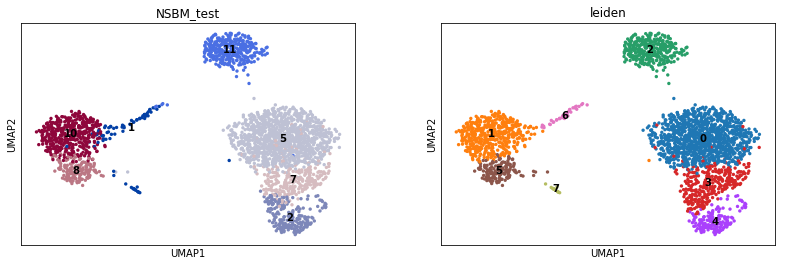

In [125]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [126]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_w1k_e01_nb3.pkl",'wb'),2)
pickle.dump(h,open("pbmc/pbmc_weighted_vs_normal/h_w1k_e01_nb3.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pbmc_weighted_vs_normal/pv_w1k_e01_nb3.pkl",'wb'),2)

In [127]:
e_state_w1k_e01_nb3=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_w1k_e01_nb3.pkl", "rb" ))
h_w1k_e01_nb3=pickle.load( open("pbmc/pbmc_weighted_vs_normal/h_w1k_e01_nb3.pkl", "rb" ))
pv_w1k_e01_nb3=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/pv_w1k_e01_nb3.pkl", "rb" ))

##### 2bg) w=1000, nbreaks=4, epsilon=0.01 (503 secondi, circa 8 minuti)

In [128]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=10, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [129]:
bs = state_sweep1k_g.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep1k_g.copy(bs=bs, sampling=True)

a=time.time()
gt.mcmc_equilibrate(state, wait=1000,nbreaks=4, max_niter=10000,epsilon=0.01, mcmc_args=dict(niter=10),callback=collect_info, verbose=True)
b=time.time()
state

niter:     1  count:    1  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97671.808  ΔS:      190.622  moves:  7207 
niter:     2  count:    2  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97639.763  ΔS:     -32.0450  moves:  7325 
niter:     3  count:    3  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97634.036  ΔS:     -5.72682  moves:  7348 
niter:     4  count:    4  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97616.111  ΔS:     -17.9249  moves:  7314 
niter:     5  count:    5  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97681.272  ΔS:      65.1603  moves:  7261 
niter:     6  count:    6  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97635.085  ΔS:     -46.1868  moves:  7262 
niter:     7  count:    7  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97603.117  ΔS:     -31.9682  moves:  7397 
niter:     8  count:    8  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97554.337  ΔS:     -48.7793  moves:  7421 
niter:     9  count:    9  break

niter:    69  count:   69  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97467.804  ΔS:     -17.3335  moves:  7081 
niter:    70  count:   70  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97453.440  ΔS:     -14.3641  moves:  7065 
niter:    71  count:   71  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97442.105  ΔS:     -11.3353  moves:  7197 
niter:    72  count:   72  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97408.599  ΔS:     -33.5059  moves:  7121 
niter:    73  count:   73  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97400.513  ΔS:     -8.08564  moves:  7214 
niter:    74  count:   74  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97435.616  ΔS:      35.1029  moves:  6995 
niter:    75  count:   75  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97439.046  ΔS:      3.43047  moves:  7119 
niter:    76  count:   76  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97439.620  ΔS:     0.573176  moves:  7046 
niter:    77  count:   77  break

niter:   137  count:  137  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97424.884  ΔS:     -25.7951  moves:  7022 
niter:   138  count:  138  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97431.419  ΔS:      6.53586  moves:  6764 
niter:   139  count:  139  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97410.918  ΔS:     -20.5012  moves:  7030 
niter:   140  count:  140  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97406.359  ΔS:     -4.55924  moves:  6961 
niter:   141  count:  141  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97407.405  ΔS:      1.04544  moves:  6935 
niter:   142  count:  142  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97420.883  ΔS:      13.4788  moves:  6957 
niter:   143  count:  143  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97490.616  ΔS:      69.7328  moves:  7081 
niter:   144  count:  144  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97476.312  ΔS:     -14.3037  moves:  7122 
niter:   145  count:  145  break

niter:   205  count:  205  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97485.036  ΔS:      51.3628  moves:  6895 
niter:   206  count:  206  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97486.357  ΔS:      1.32111  moves:  6805 
niter:   207  count:  207  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97414.365  ΔS:     -71.9918  moves:  6988 
niter:   208  count:  208  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97466.814  ΔS:      52.4493  moves:  6847 
niter:   209  count:  209  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97448.631  ΔS:     -18.1833  moves:  6902 
niter:   210  count:  210  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97437.856  ΔS:     -10.7752  moves:  6999 
niter:   211  count:  211  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97430.702  ΔS:     -7.15323  moves:  6878 
niter:   212  count:  212  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97386.199  ΔS:     -44.5033  moves:  6925 
niter:   213  count:  213  break

niter:   273  count:  273  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97458.084  ΔS:      14.6379  moves:  6854 
niter:   274  count:  274  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97468.357  ΔS:      10.2732  moves:  6979 
niter:   275  count:  275  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97457.349  ΔS:     -11.0088  moves:  6945 
niter:   276  count:  276  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97418.968  ΔS:     -38.3810  moves:  6821 
niter:   277  count:  277  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97473.524  ΔS:      54.5563  moves:  6980 
niter:   278  count:  278  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97510.169  ΔS:      36.6449  moves:  6934 
niter:   279  count:  279  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97490.089  ΔS:     -20.0797  moves:  6856 
niter:   280  count:  280  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97440.651  ΔS:     -49.4379  moves:  7066 
niter:   281  count:  281  break

niter:   341  count:  341  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97386.014  ΔS:      8.54492  moves:  6848 
niter:   342  count:  342  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97418.086  ΔS:      32.0719  moves:  6890 
niter:   343  count:  343  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97417.978  ΔS:    -0.107330  moves:  6864 
niter:   344  count:  344  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97407.376  ΔS:     -10.6023  moves:  6881 
niter:   345  count:  345  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97394.434  ΔS:     -12.9419  moves:  6860 
niter:   346  count:  346  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97447.538  ΔS:      53.1041  moves:  6894 
niter:   347  count:  347  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97424.887  ΔS:     -22.6510  moves:  6906 
niter:   348  count:  348  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97405.280  ΔS:     -19.6068  moves:  6714 
niter:   349  count:  349  break

niter:   410  count:  410  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97362.587  ΔS:      21.9545  moves:  6982 
niter:   411  count:  411  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97316.811  ΔS:     -45.7755  moves:  6879 
niter:   412  count:  412  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97347.671  ΔS:      30.8591  moves:  6895 
niter:   413  count:  413  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97327.926  ΔS:     -19.7441  moves:  6868 
niter:   414  count:  414  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97320.301  ΔS:     -7.62508  moves:  6935 
niter:   415  count:  415  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97400.672  ΔS:      80.3711  moves:  6927 
niter:   416  count:  416  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97377.416  ΔS:     -23.2561  moves:  6778 
niter:   417  count:  417  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97349.304  ΔS:     -28.1126  moves:  6758 
niter:   418  count:  418  break

niter:   478  count:  478  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97382.909  ΔS:     -67.8310  moves:  6940 
niter:   479  count:  479  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97317.369  ΔS:     -65.5401  moves:  6982 
niter:   480  count:  480  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97369.943  ΔS:      52.5738  moves:  6970 
niter:   481  count:  481  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97368.466  ΔS:     -1.47674  moves:  6814 
niter:   482  count:  482  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97330.624  ΔS:     -37.8419  moves:  6853 
niter:   483  count:  483  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97374.749  ΔS:      44.1245  moves:  7052 
niter:   484  count:  484  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97311.580  ΔS:     -63.1683  moves:  6933 
niter:   485  count:  485  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97364.887  ΔS:      53.3068  moves:  6957 
niter:   486  count:  486  break

niter:   546  count:  546  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97353.586  ΔS:     -54.6516  moves:  6871 
niter:   547  count:  547  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97336.692  ΔS:     -16.8938  moves:  6662 
niter:   548  count:  548  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97343.465  ΔS:      6.77243  moves:  6832 
niter:   549  count:  549  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97339.234  ΔS:     -4.23009  moves:  6833 
niter:   550  count:  550  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97343.707  ΔS:      4.47210  moves:  6755 
niter:   551  count:  551  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97358.389  ΔS:      14.6829  moves:  6612 
niter:   552  count:  552  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97332.606  ΔS:     -25.7835  moves:  6790 
niter:   553  count:  553  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97349.804  ΔS:      17.1984  moves:  6591 
niter:   554  count:  554  break

niter:   614  count:  614  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97350.774  ΔS:     -5.73132  moves:  6734 
niter:   615  count:  615  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97348.786  ΔS:     -1.98768  moves:  6825 
niter:   616  count:  616  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97384.391  ΔS:      35.6054  moves:  6874 
niter:   617  count:  617  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97368.493  ΔS:     -15.8987  moves:  6866 
niter:   618  count:  618  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97408.395  ΔS:      39.9023  moves:  6817 
niter:   619  count:  619  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97432.210  ΔS:      23.8155  moves:  6804 
niter:   620  count:  620  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97428.078  ΔS:     -4.13230  moves:  6982 
niter:   621  count:  621  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97427.214  ΔS:    -0.863721  moves:  7020 
niter:   622  count:  622  break

niter:   682  count:  682  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97416.152  ΔS:     -59.9667  moves:  6720 
niter:   683  count:  683  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97375.952  ΔS:     -40.1993  moves:  6808 
niter:   684  count:  684  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97358.233  ΔS:     -17.7198  moves:  6828 
niter:   685  count:  685  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97382.188  ΔS:      23.9553  moves:  6727 
niter:   686  count:  686  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97371.044  ΔS:     -11.1441  moves:  6708 
niter:   687  count:  687  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97337.605  ΔS:     -33.4387  moves:  6881 
niter:   688  count:  688  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97366.373  ΔS:      28.7679  moves:  6950 
niter:   689  count:  689  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97306.608  ΔS:     -59.7646  moves:  6725 
niter:   690  count:  690  break

niter:   750  count:  750  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97437.403  ΔS:      8.59888  moves:  6758 
niter:   751  count:  751  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97440.086  ΔS:      2.68260  moves:  6689 
niter:   752  count:  752  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97434.116  ΔS:     -5.97046  moves:  6783 
niter:   753  count:  753  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97416.875  ΔS:     -17.2402  moves:  6602 
niter:   754  count:  754  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97399.554  ΔS:     -17.3215  moves:  6724 
niter:   755  count:  755  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97467.205  ΔS:      67.6510  moves:  6974 
niter:   756  count:  756  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97447.068  ΔS:     -20.1364  moves:  6764 
niter:   757  count:  757  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97441.333  ΔS:     -5.73536  moves:  6856 
niter:   758  count:  758  break

niter:   818  count:  818  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97417.632  ΔS:      45.8690  moves:  6683 
niter:   819  count:  819  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97412.652  ΔS:     -4.98002  moves:  6700 
niter:   820  count:  820  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97425.658  ΔS:      13.0064  moves:  6848 
niter:   821  count:  821  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97424.131  ΔS:     -1.52690  moves:  6738 
niter:   822  count:  822  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97389.265  ΔS:     -34.8661  moves:  6729 
niter:   823  count:  823  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97319.129  ΔS:     -70.1358  moves:  6765 
niter:   824  count:  824  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97299.470  ΔS:     -19.6595  moves:  6737 
niter:   825  count:  825  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97311.033  ΔS:      11.5626  moves:  6718 
niter:   826  count:  826  break

niter:   886  count:  886  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97404.152  ΔS:      35.9690  moves:  6805 
niter:   887  count:  887  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97420.980  ΔS:      16.8283  moves:  6653 
niter:   888  count:  888  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97360.349  ΔS:     -60.6308  moves:  6652 
niter:   889  count:  889  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97405.875  ΔS:      45.5259  moves:  6656 
niter:   890  count:  890  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97391.193  ΔS:     -14.6822  moves:  6553 
niter:   891  count:  891  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97413.396  ΔS:      22.2034  moves:  6590 
niter:   892  count:  892  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97374.965  ΔS:     -38.4310  moves:  6596 
niter:   893  count:  893  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97330.589  ΔS:     -44.3757  moves:  6529 
niter:   894  count:  894  break

niter:   954  count:  954  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97351.974  ΔS:     -28.6378  moves:  6536 
niter:   955  count:  955  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97306.096  ΔS:     -45.8784  moves:  6584 
niter:   956  count:  956  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97312.361  ΔS:      6.26526  moves:  6648 
niter:   957  count:  957  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97325.995  ΔS:      13.6334  moves:  6563 
niter:   958  count:  958  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97337.983  ΔS:      11.9880  moves:  6601 
niter:   959  count:  959  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97338.676  ΔS:     0.693580  moves:  6582 
niter:   960  count:  960  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97316.381  ΔS:     -22.2955  moves:  6561 
niter:   961  count:  961  breaks:  0  min_S: 97481.186  max_S: 97481.186  S: 97310.991  ΔS:     -5.38975  moves:  6457 
niter:   962  count:  962  break

niter:  1022  count:   22  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97365.646  ΔS:      26.7510  moves:  6656 
niter:  1023  count:   23  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97365.517  ΔS:    -0.129112  moves:  6696 
niter:  1024  count:   24  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97332.450  ΔS:     -33.0667  moves:  6536 
niter:  1025  count:   25  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97317.960  ΔS:     -14.4901  moves:  6603 
niter:  1026  count:   26  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97370.319  ΔS:      52.3596  moves:  6636 
niter:  1027  count:   27  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97295.237  ΔS:     -75.0823  moves:  6740 
niter:  1028  count:   28  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97321.027  ΔS:      25.7904  moves:  6564 
niter:  1029  count:   29  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97285.774  ΔS:     -35.2536  moves:  6606 
niter:  1030  count:   30  break

niter:  1090  count:   90  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97277.556  ΔS:     -64.4584  moves:  6575 
niter:  1091  count:   91  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97265.208  ΔS:     -12.3484  moves:  6518 
niter:  1092  count:   92  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97258.364  ΔS:     -6.84375  moves:  6508 
niter:  1093  count:   93  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97334.786  ΔS:      76.4221  moves:  6444 
niter:  1094  count:   94  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97318.069  ΔS:     -16.7170  moves:  6468 
niter:  1095  count:   95  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97332.046  ΔS:      13.9769  moves:  6417 
niter:  1096  count:   96  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97303.785  ΔS:     -28.2607  moves:  6550 
niter:  1097  count:   97  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97322.850  ΔS:      19.0650  moves:  6430 
niter:  1098  count:   98  break

niter:  1158  count:  158  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97352.559  ΔS:     -10.5113  moves:  6519 
niter:  1159  count:  159  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97359.647  ΔS:      7.08889  moves:  6711 
niter:  1160  count:  160  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97347.842  ΔS:     -11.8057  moves:  6649 
niter:  1161  count:  161  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97335.999  ΔS:     -11.8429  moves:  6521 
niter:  1162  count:  162  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97308.282  ΔS:     -27.7166  moves:  6451 
niter:  1163  count:  163  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97341.500  ΔS:      33.2172  moves:  6513 
niter:  1164  count:  164  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97390.795  ΔS:      49.2950  moves:  6532 
niter:  1165  count:  165  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97324.554  ΔS:     -66.2408  moves:  6502 
niter:  1166  count:  166  break

niter:  1226  count:  226  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97353.835  ΔS:      53.7430  moves:  6556 
niter:  1227  count:  227  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97293.898  ΔS:     -59.9364  moves:  6508 
niter:  1228  count:  228  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97320.388  ΔS:      26.4901  moves:  6416 
niter:  1229  count:  229  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97357.315  ΔS:      36.9266  moves:  6423 
niter:  1230  count:  230  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97366.090  ΔS:      8.77507  moves:  6539 
niter:  1231  count:  231  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97362.111  ΔS:     -3.97896  moves:  6542 
niter:  1232  count:  232  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97323.747  ΔS:     -38.3640  moves:  6414 
niter:  1233  count:  233  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97341.677  ΔS:      17.9295  moves:  6392 
niter:  1234  count:  234  break

niter:  1294  count:  294  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97322.340  ΔS:      31.6318  moves:  6326 
niter:  1295  count:  295  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97323.357  ΔS:      1.01718  moves:  6497 
niter:  1296  count:  296  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97280.805  ΔS:     -42.5520  moves:  6422 
niter:  1297  count:  297  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97269.972  ΔS:     -10.8331  moves:  6404 
niter:  1298  count:  298  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97321.123  ΔS:      51.1509  moves:  6486 
niter:  1299  count:  299  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97339.018  ΔS:      17.8955  moves:  6469 
niter:  1300  count:  300  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97315.158  ΔS:     -23.8601  moves:  6392 
niter:  1301  count:  301  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97339.672  ΔS:      24.5141  moves:  6366 
niter:  1302  count:  302  break

niter:  1362  count:  362  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97331.299  ΔS:      20.8263  moves:  6481 
niter:  1363  count:  363  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97326.959  ΔS:     -4.33995  moves:  6576 
niter:  1364  count:  364  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97302.297  ΔS:     -24.6620  moves:  6471 
niter:  1365  count:  365  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97310.625  ΔS:      8.32827  moves:  6435 
niter:  1366  count:  366  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97319.443  ΔS:      8.81830  moves:  6418 
niter:  1367  count:  367  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97283.264  ΔS:     -36.1787  moves:  6390 
niter:  1368  count:  368  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97304.344  ΔS:      21.0799  moves:  6443 
niter:  1369  count:  369  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97298.979  ΔS:     -5.36546  moves:  6378 
niter:  1370  count:  370  break

niter:  1430  count:  430  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97316.503  ΔS:      2.24358  moves:  6372 
niter:  1431  count:  431  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97375.942  ΔS:      59.4393  moves:  6281 
niter:  1432  count:  432  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97292.594  ΔS:     -83.3481  moves:  6448 
niter:  1433  count:  433  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97364.265  ΔS:      71.6706  moves:  6521 
niter:  1434  count:  434  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97305.899  ΔS:     -58.3657  moves:  6420 
niter:  1435  count:  435  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97362.076  ΔS:      56.1769  moves:  6435 
niter:  1436  count:  436  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97325.840  ΔS:     -36.2358  moves:  6449 
niter:  1437  count:  437  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97422.516  ΔS:      96.6757  moves:  6398 
niter:  1438  count:  438  break

niter:  1498  count:  498  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97272.194  ΔS:      16.5482  moves:  6506 
niter:  1499  count:  499  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97270.035  ΔS:     -2.15929  moves:  6465 
niter:  1500  count:  500  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97277.772  ΔS:      7.73665  moves:  6425 
niter:  1501  count:  501  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97281.534  ΔS:      3.76295  moves:  6351 
niter:  1502  count:  502  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97290.897  ΔS:      9.36225  moves:  6324 
niter:  1503  count:  503  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97267.750  ΔS:     -23.1468  moves:  6358 
niter:  1504  count:  504  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97362.197  ΔS:      94.4468  moves:  6480 
niter:  1505  count:  505  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97335.024  ΔS:     -27.1732  moves:  6422 
niter:  1506  count:  506  break

niter:  1566  count:  566  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97344.581  ΔS:      30.8458  moves:  6503 
niter:  1567  count:  567  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97275.741  ΔS:     -68.8399  moves:  6300 
niter:  1568  count:  568  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97265.090  ΔS:     -10.6509  moves:  6450 
niter:  1569  count:  569  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97289.579  ΔS:      24.4891  moves:  6386 
niter:  1570  count:  570  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97228.245  ΔS:     -61.3343  moves:  6431 
niter:  1571  count:  571  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97320.870  ΔS:      92.6253  moves:  6499 
niter:  1572  count:  572  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97298.909  ΔS:     -21.9606  moves:  6508 
niter:  1573  count:  573  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97367.847  ΔS:      68.9374  moves:  6471 
niter:  1574  count:  574  break

niter:  1634  count:  634  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97366.516  ΔS:      76.6199  moves:  6379 
niter:  1635  count:  635  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97324.980  ΔS:     -41.5367  moves:  6408 
niter:  1636  count:  636  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97336.389  ΔS:      11.4093  moves:  6399 
niter:  1637  count:  637  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97379.495  ΔS:      43.1065  moves:  6429 
niter:  1638  count:  638  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97326.533  ΔS:     -52.9621  moves:  6583 
niter:  1639  count:  639  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97302.973  ΔS:     -23.5599  moves:  6554 
niter:  1640  count:  640  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97303.759  ΔS:     0.785483  moves:  6572 
niter:  1641  count:  641  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97354.834  ΔS:      51.0755  moves:  6542 
niter:  1642  count:  642  break

niter:  1702  count:  702  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97292.513  ΔS:     -46.7439  moves:  6323 
niter:  1703  count:  703  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97336.566  ΔS:      44.0528  moves:  6498 
niter:  1704  count:  704  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97316.324  ΔS:     -20.2420  moves:  6386 
niter:  1705  count:  705  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97308.225  ΔS:     -8.09857  moves:  6406 
niter:  1706  count:  706  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97286.918  ΔS:     -21.3071  moves:  6461 
niter:  1707  count:  707  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97336.316  ΔS:      49.3979  moves:  6420 
niter:  1708  count:  708  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97264.348  ΔS:     -71.9680  moves:  6555 
niter:  1709  count:  709  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97284.758  ΔS:      20.4096  moves:  6506 
niter:  1710  count:  710  break

niter:  1770  count:  770  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97347.526  ΔS:     -18.7661  moves:  6327 
niter:  1771  count:  771  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97337.079  ΔS:     -10.4466  moves:  6405 
niter:  1772  count:  772  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97338.023  ΔS:     0.944307  moves:  6230 
niter:  1773  count:  773  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97376.947  ΔS:      38.9239  moves:  6272 
niter:  1774  count:  774  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97316.541  ΔS:     -60.4058  moves:  6397 
niter:  1775  count:  775  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97321.010  ΔS:      4.46913  moves:  6374 
niter:  1776  count:  776  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97347.672  ΔS:      26.6618  moves:  6380 
niter:  1777  count:  777  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97368.145  ΔS:      20.4725  moves:  6532 
niter:  1778  count:  778  break

niter:  1838  count:  838  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97359.558  ΔS:      41.7138  moves:  6384 
niter:  1839  count:  839  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97358.114  ΔS:     -1.44467  moves:  6263 
niter:  1840  count:  840  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97350.107  ΔS:     -8.00624  moves:  6530 
niter:  1841  count:  841  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97322.704  ΔS:     -27.4029  moves:  6325 
niter:  1842  count:  842  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97312.636  ΔS:     -10.0683  moves:  6401 
niter:  1843  count:  843  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97271.560  ΔS:     -41.0764  moves:  6365 
niter:  1844  count:  844  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97255.114  ΔS:     -16.4456  moves:  6422 
niter:  1845  count:  845  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97248.359  ΔS:     -6.75473  moves:  6423 
niter:  1846  count:  846  break

niter:  1906  count:  906  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97278.235  ΔS:      6.37801  moves:  6452 
niter:  1907  count:  907  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97293.828  ΔS:      15.5932  moves:  6421 
niter:  1908  count:  908  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97222.245  ΔS:     -71.5832  moves:  6437 
niter:  1909  count:  909  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97269.980  ΔS:      47.7350  moves:  6334 
niter:  1910  count:  910  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97275.891  ΔS:      5.91140  moves:  6465 
niter:  1911  count:  911  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97344.121  ΔS:      68.2293  moves:  6329 
niter:  1912  count:  912  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97287.966  ΔS:     -56.1544  moves:  6407 
niter:  1913  count:  913  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97304.431  ΔS:      16.4652  moves:  6475 
niter:  1914  count:  914  break

niter:  1974  count:  974  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97310.077  ΔS:      55.7568  moves:  6406 
niter:  1975  count:  975  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97282.183  ΔS:     -27.8940  moves:  6417 
niter:  1976  count:  976  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97202.232  ΔS:     -79.9508  moves:  6429 
niter:  1977  count:  977  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97291.405  ΔS:      89.1729  moves:  6497 
niter:  1978  count:  978  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97311.704  ΔS:      20.2988  moves:  6599 
niter:  1979  count:  979  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97297.573  ΔS:     -14.1302  moves:  6494 
niter:  1980  count:  980  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97327.506  ΔS:      29.9325  moves:  6431 
niter:  1981  count:  981  breaks:  1  min_S: 97350.505  max_S: 97350.505  S: 97300.293  ΔS:     -27.2133  moves:  6434 
niter:  1982  count:  982  break

niter:  2042  count:   42  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97346.719  ΔS:     -9.66495  moves:  6474 
niter:  2043  count:   43  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97371.395  ΔS:      24.6769  moves:  6376 
niter:  2044  count:   44  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97339.508  ΔS:     -31.8870  moves:  6585 
niter:  2045  count:   45  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97306.706  ΔS:     -32.8024  moves:  6457 
niter:  2046  count:   46  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97280.519  ΔS:     -26.1866  moves:  6422 
niter:  2047  count:   47  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97267.877  ΔS:     -12.6423  moves:  6302 
niter:  2048  count:   48  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97363.736  ΔS:      95.8584  moves:  6357 
niter:  2049  count:   49  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97344.274  ΔS:     -19.4614  moves:  6290 
niter:  2050  count:   50  break

niter:  2110  count:  110  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97202.420  ΔS:     -70.8711  moves:  6492 
niter:  2111  count:  111  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97292.639  ΔS:      90.2189  moves:  6475 
niter:  2112  count:  112  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97270.351  ΔS:     -22.2877  moves:  6448 
niter:  2113  count:  113  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97323.595  ΔS:      53.2437  moves:  6433 
niter:  2114  count:  114  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97333.832  ΔS:      10.2373  moves:  6322 
niter:  2115  count:  115  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97329.239  ΔS:     -4.59272  moves:  6420 
niter:  2116  count:  116  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97266.104  ΔS:     -63.1353  moves:  6497 
niter:  2117  count:  117  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97306.977  ΔS:      40.8728  moves:  6340 
niter:  2118  count:  118  break

niter:  2178  count:  178  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97303.696  ΔS:      28.2745  moves:  6461 
niter:  2179  count:  179  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97340.457  ΔS:      36.7612  moves:  6340 
niter:  2180  count:  180  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97338.546  ΔS:     -1.91129  moves:  6445 
niter:  2181  count:  181  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97288.876  ΔS:     -49.6700  moves:  6463 
niter:  2182  count:  182  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97313.556  ΔS:      24.6806  moves:  6488 
niter:  2183  count:  183  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97376.387  ΔS:      62.8302  moves:  6455 
niter:  2184  count:  184  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97332.690  ΔS:     -43.6963  moves:  6384 
niter:  2185  count:  185  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97342.016  ΔS:      9.32608  moves:  6441 
niter:  2186  count:  186  break

niter:  2246  count:  246  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97294.681  ΔS:     -50.7758  moves:  6428 
niter:  2247  count:  247  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97291.889  ΔS:     -2.79264  moves:  6366 
niter:  2248  count:  248  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97358.859  ΔS:      66.9708  moves:  6379 
niter:  2249  count:  249  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97261.423  ΔS:     -97.4362  moves:  6387 
niter:  2250  count:  250  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97380.173  ΔS:      118.750  moves:  6386 
niter:  2251  count:  251  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97323.550  ΔS:     -56.6230  moves:  6456 
niter:  2252  count:  252  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97284.771  ΔS:     -38.7794  moves:  6670 
niter:  2253  count:  253  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97346.650  ΔS:      61.8790  moves:  6514 
niter:  2254  count:  254  break

niter:  2314  count:  314  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97355.161  ΔS:      3.42613  moves:  6453 
niter:  2315  count:  315  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97295.983  ΔS:     -59.1784  moves:  6352 
niter:  2316  count:  316  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97303.770  ΔS:      7.78666  moves:  6358 
niter:  2317  count:  317  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97218.860  ΔS:     -84.9093  moves:  6223 
niter:  2318  count:  318  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97230.449  ΔS:      11.5882  moves:  6396 
niter:  2319  count:  319  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97289.822  ΔS:      59.3737  moves:  6215 
niter:  2320  count:  320  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97217.188  ΔS:     -72.6338  moves:  6387 
niter:  2321  count:  321  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97206.968  ΔS:     -10.2205  moves:  6170 
niter:  2322  count:  322  break

niter:  2382  count:  382  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97314.012  ΔS:      45.2551  moves:  6276 
niter:  2383  count:  383  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97262.135  ΔS:     -51.8775  moves:  6334 
niter:  2384  count:  384  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97288.851  ΔS:      26.7163  moves:  6222 
niter:  2385  count:  385  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97277.696  ΔS:     -11.1553  moves:  6197 
niter:  2386  count:  386  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97296.061  ΔS:      18.3649  moves:  6315 
niter:  2387  count:  387  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97269.901  ΔS:     -26.1593  moves:  6289 
niter:  2388  count:  388  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97302.873  ΔS:      32.9715  moves:  6260 
niter:  2389  count:  389  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97319.812  ΔS:      16.9389  moves:  6305 
niter:  2390  count:  390  break

niter:  2450  count:  450  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97260.536  ΔS:     -25.4414  moves:  6400 
niter:  2451  count:  451  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97316.759  ΔS:      56.2231  moves:  6332 
niter:  2452  count:  452  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97331.266  ΔS:      14.5070  moves:  6249 
niter:  2453  count:  453  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97286.211  ΔS:     -45.0558  moves:  6304 
niter:  2454  count:  454  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97338.794  ΔS:      52.5833  moves:  6247 
niter:  2455  count:  455  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97324.382  ΔS:     -14.4120  moves:  6260 
niter:  2456  count:  456  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97265.193  ΔS:     -59.1889  moves:  6208 
niter:  2457  count:  457  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97228.984  ΔS:     -36.2093  moves:  6341 
niter:  2458  count:  458  break

niter:  2518  count:  518  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97256.742  ΔS:     -21.7190  moves:  6323 
niter:  2519  count:  519  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97243.759  ΔS:     -12.9832  moves:  6391 
niter:  2520  count:  520  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97222.871  ΔS:     -20.8876  moves:  6155 
niter:  2521  count:  521  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97281.748  ΔS:      58.8767  moves:  6318 
niter:  2522  count:  522  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97263.517  ΔS:     -18.2309  moves:  6406 
niter:  2523  count:  523  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97326.303  ΔS:      62.7861  moves:  6184 
niter:  2524  count:  524  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97267.238  ΔS:     -59.0651  moves:  6346 
niter:  2525  count:  525  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97250.867  ΔS:     -16.3715  moves:  6261 
niter:  2526  count:  526  break

niter:  2586  count:  586  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97244.957  ΔS:     -22.8748  moves:  6314 
niter:  2587  count:  587  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97279.086  ΔS:      34.1285  moves:  6237 
niter:  2588  count:  588  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97323.512  ΔS:      44.4264  moves:  6134 
niter:  2589  count:  589  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97351.782  ΔS:      28.2698  moves:  6328 
niter:  2590  count:  590  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97329.338  ΔS:     -22.4435  moves:  6399 
niter:  2591  count:  591  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97251.800  ΔS:     -77.5384  moves:  6265 
niter:  2592  count:  592  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97301.498  ΔS:      49.6980  moves:  6371 
niter:  2593  count:  593  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97263.571  ΔS:     -37.9267  moves:  6513 
niter:  2594  count:  594  break

niter:  2654  count:  654  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97206.381  ΔS:     -88.8968  moves:  6346 
niter:  2655  count:  655  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97270.495  ΔS:      64.1140  moves:  6316 
niter:  2656  count:  656  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97281.606  ΔS:      11.1111  moves:  6312 
niter:  2657  count:  657  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97294.453  ΔS:      12.8470  moves:  6444 
niter:  2658  count:  658  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97287.430  ΔS:     -7.02277  moves:  6289 
niter:  2659  count:  659  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97273.828  ΔS:     -13.6019  moves:  6344 
niter:  2660  count:  660  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97289.736  ΔS:      15.9072  moves:  6354 
niter:  2661  count:  661  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97279.813  ΔS:     -9.92294  moves:  6428 
niter:  2662  count:  662  break

niter:  2722  count:  722  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97224.521  ΔS:     -61.5008  moves:  6313 
niter:  2723  count:  723  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97264.905  ΔS:      40.3846  moves:  6329 
niter:  2724  count:  724  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97285.759  ΔS:      20.8534  moves:  6310 
niter:  2725  count:  725  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97279.676  ΔS:     -6.08262  moves:  6261 
niter:  2726  count:  726  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97257.720  ΔS:     -21.9557  moves:  6376 
niter:  2727  count:  727  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97297.323  ΔS:      39.6029  moves:  6380 
niter:  2728  count:  728  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97249.041  ΔS:     -48.2823  moves:  6379 
niter:  2729  count:  729  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97249.759  ΔS:     0.718437  moves:  6282 
niter:  2730  count:  730  break

niter:  2790  count:  790  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97249.223  ΔS:     -31.5853  moves:  6292 
niter:  2791  count:  791  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97316.304  ΔS:      67.0815  moves:  6284 
niter:  2792  count:  792  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97283.239  ΔS:     -33.0652  moves:  6413 
niter:  2793  count:  793  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97237.196  ΔS:     -46.0432  moves:  6366 
niter:  2794  count:  794  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97251.040  ΔS:      13.8439  moves:  6306 
niter:  2795  count:  795  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97341.525  ΔS:      90.4850  moves:  6297 
niter:  2796  count:  796  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97312.442  ΔS:     -29.0828  moves:  6294 
niter:  2797  count:  797  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97308.532  ΔS:     -3.90992  moves:  6396 
niter:  2798  count:  798  break

niter:  2858  count:  858  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97347.610  ΔS:      53.1318  moves:  6395 
niter:  2859  count:  859  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97288.850  ΔS:     -58.7603  moves:  6314 
niter:  2860  count:  860  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97243.380  ΔS:     -45.4702  moves:  6311 
niter:  2861  count:  861  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97260.631  ΔS:      17.2516  moves:  6296 
niter:  2862  count:  862  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97237.289  ΔS:     -23.3426  moves:  6184 
niter:  2863  count:  863  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97265.742  ΔS:      28.4531  moves:  6292 
niter:  2864  count:  864  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97273.443  ΔS:      7.70111  moves:  6433 
niter:  2865  count:  865  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97291.957  ΔS:      18.5138  moves:  6409 
niter:  2866  count:  866  break

niter:  2926  count:  926  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97312.347  ΔS:      38.0814  moves:  6428 
niter:  2927  count:  927  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97271.195  ΔS:     -41.1522  moves:  6320 
niter:  2928  count:  928  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97353.164  ΔS:      81.9693  moves:  6377 
niter:  2929  count:  929  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97310.686  ΔS:     -42.4781  moves:  6265 
niter:  2930  count:  930  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97299.582  ΔS:     -11.1036  moves:  6397 
niter:  2931  count:  931  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97244.325  ΔS:     -55.2577  moves:  6348 
niter:  2932  count:  932  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97293.052  ΔS:      48.7273  moves:  6342 
niter:  2933  count:  933  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97260.038  ΔS:     -33.0144  moves:  6379 
niter:  2934  count:  934  break

niter:  2994  count:  994  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97279.749  ΔS:      13.8486  moves:  6385 
niter:  2995  count:  995  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97263.738  ΔS:     -16.0104  moves:  6490 
niter:  2996  count:  996  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97241.732  ΔS:     -22.0065  moves:  6333 
niter:  2997  count:  997  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97269.245  ΔS:      27.5134  moves:  6366 
niter:  2998  count:  998  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97284.239  ΔS:      14.9938  moves:  6350 
niter:  2999  count:  999  breaks:  2  min_S: 97336.777  max_S: 97336.777  S: 97296.439  ΔS:      12.2001  moves:  6430 
niter:  3000  count:    0  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97300.662  ΔS:      4.22269  moves:  6313 
niter:  3001  count:    1  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97232.322  ΔS:     -68.3402  moves:  6368 
niter:  3002  count:    2  break

niter:  3062  count:   62  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97235.656  ΔS:     -14.5569  moves:  6265 
niter:  3063  count:   63  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97234.092  ΔS:     -1.56436  moves:  6328 
niter:  3064  count:   64  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97237.481  ΔS:      3.38922  moves:  6261 
niter:  3065  count:   65  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97269.185  ΔS:      31.7038  moves:  6303 
niter:  3066  count:   66  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97271.944  ΔS:      2.75897  moves:  6357 
niter:  3067  count:   67  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97305.282  ΔS:      33.3377  moves:  6316 
niter:  3068  count:   68  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97263.202  ΔS:     -42.0793  moves:  6324 
niter:  3069  count:   69  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97233.627  ΔS:     -29.5759  moves:  6339 
niter:  3070  count:   70  break

niter:  3130  count:  130  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97360.004  ΔS:      50.7836  moves:  6401 
niter:  3131  count:  131  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97339.708  ΔS:     -20.2968  moves:  6295 
niter:  3132  count:  132  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97332.216  ΔS:     -7.49124  moves:  6283 
niter:  3133  count:  133  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97277.580  ΔS:     -54.6365  moves:  6434 
niter:  3134  count:  134  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97324.819  ΔS:      47.2394  moves:  6440 
niter:  3135  count:  135  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97288.197  ΔS:     -36.6220  moves:  6371 
niter:  3136  count:  136  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97322.959  ΔS:      34.7613  moves:  6307 
niter:  3137  count:  137  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97286.970  ΔS:     -35.9885  moves:  6289 
niter:  3138  count:  138  break

niter:  3198  count:  198  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97259.212  ΔS:      10.7594  moves:  6384 
niter:  3199  count:  199  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97281.632  ΔS:      22.4200  moves:  6321 
niter:  3200  count:  200  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97256.222  ΔS:     -25.4105  moves:  6390 
niter:  3201  count:  201  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97235.520  ΔS:     -20.7014  moves:  6354 
niter:  3202  count:  202  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97262.646  ΔS:      27.1256  moves:  6455 
niter:  3203  count:  203  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97282.707  ΔS:      20.0617  moves:  6412 
niter:  3204  count:  204  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97293.879  ΔS:      11.1718  moves:  6339 
niter:  3205  count:  205  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97287.325  ΔS:     -6.55453  moves:  6340 
niter:  3206  count:  206  break

niter:  3266  count:  266  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97301.179  ΔS:      40.1533  moves:  6331 
niter:  3267  count:  267  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97260.597  ΔS:     -40.5817  moves:  6310 
niter:  3268  count:  268  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97271.917  ΔS:      11.3200  moves:  6396 
niter:  3269  count:  269  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97256.498  ΔS:     -15.4188  moves:  6195 
niter:  3270  count:  270  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97279.219  ΔS:      22.7205  moves:  6330 
niter:  3271  count:  271  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97261.842  ΔS:     -17.3768  moves:  6388 
niter:  3272  count:  272  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97270.877  ΔS:      9.03545  moves:  6352 
niter:  3273  count:  273  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97296.998  ΔS:      26.1203  moves:  6232 
niter:  3274  count:  274  break

niter:  3334  count:  334  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97298.760  ΔS:     -12.5914  moves:  6280 
niter:  3335  count:  335  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97350.073  ΔS:      51.3127  moves:  6434 
niter:  3336  count:  336  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97347.741  ΔS:     -2.33206  moves:  6322 
niter:  3337  count:  337  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97343.651  ΔS:     -4.08964  moves:  6331 
niter:  3338  count:  338  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97319.504  ΔS:     -24.1473  moves:  6478 
niter:  3339  count:  339  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97357.606  ΔS:      38.1022  moves:  6329 
niter:  3340  count:  340  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97325.053  ΔS:     -32.5526  moves:  6477 
niter:  3341  count:  341  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97278.334  ΔS:     -46.7193  moves:  6371 
niter:  3342  count:  342  break

niter:  3402  count:  402  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97352.337  ΔS:    -0.194016  moves:  6371 
niter:  3403  count:  403  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97368.710  ΔS:      16.3731  moves:  6405 
niter:  3404  count:  404  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97371.648  ΔS:      2.93769  moves:  6367 
niter:  3405  count:  405  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97381.061  ΔS:      9.41345  moves:  6305 
niter:  3406  count:  406  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97349.917  ΔS:     -31.1442  moves:  6216 
niter:  3407  count:  407  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97341.817  ΔS:     -8.10035  moves:  6524 
niter:  3408  count:  408  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97288.776  ΔS:     -53.0405  moves:  6479 
niter:  3409  count:  409  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97340.045  ΔS:      51.2695  moves:  6497 
niter:  3410  count:  410  break

niter:  3470  count:  470  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97277.460  ΔS:     -16.5307  moves:  6430 
niter:  3471  count:  471  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97262.369  ΔS:     -15.0904  moves:  6256 
niter:  3472  count:  472  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97312.761  ΔS:      50.3913  moves:  6409 
niter:  3473  count:  473  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97297.341  ΔS:     -15.4197  moves:  6331 
niter:  3474  count:  474  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97260.185  ΔS:     -37.1558  moves:  6208 
niter:  3475  count:  475  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97254.037  ΔS:     -6.14864  moves:  6361 
niter:  3476  count:  476  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97238.922  ΔS:     -15.1147  moves:  6380 
niter:  3477  count:  477  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97261.413  ΔS:      22.4914  moves:  6352 
niter:  3478  count:  478  break

niter:  3538  count:  538  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97333.271  ΔS:      5.86837  moves:  6416 
niter:  3539  count:  539  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97323.546  ΔS:     -9.72503  moves:  6309 
niter:  3540  count:  540  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97330.955  ΔS:      7.40931  moves:  6293 
niter:  3541  count:  541  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97308.845  ΔS:     -22.1109  moves:  6214 
niter:  3542  count:  542  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97270.552  ΔS:     -38.2928  moves:  6328 
niter:  3543  count:  543  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97291.361  ΔS:      20.8089  moves:  6223 
niter:  3544  count:  544  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97313.645  ΔS:      22.2847  moves:  6192 
niter:  3545  count:  545  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97302.414  ΔS:     -11.2309  moves:  6090 
niter:  3546  count:  546  break

niter:  3606  count:  606  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97313.892  ΔS:     -2.85183  moves:  6302 
niter:  3607  count:  607  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97325.603  ΔS:      11.7112  moves:  6275 
niter:  3608  count:  608  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97278.029  ΔS:     -47.5738  moves:  6333 
niter:  3609  count:  609  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97251.103  ΔS:     -26.9257  moves:  6252 
niter:  3610  count:  610  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97244.748  ΔS:     -6.35548  moves:  6298 
niter:  3611  count:  611  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97305.539  ΔS:      60.7907  moves:  6332 
niter:  3612  count:  612  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97304.574  ΔS:    -0.964455  moves:  6352 
niter:  3613  count:  613  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97247.109  ΔS:     -57.4655  moves:  6403 
niter:  3614  count:  614  break

niter:  3674  count:  674  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97352.886  ΔS:      67.7941  moves:  6284 
niter:  3675  count:  675  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97299.490  ΔS:     -53.3967  moves:  6335 
niter:  3676  count:  676  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97221.435  ΔS:     -78.0551  moves:  6240 
niter:  3677  count:  677  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97239.334  ΔS:      17.8994  moves:  6411 
niter:  3678  count:  678  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97219.927  ΔS:     -19.4067  moves:  6254 
niter:  3679  count:  679  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97256.660  ΔS:      36.7330  moves:  6324 
niter:  3680  count:  680  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97299.450  ΔS:      42.7894  moves:  6246 
niter:  3681  count:  681  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97271.301  ΔS:     -28.1490  moves:  6258 
niter:  3682  count:  682  break

niter:  3742  count:  742  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97302.146  ΔS:     -25.5799  moves:  6303 
niter:  3743  count:  743  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97300.338  ΔS:     -1.80748  moves:  6276 
niter:  3744  count:  744  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97292.674  ΔS:     -7.66414  moves:  6368 
niter:  3745  count:  745  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97306.920  ΔS:      14.2462  moves:  6387 
niter:  3746  count:  746  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97294.533  ΔS:     -12.3877  moves:  6329 
niter:  3747  count:  747  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97342.149  ΔS:      47.6159  moves:  6369 
niter:  3748  count:  748  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97369.262  ΔS:      27.1132  moves:  6423 
niter:  3749  count:  749  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97355.602  ΔS:     -13.6598  moves:  6538 
niter:  3750  count:  750  break

niter:  3810  count:  810  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97283.654  ΔS:     -70.2859  moves:  6356 
niter:  3811  count:  811  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97262.259  ΔS:     -21.3943  moves:  6262 
niter:  3812  count:  812  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97294.837  ΔS:      32.5777  moves:  6368 
niter:  3813  count:  813  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97341.864  ΔS:      47.0275  moves:  6440 
niter:  3814  count:  814  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97272.870  ΔS:     -68.9947  moves:  6306 
niter:  3815  count:  815  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97289.102  ΔS:      16.2322  moves:  6366 
niter:  3816  count:  816  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97256.616  ΔS:     -32.4856  moves:  6396 
niter:  3817  count:  817  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97295.727  ΔS:      39.1106  moves:  6298 
niter:  3818  count:  818  break

niter:  3878  count:  878  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97360.552  ΔS:      6.06604  moves:  6368 
niter:  3879  count:  879  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97335.347  ΔS:     -25.2046  moves:  6234 
niter:  3880  count:  880  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97359.224  ΔS:      23.8770  moves:  6403 
niter:  3881  count:  881  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97314.320  ΔS:     -44.9043  moves:  6279 
niter:  3882  count:  882  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97331.834  ΔS:      17.5144  moves:  6356 
niter:  3883  count:  883  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97322.438  ΔS:     -9.39645  moves:  6207 
niter:  3884  count:  884  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97303.000  ΔS:     -19.4377  moves:  6257 
niter:  3885  count:  885  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97318.074  ΔS:      15.0733  moves:  6399 
niter:  3886  count:  886  break

niter:  3946  count:  946  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97260.246  ΔS:     -60.5178  moves:  6219 
niter:  3947  count:  947  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97285.422  ΔS:      25.1751  moves:  6313 
niter:  3948  count:  948  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97322.805  ΔS:      37.3837  moves:  6444 
niter:  3949  count:  949  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97303.789  ΔS:     -19.0160  moves:  6403 
niter:  3950  count:  950  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97283.919  ΔS:     -19.8699  moves:  6278 
niter:  3951  count:  951  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97336.058  ΔS:      52.1386  moves:  6489 
niter:  3952  count:  952  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97320.870  ΔS:     -15.1885  moves:  6269 
niter:  3953  count:  953  breaks:  3  min_S: 97300.662  max_S: 97300.662  S: 97315.401  ΔS:     -5.46834  moves:  6197 
niter:  3954  count:  954  break

<NestedBlockState object, with base <BlockState object with 61 blocks (58 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ff7f415e7d0>, at 0x7ff80538fa50>, and 10 levels of sizes [(2638, 58), (58, 18), (18, 8), (8, 6), (6, 5), (5, 4), (4, 2), (2, 2), (2, 2), (2, 2)] at 0x7ff80538f350>

In [130]:
c=b-a
c

503.3003249168396

leiden        0    1    2    3    4    5   6   7
NSBM_test                                       
1            35    0    0  229    1    0   0   0
3             0  458    0    0    0   11   0   0
4             0    0    0    0    0    0  26   0
6             0    0  340    0    0    0   0   0
8          1108    0    1   18    0    2   0   0
9             0   27    0    0    0  135   0   0
10            0    0    0   59  162    0   0   0
11            0    1    0    0    0    2  10  13


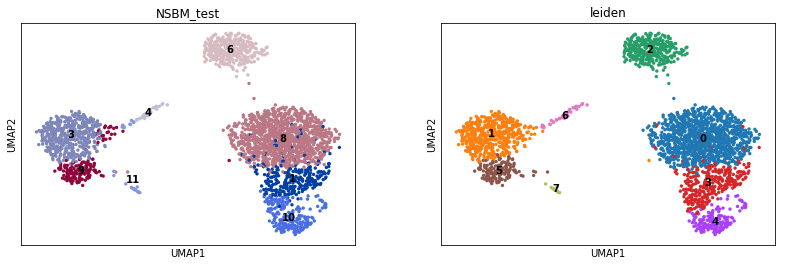

In [131]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [132]:
pickle.dump(state,open("pbmc/pbmc_weighted_vs_normal/state_w1k_e01_nb4.pkl",'wb'),2)
pickle.dump(h,open("pbmc/pbmc_weighted_vs_normal/h_w1k_e01_nb4.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pbmc_weighted_vs_normal/pv_w1k_e01_nb4.pkl",'wb'),2)

In [133]:
e_state_w1k_e01_nb4=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/state_w1k_e01_nb4.pkl", "rb" ))
h_w1k_e01_nb4=pickle.load( open("pbmc/pbmc_weighted_vs_normal/h_w1k_e01_nb4.pkl", "rb" ))
pv_w1k_e01_nb4=pickle.load( open( "pbmc/pbmc_weighted_vs_normal/pv_w1k_e01_nb4.pkl", "rb" ))